In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
#from resources.plotcm import plot_confusion_matrix
import itertools
import gc

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 960
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
# import argparse

class HParams(object):
	def __init__(self):
		# Dataset Settings
		self.dataset_path = 'd:/다운로드/gtzan'
		self.feature_path = 'feature5'
		self.genres = ['classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae']

		# Feature Parameters
		self.sample_rate = 22050
		self.fft_size = 1024
		self.win_size = 1024
		self.hop_size = 512
		self.num_mels = 128
		self.feature_length = 1024  # audio length = feature_length*hop_size/sample_rate (s)

		# Training Parameters
		self.device = 1  # 0: CPU, 1: GPU0, 2: GPU1, ...
		self.batch_size = 30
		self.num_epochs = 60
		self.learning_rate = 3*1e-5
		self.stopping_rate = 1e-9
		self.weight_decay = 1e-6
		self.momentum = 0.9
		self.factor = 0.7
		self.patience = 3.

hparams = HParams()

In [4]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader

class GTZANDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

# Function to get genre index for the give file
def get_label(file_name, hparams):
    genre = file_name.split('.')[0]
    label = hparams.genres.index(genre)
    return label

def load_dataset(set_name, hparams): #모든 데이터 읽어오기, 
    x = []
    y = []

    dataset_path = os.path.join(hparams.feature_path, set_name)
    for root,dirs,files in os.walk(dataset_path):
        for file in files:
            data = np.load(os.path.join(root,file))
            data = data[:1024]
            label = get_label(file, hparams)
            x.append(data)
            y.append(label)
            torch.cuda.empty_cache() 

    x = np.stack(x)
    y = np.stack(y)

    return x,y

def get_dataloader(hparams):
    x_train, y_train = load_dataset('train', hparams)
    x_valid, y_valid = load_dataset('valid', hparams)
    x_test, y_test = load_dataset('test', hparams)

    mean = np.mean(x_train)
    std = np.std(x_train)
    x_train = (x_train - mean)/std
    x_valid = (x_valid - mean)/std
    x_test = (x_test - mean)/std

    train_set = GTZANDataset(x_train, y_train)
    vaild_set = GTZANDataset(x_valid, y_valid)
    test_set = GTZANDataset(x_test, y_test)

    train_loader = DataLoader(train_set, batch_size=hparams.batch_size, shuffle=True, drop_last=False)
    valid_loader = DataLoader(vaild_set, batch_size=hparams.batch_size, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_set, batch_size=hparams.batch_size, shuffle=False, drop_last=False)

    return train_loader, valid_loader, test_loader

In [5]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix very prettily.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # The data formatting
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.figure.figsize = (10,10)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# plot_confusion_matrix(cm, classes)

In [6]:
'''
train_test.py
A file for training model for genre classification.
Please check the device in hparams.py before you run this code.
'''
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import pyplot as plt

# import data_manager
# import models
# from hparams import hparams

# Wrapper class to run PyTorch model
class Runner(object):
    def __init__(self, hparams):
        self.model = ConcNet(hparams)
        self.criterion = nn.CrossEntropyLoss()
        
        #self.optimizer = torch.optim.Adam(self.model.parameters(), lr=hparams.learning_rate)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=hparams.learning_rate, momentum=hparams.momentum)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=hparams.factor, patience=hparams.patience, verbose=True)
        self.learning_rate = hparams.learning_rate
        self.stopping_rate = hparams.stopping_rate
        self.device = torch.device("cpu")

        if hparams.device > 0:
            torch.cuda.set_device(hparams.device - 1)##
            self.model.cuda(hparams.device - 1)
            self.criterion.cuda(hparams.device - 1)
            self.device = torch.device("cuda:" + str(hparams.device - 1))
            
#         device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#         self.model = Baseline(hparams).to(device)
#         if torch.cuda.device_count() > 1:
#             print('\n===> Training on GPU!')
#             self.model = nn.DataParallel(net)

    # Accuracy function works like loss function in PyTorch
    def accuracy(self, source, target):
        source = source.max(1)[1].long().cpu()
        target = target.cpu()
        correct = (source == target).sum().item()

        return correct/float(source.size(0))

    # Running model for train, test and validation. mode: 'train' for training, 'eval' for validation and test
    def run(self, dataloader, mode='train'):
        self.model.train() if mode is 'train' else self.model.eval()

        epoch_loss = 0.0
        epoch_acc = 0.0
        
        for batch, (x, y) in enumerate(dataloader):
            x = x.to(self.device)
            y = y.to(self.device).type(torch.long)
            
            #print(y)

            prediction = self.model(x)
            loss = self.criterion(prediction, y)
            acc = self.accuracy(prediction, y)

            if mode is 'train':
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

            epoch_loss += prediction.size(0)*loss.item()
            epoch_acc += prediction.size(0)*acc
            
            del x
            del y
            torch.cuda.empty_cache()

        epoch_loss = epoch_loss/len(dataloader.dataset)
        epoch_acc = epoch_acc/len(dataloader.dataset)

        return epoch_loss, epoch_acc

    # Early stopping function for given validation loss
    def early_stop(self, loss, epoch):
        self.scheduler.step(loss, epoch)
        self.learning_rate = self.optimizer.param_groups[0]['lr']
        stop = self.learning_rate < self.stopping_rate

        return stop
    


def device_name(device):
    if device == 0:
        device_name = 'CPU'
    else:
        device_name = 'GPU:' + str(device - 1)

    return device_name

def main():  
    train_loader, valid_loader, test_loader = get_dataloader(hparams)
    runner = Runner(hparams)
    val_loss_ls =[]
    train_loss_ls =[]

    print('Training on ' + device_name(hparams.device))
    for epoch in range(hparams.num_epochs):
        train_loss, train_acc = runner.run(train_loader, 'train')
        valid_loss, valid_acc = runner.run(valid_loader, 'eval')
        if((epoch+1)%10==0):
            print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
                  (epoch + 1, hparams.num_epochs, train_loss, train_acc, valid_loss, valid_acc))
            
        val_loss_ls.append(valid_loss)
        train_loss_ls.append(train_loss)
        
        if runner.early_stop(valid_loss, epoch + 1):
            break

    test_loss, test_acc = runner.run(test_loader, 'eval')
    print("Training Finished")
    print("Test Accuracy: %.2f%%" % (100*test_acc))
    
    plt.plot(val_loss_ls,'r')
    plt.plot(train_loss_ls,'b')
    plt.show()
    
    runner.confusion_matrix( test_loader)
    
    
    
    

In [7]:
torch_seed = torch.initial_seed()
cuda_seed = torch.cuda.initial_seed()

In [8]:
torch_seed,cuda_seed 

(696095988712300, 2864670124460851)

In [7]:
torch.manual_seed(696095988712300)
torch.cuda.manual_seed_all(2864670124460851)

In [8]:
def draw_cm(model_path, norm = True, gpu=False):
    if gpu:
        device = torch.device("cuda:" + str(hparams.device - 1))
    else:
        device = torch.device('cpu')
    modelA = ConcNet(hparams).to(device)
    modelA.load_state_dict(torch.load(model_path), strict=True)
    
    all_preds = torch.tensor([]).to(device)
    Y = torch.tensor([]).to(device)
    
    modelA.eval()

    for batch, (x, y) in enumerate(test_loader):
        x=x.to(device)
        y=y.type(torch.float).to(device)
        Y=torch.cat((Y, y), dim= 0)
        pred= modelA(x)
        all_preds = torch.cat((all_preds, pred), dim= 0)
        
        
    for batch, (x, y) in enumerate(valid_loader):
        y = y.type(torch.float)
        Y = torch.cat((Y, y), dim= 0)
        pred= modelA(x)
        all_preds = torch.cat((all_preds, pred), dim= 0)
        
    preds = all_preds.argmax(dim=1)
    preds = preds.type(torch.float)
    stacked = torch.stack((preds,Y), dim = 1)
    cmt = torch.zeros(8,8, dtype=torch.int64)
    
    point =0
    for p in stacked:
        j,k = p.tolist()
        j= int(j)
        k= int(k)
        cmt[j,k] = cmt[j,k]+1
        
        if j== k:
            point+=1
        
    
    
    acc = round(point/len(stacked),5 )
    
    print(acc)
    
    Y= Y.cpu().numpy()
    preds=preds.cpu().numpy()
    
    gs = ('classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae')
    cm = confusion_matrix(Y,preds)
    plt.figure(figsize=(8,8))
    plot_confusion_matrix(cm, gs,normalize=norm )

In [9]:
'''
concat net
'''

class ConcNet(nn.Module):
    def __init__(self, hparams):
        super(ConcNet, self).__init__()
        self._initialize_weights()
        
        self.block0 = nn.Sequential(
            nn.Conv1d(128,16, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm1d(16),
            nn.MaxPool1d(8, stride=8)
            )

        self.conv_a0 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.MaxPool1d(3, stride=3)
            )

        self.conv_a1 = nn.Sequential(
            nn.Conv1d(256, 64, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(4, stride=4)
            )

        self.conv_a2 = nn.Sequential(
            nn.Conv1d(64, 16, kernel_size=3, stride=1, padding=1),
            nn.Dropout(p=0.2, inplace=False),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, stride=2)
            )




        self.conv_b0 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(3, stride=3)
            )

        self.conv_b1 = nn.Sequential(
            nn.Conv1d(64, 256, kernel_size=4, stride=1, padding=1),
            nn.Dropout(p=0.2, inplace=False),
            nn.LeakyReLU(),
            nn.AvgPool1d(2, stride=2)
            )

        self.conv_b2 = nn.Sequential(
            nn.Conv1d(256, 16, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.MaxPool1d(4, stride=4)
            )




        self.conv_c0 = nn.Sequential(
            nn.Conv1d(128, 32, kernel_size=3, stride=1, padding=1),
            nn.Dropout(p=0.2, inplace=False),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, stride=2)
            )

        self.conv_c1 = nn.Sequential(
            nn.Conv1d(32, 128, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(4, stride=4)
            )

        self.conv_c2 = nn.Sequential(
            nn.Conv1d(128, 16, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.MaxPool1d(3, stride=3)
            )

        #Res 1

        self.block1 = nn.Sequential(
            nn.Conv1d(128,16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.MaxPool1d(6, stride=6)
            )


        self.conv1 = nn.Sequential(
            nn.Conv1d(16, 64, kernel_size=4, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(4, stride=4),
            nn.Conv1d(64, 23, kernel_size=4, stride=1, padding=2),
            nn.BatchNorm1d(23),
            nn.LeakyReLU(),
            nn.MaxPool1d(4, stride=4)
            )

        self.linear0 = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(23*13, 562),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(562,8)

            )


        
        self.softmax = nn.Softmax(dim=1)




    def forward(self, x):
        x0 = x.transpose(1, 2)
        
        #b0 = self.block0(x0)
        b1 = self.block1(x0)
        
        xa0=self.conv_a0(x0)
        xa1=self.conv_a1(xa0)
        xa2=self.conv_a2(xa1)
        
        xb0=self.conv_b0(x0)
        xb1=self.conv_b1(xb0)
        xb2=self.conv_b2(xb1)
        
        xc0=self.conv_c0(x0)
        xc1=self.conv_c1(xc0)
        xc2=self.conv_c2(xc1)
        
        x1 = torch.cat((xa2,xb2,xc2),2) #+b0
        x2 = torch.cat((x1,b1),2)
        
        x3 = self.conv1(x2)
        
        y = x3.view(x3.size(0),x3.size(1)*x3.size(2))
        y= self.linear0(y)
        
        
        return self.softmax(y)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                init.kaiming_normal(m.weight)
                if m.bias is not None:
                    init.constant(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                init.constant(m.weight, 1)
                init.constant(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal(m.weight, std=1e-3)
                if m.bias is not None:
                    init.constant(m.bias, 0)


In [11]:
hparams.learning_rate= 3*1e-3
train_loader, valid_loader, test_loader = get_dataloader(hparams)
runner = Runner(hparams)
val_loss_ls =[]
train_loss_ls =[]

print('Training on ' + device_name(hparams.device))
for epoch in range(hparams.num_epochs):
    train_loss, train_acc = runner.run(train_loader, 'train')
    valid_loss, valid_acc = runner.run(valid_loader, 'eval')
    if((epoch+1)%10==0):
        print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
              (epoch + 1, hparams.num_epochs, train_loss, train_acc, valid_loss, valid_acc))

    val_loss_ls.append(valid_loss)
    train_loss_ls.append(train_loss)

    if runner.early_stop(valid_loss, epoch + 1):
        break

test_loss, test_acc = runner.run(test_loader, 'eval')
print("Training Finished")
print("Test Accuracy: %.2f%%" % (100*test_acc))

plt.plot(val_loss_ls,'r')
plt.plot(train_loss_ls,'b')
plt.show()

KeyboardInterrupt: 

In [14]:
gc.collect()
torch.cuda.empty_cache() 

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3349] [Train Acc: 0.9501] [Valid Loss: 1.4567] [Valid Acc: 0.8562]
Epoch    19: reducing learning rate of group 0 to 2.2400e-03.
[Epoch 20/60] [Train Loss: 1.2982] [Train Acc: 0.9803] [Valid Loss: 1.4462] [Valid Acc: 0.8438]
Epoch    23: reducing learning rate of group 0 to 1.5680e-03.
Epoch    27: reducing learning rate of group 0 to 1.0976e-03.
[Epoch 30/60] [Train Loss: 1.2866] [Train Acc: 0.9904] [Valid Loss: 1.4374] [Valid Acc: 0.8313]
Epoch    32: reducing learning rate of group 0 to 7.6832e-04.
Epoch    36: reducing learning rate of group 0 to 5.3782e-04.
[Epoch 40/60] [Train Loss: 1.2834] [Train Acc: 0.9927] [Valid Loss: 1.4329] [Valid Acc: 0.8438]
Epoch    42: reducing learning rate of group 0 to 3.7648e-04.
Epoch    46: reducing learning rate of group 0 to 2.6353e-04.
[Epoch 50/60] [Train Loss: 1.2830] [Train Acc: 0.9940] [Valid Loss: 1.4209] [Valid Acc: 0.8625]
Epoch    50: reducing learning rate of group 0 to 1.8447e-04.
Epoch 

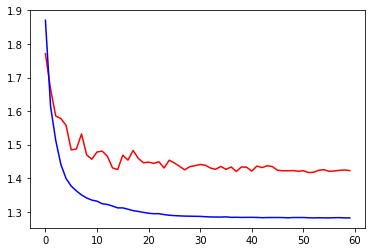

In [15]:
hparams.learning_rate= 3.2*1e-3
train_loader, valid_loader, test_loader = get_dataloader(hparams)
runner = Runner(hparams)
val_loss_ls =[]
train_loss_ls =[]

print('Training on ' + device_name(hparams.device))
for epoch in range(hparams.num_epochs):
    train_loss, train_acc = runner.run(train_loader, 'train')
    valid_loss, valid_acc = runner.run(valid_loader, 'eval')
    if((epoch+1)%10==0):
        print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
              (epoch + 1, hparams.num_epochs, train_loss, train_acc, valid_loss, valid_acc))

    val_loss_ls.append(valid_loss)
    train_loss_ls.append(train_loss)

    if runner.early_stop(valid_loss, epoch + 1):
        break

test_loss, test_acc = runner.run(test_loader, 'eval')
print("Training Finished")
print("Test Accuracy: %.2f%%" % (100*test_acc))

plt.plot(val_loss_ls,'r')
plt.plot(train_loss_ls,'b')
plt.show()

In [16]:
torch.save(runner.model.state_dict(),'./model_03')

0.8469
Normalized confusion matrix


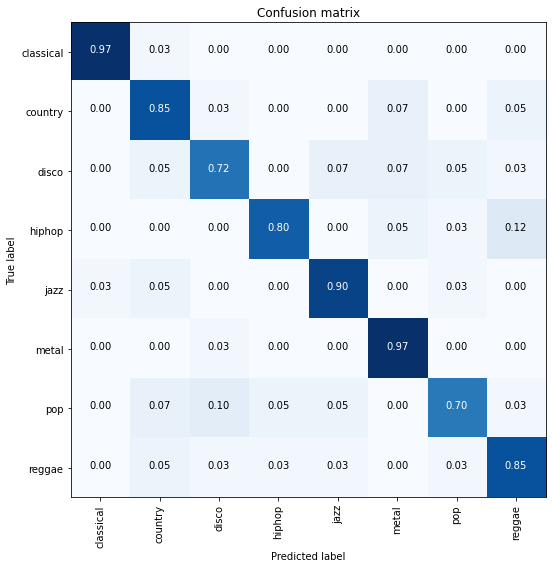

In [51]:
draw_cm('./model_03', True)

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3264] [Train Acc: 0.9530] [Valid Loss: 1.5042] [Valid Acc: 0.7812]
Epoch    11: reducing learning rate of group 0 to 2.8000e-03.
[Epoch 20/60] [Train Loss: 1.2955] [Train Acc: 0.9806] [Valid Loss: 1.4630] [Valid Acc: 0.8125]
Epoch    22: reducing learning rate of group 0 to 1.9600e-03.
[Epoch 30/60] [Train Loss: 1.2863] [Train Acc: 0.9898] [Valid Loss: 1.4333] [Valid Acc: 0.8375]
Epoch    31: reducing learning rate of group 0 to 1.3720e-03.
[Epoch 40/60] [Train Loss: 1.2806] [Train Acc: 0.9949] [Valid Loss: 1.4311] [Valid Acc: 0.8500]
Epoch    42: reducing learning rate of group 0 to 9.6040e-04.
[Epoch 50/60] [Train Loss: 1.2799] [Train Acc: 0.9951] [Valid Loss: 1.4220] [Valid Acc: 0.8562]
Epoch    50: reducing learning rate of group 0 to 6.7228e-04.
Epoch    54: reducing learning rate of group 0 to 4.7060e-04.
Epoch    58: reducing learning rate of group 0 to 3.2942e-04.
[Epoch 60/60] [Train Loss: 1.2788] [Train Acc: 0.9959] [Valid Loss: 

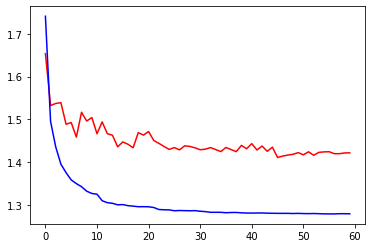

In [13]:
hparams.learning_rate= 4*1e-3
train_loader, valid_loader, test_loader = get_dataloader(hparams)
runner = Runner(hparams)
val_loss_ls =[]
train_loss_ls =[]

print('Training on ' + device_name(hparams.device))
for epoch in range(hparams.num_epochs):
    train_loss, train_acc = runner.run(train_loader, 'train')
    valid_loss, valid_acc = runner.run(valid_loader, 'eval')
    if((epoch+1)%10==0):
        print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
              (epoch + 1, hparams.num_epochs, train_loss, train_acc, valid_loss, valid_acc))

    val_loss_ls.append(valid_loss)
    train_loss_ls.append(train_loss)

    if runner.early_stop(valid_loss, epoch + 1):
        break

test_loss, test_acc = runner.run(test_loader, 'eval')
print("Training Finished")
print("Test Accuracy: %.2f%%" % (100*test_acc))

plt.plot(val_loss_ls,'r')
plt.plot(train_loss_ls,'b')
plt.show()

In [13]:
torch.save(runner.model.state_dict(),'./model_01')

In [ ]:
hparams.learning_rate= 3*1e-3
runner = Runner(hparams)
val_loss_ls =[]
train_loss_ls =[]

print('Training on ' + device_name(hparams.device))
for epoch in range(hparams.num_epochs):
    train_loss, train_acc = runner.run(train_loader, 'train')
    valid_loss, valid_acc = runner.run(valid_loader, 'eval')
    if((epoch+1)%10==0):
        print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
              (epoch + 1, hparams.num_epochs, train_loss, train_acc, valid_loss, valid_acc))

    val_loss_ls.append(valid_loss)
    train_loss_ls.append(train_loss)

    if runner.early_stop(valid_loss, epoch + 1):
        break

test_loss, test_acc = runner.run(test_loader, 'eval')
print("Training Finished")
print("Test Accuracy: %.2f%%" % (100*test_acc))

plt.plot(val_loss_ls,'r')
plt.plot(train_loss_ls,'b')
plt.show()

In [11]:
train_loader, valid_loader, test_loader = get_dataloader(hparams)

0.8562
Normalized confusion matrix


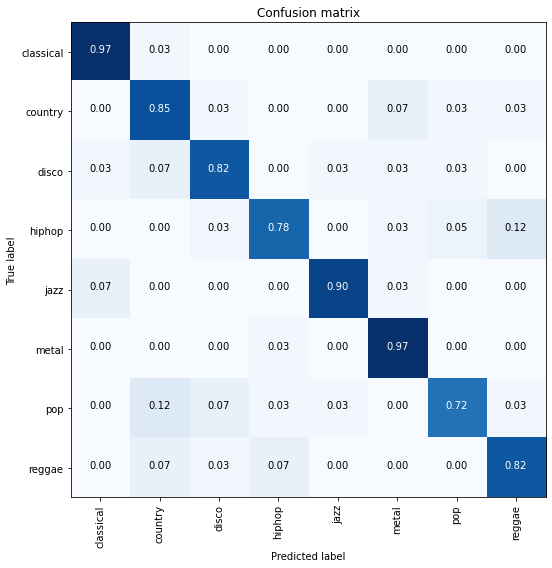

In [50]:
draw_cm('./model_00(85.62)')

## Best

In [21]:
hparams.feature_path = 'feature6'

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3381] [Train Acc: 0.9453] [Valid Loss: 1.4704] [Valid Acc: 0.8063]
Epoch    13: reducing learning rate of group 0 to 2.8000e-03.
Epoch    18: reducing learning rate of group 0 to 1.9600e-03.
[Epoch 20/60] [Train Loss: 1.2935] [Train Acc: 0.9840] [Valid Loss: 1.4405] [Valid Acc: 0.8187]
Epoch    25: reducing learning rate of group 0 to 1.3720e-03.
Epoch    29: reducing learning rate of group 0 to 9.6040e-04.
[Epoch 30/60] [Train Loss: 1.2855] [Train Acc: 0.9910] [Valid Loss: 1.4351] [Valid Acc: 0.8500]
Epoch    38: reducing learning rate of group 0 to 6.7228e-04.
[Epoch 40/60] [Train Loss: 1.2839] [Train Acc: 0.9919] [Valid Loss: 1.4398] [Valid Acc: 0.8250]
Epoch    46: reducing learning rate of group 0 to 4.7060e-04.
[Epoch 50/60] [Train Loss: 1.2822] [Train Acc: 0.9935] [Valid Loss: 1.4411] [Valid Acc: 0.8313]
Epoch    50: reducing learning rate of group 0 to 3.2942e-04.
Epoch    54: reducing learning rate of group 0 to 2.3059e-04.
Epoch 

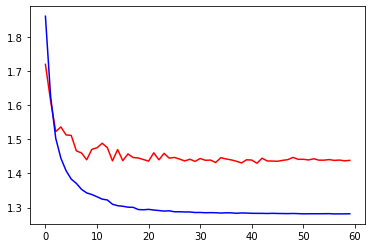

In [22]:
hparams.learning_rate= 4*1e-3
train_loader, valid_loader, test_loader = get_dataloader(hparams)
runner = Runner(hparams)
val_loss_ls =[]
train_loss_ls =[]

print('Training on ' + device_name(hparams.device))
for epoch in range(hparams.num_epochs):
    train_loss, train_acc = runner.run(train_loader, 'train')
    valid_loss, valid_acc = runner.run(valid_loader, 'eval')
    if((epoch+1)%10==0):
        print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
              (epoch + 1, hparams.num_epochs, train_loss, train_acc, valid_loss, valid_acc))

    val_loss_ls.append(valid_loss)
    train_loss_ls.append(train_loss)

    if runner.early_stop(valid_loss, epoch + 1):
        break

test_loss, test_acc = runner.run(test_loader, 'eval')
print("Training Finished")
print("Test Accuracy: %.2f%%" % (100*test_acc))

plt.plot(val_loss_ls,'r')
plt.plot(train_loss_ls,'b')
plt.show()

In [23]:
torch.save(runner.model.state_dict(),'./model_04(f6)')

0.8625
Normalized confusion matrix


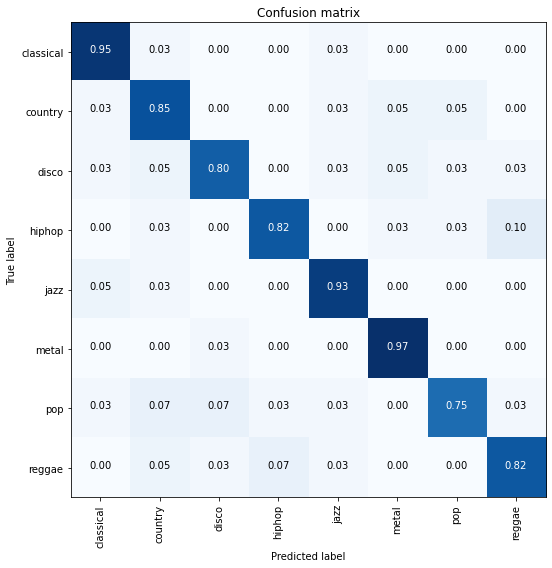

In [49]:
draw_cm('./model_04(f6)')

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3567] [Train Acc: 0.9349] [Valid Loss: 1.4919] [Valid Acc: 0.7875]
[Epoch 20/60] [Train Loss: 1.2984] [Train Acc: 0.9808] [Valid Loss: 1.4565] [Valid Acc: 0.8313]
Epoch    21: reducing learning rate of group 0 to 2.1700e-03.
Epoch    27: reducing learning rate of group 0 to 1.5190e-03.
[Epoch 30/60] [Train Loss: 1.2820] [Train Acc: 0.9937] [Valid Loss: 1.4175] [Valid Acc: 0.8688]
Epoch    31: reducing learning rate of group 0 to 1.0633e-03.
Epoch    35: reducing learning rate of group 0 to 7.4431e-04.
Epoch    39: reducing learning rate of group 0 to 5.2102e-04.
[Epoch 40/60] [Train Loss: 1.2799] [Train Acc: 0.9953] [Valid Loss: 1.4242] [Valid Acc: 0.8500]
Epoch    43: reducing learning rate of group 0 to 3.6471e-04.
Epoch    47: reducing learning rate of group 0 to 2.5530e-04.
[Epoch 50/60] [Train Loss: 1.2790] [Train Acc: 0.9959] [Valid Loss: 1.4248] [Valid Acc: 0.8500]
Epoch    51: reducing learning rate of group 0 to 1.7871e-04.
Epoch 

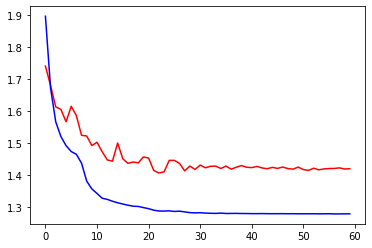

In [27]:
hparams.learning_rate= 3.1*1e-3
# train_loader, valid_loader, test_loader = get_dataloader(hparams)
runner = Runner(hparams)
val_loss_ls =[]
train_loss_ls =[]

print('Training on ' + device_name(hparams.device))
for epoch in range(hparams.num_epochs):
    train_loss, train_acc = runner.run(train_loader, 'train')
    valid_loss, valid_acc = runner.run(valid_loader, 'eval')
    if((epoch+1)%10==0):
        print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
              (epoch + 1, hparams.num_epochs, train_loss, train_acc, valid_loss, valid_acc))

    val_loss_ls.append(valid_loss)
    train_loss_ls.append(train_loss)

    if runner.early_stop(valid_loss, epoch + 1):
        break

test_loss, test_acc = runner.run(test_loader, 'eval')
print("Training Finished")
print("Test Accuracy: %.2f%%" % (100*test_acc))

plt.plot(val_loss_ls,'r')
plt.plot(train_loss_ls,'b')
plt.show()

In [28]:
torch.save(runner.model.state_dict(),'./model_05(f6)')

0.866
Normalized confusion matrix


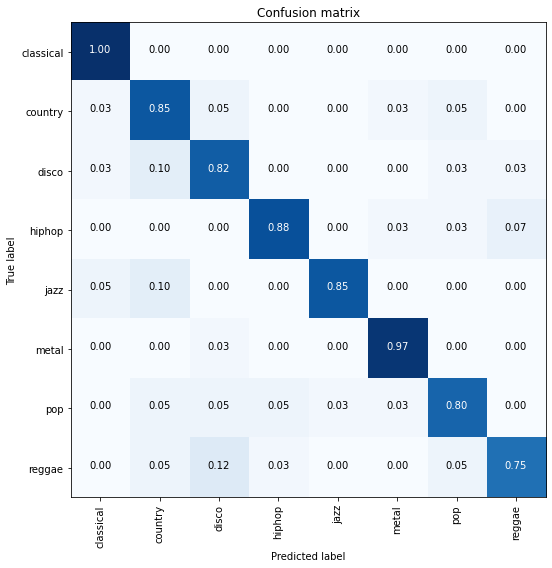

In [47]:
draw_cm('./model_05(f6)', True)

In [33]:
hparams.feature_path = 'feature6'
train_loader, valid_loader, test_loader = get_dataloader(hparams)

0.87187
Normalized confusion matrix


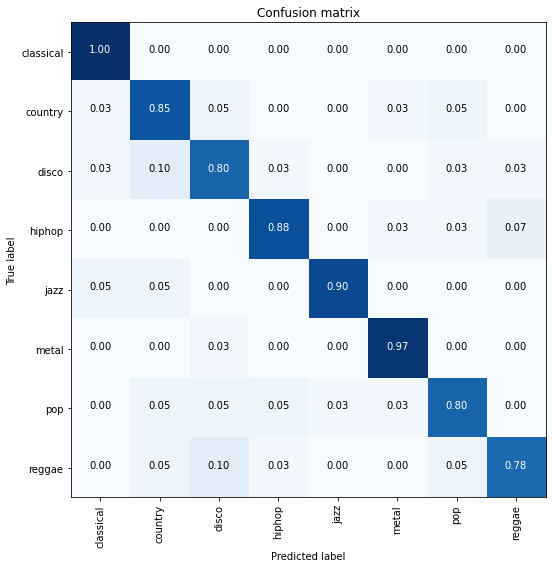

In [34]:
draw_cm('./test Model/model_05(f6)', True)

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3246] [Train Acc: 0.9558] [Valid Loss: 1.4739] [Valid Acc: 0.8063]
Epoch    17: reducing learning rate of group 0 to 1.9600e-03.
[Epoch 20/60] [Train Loss: 1.2881] [Train Acc: 0.9892] [Valid Loss: 1.4743] [Valid Acc: 0.7937]
Epoch    21: reducing learning rate of group 0 to 1.3720e-03.
Epoch    25: reducing learning rate of group 0 to 9.6040e-04.
Epoch    29: reducing learning rate of group 0 to 6.7228e-04.
[Epoch 30/60] [Train Loss: 1.2802] [Train Acc: 0.9953] [Valid Loss: 1.4491] [Valid Acc: 0.8250]
Epoch    36: reducing learning rate of group 0 to 4.7060e-04.
[Epoch 40/60] [Train Loss: 1.2786] [Train Acc: 0.9968] [Valid Loss: 1.4600] [Valid Acc: 0.8125]
Epoch    42: reducing learning rate of group 0 to 3.2942e-04.
Epoch    49: reducing learning rate of group 0 to 2.3059e-04.
[Epoch 50/60] [Train Loss: 1.2785] [Train Acc: 0.9965] [Valid Loss: 1.4489] [Valid Acc: 0.8187]
Epoch    53: reducing learning rate of group 0 to 1.6141e-04.
Epoch 

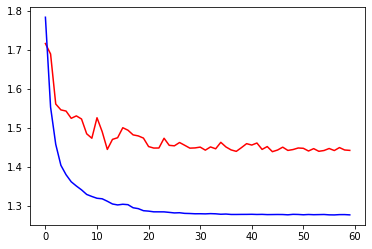

In [52]:
hparams.batch_size = 30
hparams.learning_rate= 2.8*1e-3
# train_loader, valid_loader, test_loader = get_dataloader(hparams)
runner = Runner(hparams)
val_loss_ls =[]
train_loss_ls =[]

print('Training on ' + device_name(hparams.device))
for epoch in range(hparams.num_epochs):
    train_loss, train_acc = runner.run(train_loader, 'train')
    valid_loss, valid_acc = runner.run(valid_loader, 'eval')
    if((epoch+1)%10==0):
        print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
              (epoch + 1, hparams.num_epochs, train_loss, train_acc, valid_loss, valid_acc))

    val_loss_ls.append(valid_loss)
    train_loss_ls.append(train_loss)

    if runner.early_stop(valid_loss, epoch + 1):
        break

test_loss, test_acc = runner.run(test_loader, 'eval')
print("Training Finished")
print("Test Accuracy: %.2f%%" % (100*test_acc))

plt.plot(val_loss_ls,'r')
plt.plot(train_loss_ls,'b')
plt.show()

In [53]:
torch.save(runner.model.state_dict(),'./model_06(f6)')

0.8375
Normalized confusion matrix


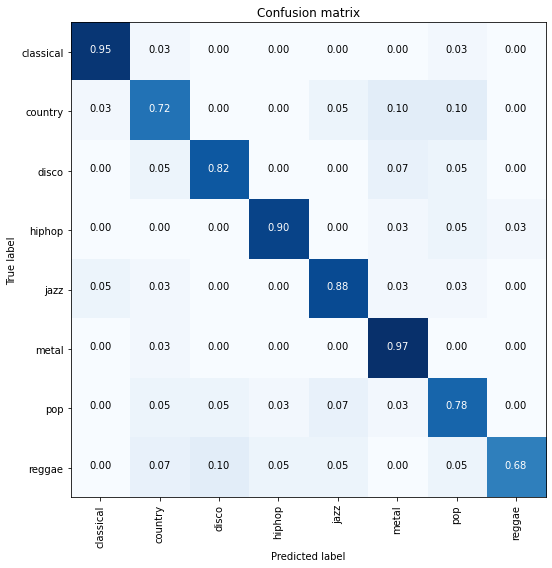

In [54]:
draw_cm('./model_06(f6)', True)

Training on GPU:0
Epoch     8: reducing learning rate of group 0 to 2.1000e-03.
[Epoch 10/70] [Train Loss: 1.3168] [Train Acc: 0.9645] [Valid Loss: 1.4817] [Valid Acc: 0.7937]
Epoch    19: reducing learning rate of group 0 to 1.4700e-03.
[Epoch 20/70] [Train Loss: 1.2952] [Train Acc: 0.9822] [Valid Loss: 1.4412] [Valid Acc: 0.8313]
Epoch    29: reducing learning rate of group 0 to 1.0290e-03.
[Epoch 30/70] [Train Loss: 1.2859] [Train Acc: 0.9899] [Valid Loss: 1.4296] [Valid Acc: 0.8562]
Epoch    35: reducing learning rate of group 0 to 7.2030e-04.
Epoch    39: reducing learning rate of group 0 to 5.0421e-04.
[Epoch 40/70] [Train Loss: 1.2829] [Train Acc: 0.9925] [Valid Loss: 1.4243] [Valid Acc: 0.8500]
Epoch    43: reducing learning rate of group 0 to 3.5295e-04.
Epoch    47: reducing learning rate of group 0 to 2.4706e-04.
[Epoch 50/70] [Train Loss: 1.2814] [Train Acc: 0.9941] [Valid Loss: 1.4394] [Valid Acc: 0.8250]
Epoch    51: reducing learning rate of group 0 to 1.7294e-04.
Epoch 

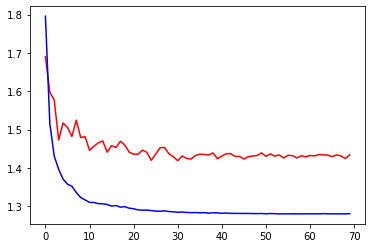

In [66]:
hparams.num_epochs = 70
hparams.learning_rate= 3*1e-3
hparams.batch_size = 30
# train_loader, valid_loader, test_loader = get_dataloader(hparams)
runner = Runner(hparams)
val_loss_ls =[]
train_loss_ls =[]

print('Training on ' + device_name(hparams.device))
for epoch in range(hparams.num_epochs):
    train_loss, train_acc = runner.run(train_loader, 'train')
    valid_loss, valid_acc = runner.run(valid_loader, 'eval')
    if((epoch+1)%10==0):
        print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
              (epoch + 1, hparams.num_epochs, train_loss, train_acc, valid_loss, valid_acc))

    val_loss_ls.append(valid_loss)
    train_loss_ls.append(train_loss)

    if runner.early_stop(valid_loss, epoch + 1):
        break

test_loss, test_acc = runner.run(test_loader, 'eval')
print("Training Finished")
print("Test Accuracy: %.2f%%" % (100*test_acc))

plt.plot(val_loss_ls,'r')
plt.plot(train_loss_ls,'b')
plt.show()

In [67]:
torch.save(runner.model.state_dict(),'./model_09')

0.8438
Normalized confusion matrix


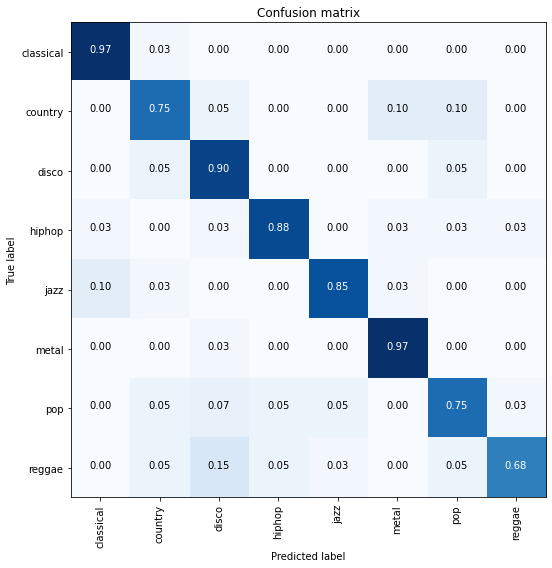

In [68]:
draw_cm('./model_09', True)

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3336] [Train Acc: 0.9486] [Valid Loss: 1.4739] [Valid Acc: 0.8187]
[Epoch 20/70] [Train Loss: 1.3052] [Train Acc: 0.9730] [Valid Loss: 1.4833] [Valid Acc: 0.7812]
Epoch    22: reducing learning rate of group 0 to 1.4000e-03.
Epoch    26: reducing learning rate of group 0 to 9.8000e-04.
[Epoch 30/70] [Train Loss: 1.2880] [Train Acc: 0.9880] [Valid Loss: 1.4541] [Valid Acc: 0.8125]
Epoch    30: reducing learning rate of group 0 to 6.8600e-04.
Epoch    34: reducing learning rate of group 0 to 4.8020e-04.
Epoch    38: reducing learning rate of group 0 to 3.3614e-04.
[Epoch 40/70] [Train Loss: 1.2830] [Train Acc: 0.9929] [Valid Loss: 1.4354] [Valid Acc: 0.8250]
Epoch    42: reducing learning rate of group 0 to 2.3530e-04.
Epoch    46: reducing learning rate of group 0 to 1.6471e-04.
[Epoch 50/70] [Train Loss: 1.2811] [Train Acc: 0.9946] [Valid Loss: 1.4333] [Valid Acc: 0.8438]
Epoch    53: reducing learning rate of group 0 to 1.1530e-04.
Epoch 

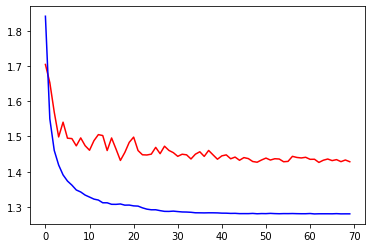

In [69]:
hparams.num_epochs = 70
hparams.learning_rate= 2*1e-3
hparams.batch_size = 10
# train_loader, valid_loader, test_loader = get_dataloader(hparams)
runner = Runner(hparams)
val_loss_ls =[]
train_loss_ls =[]

print('Training on ' + device_name(hparams.device))
for epoch in range(hparams.num_epochs):
    train_loss, train_acc = runner.run(train_loader, 'train')
    valid_loss, valid_acc = runner.run(valid_loader, 'eval')
    if((epoch+1)%10==0):
        print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
              (epoch + 1, hparams.num_epochs, train_loss, train_acc, valid_loss, valid_acc))

    val_loss_ls.append(valid_loss)
    train_loss_ls.append(train_loss)

    if runner.early_stop(valid_loss, epoch + 1):
        break

test_loss, test_acc = runner.run(test_loader, 'eval')
print("Training Finished")
print("Test Accuracy: %.2f%%" % (100*test_acc))

plt.plot(val_loss_ls,'r')
plt.plot(train_loss_ls,'b')
plt.show()

In [71]:
torch.save(runner.model.state_dict(),'./model_10')

0.8313
Normalized confusion matrix


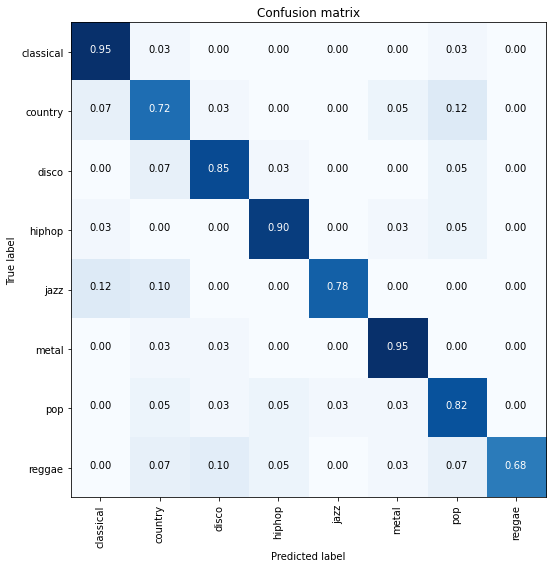

In [72]:
draw_cm('./model_10', True)

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3252] [Train Acc: 0.9534] [Valid Loss: 1.5235] [Valid Acc: 0.7562]
Epoch    11: reducing learning rate of group 0 to 2.9400e-03.
[Epoch 20/70] [Train Loss: 1.2955] [Train Acc: 0.9806] [Valid Loss: 1.4516] [Valid Acc: 0.8375]
Epoch    24: reducing learning rate of group 0 to 2.0580e-03.
Epoch    28: reducing learning rate of group 0 to 1.4406e-03.
[Epoch 30/70] [Train Loss: 1.2817] [Train Acc: 0.9936] [Valid Loss: 1.5007] [Valid Acc: 0.7750]
Epoch    32: reducing learning rate of group 0 to 1.0084e-03.
Epoch    36: reducing learning rate of group 0 to 7.0589e-04.
[Epoch 40/70] [Train Loss: 1.2796] [Train Acc: 0.9950] [Valid Loss: 1.4727] [Valid Acc: 0.7875]
Epoch    40: reducing learning rate of group 0 to 4.9413e-04.
Epoch    44: reducing learning rate of group 0 to 3.4589e-04.
Epoch    48: reducing learning rate of group 0 to 2.4212e-04.
[Epoch 50/70] [Train Loss: 1.2781] [Train Acc: 0.9965] [Valid Loss: 1.4726] [Valid Acc: 0.8000]
Epoch 

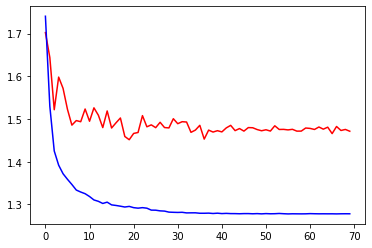

In [77]:
hparams.num_epochs = 70
hparams.learning_rate= 4.2*1e-3
hparams.batch_size = 30
# train_loader, valid_loader, test_loader = get_dataloader(hparams)
runner = Runner(hparams)
val_loss_ls =[]
train_loss_ls =[]

print('Training on ' + device_name(hparams.device))
for epoch in range(hparams.num_epochs):
    train_loss, train_acc = runner.run(train_loader, 'train')
    valid_loss, valid_acc = runner.run(valid_loader, 'eval')
    if((epoch+1)%10==0):
        print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
              (epoch + 1, hparams.num_epochs, train_loss, train_acc, valid_loss, valid_acc))

    val_loss_ls.append(valid_loss)
    train_loss_ls.append(train_loss)

    if runner.early_stop(valid_loss, epoch + 1):
        break

test_loss, test_acc = runner.run(test_loader, 'eval')
print("Training Finished")
print("Test Accuracy: %.2f%%" % (100*test_acc))

plt.plot(val_loss_ls,'r')
plt.plot(train_loss_ls,'b')
plt.show()

0.7969
Normalized confusion matrix


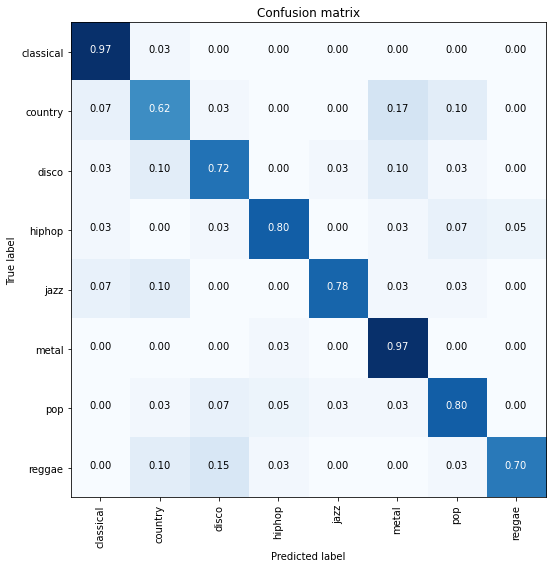

In [78]:
torch.save(runner.model.state_dict(),'./model_11')
draw_cm('./model_11', True)

In [10]:
def run(lr, epochs, batch_size):
    hparams.num_epochs =epochs
    hparams.learning_rate=lr
    hparams.batch_size = batch_size
    # train_loader, valid_loader, test_loader = get_dataloader(hparams)
    runner = Runner(hparams)
    val_loss_ls =[]
    train_loss_ls =[]

    print('Training on ' + device_name(hparams.device))
    for epoch in range(hparams.num_epochs):
        train_loss, train_acc = runner.run(train_loader, 'train')
        valid_loss, valid_acc = runner.run(valid_loader, 'eval')
        if((epoch+1)%10==0):
            print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
                  (epoch + 1, hparams.num_epochs, train_loss, train_acc, valid_loss, valid_acc))

        val_loss_ls.append(valid_loss)
        train_loss_ls.append(train_loss)

        if runner.early_stop(valid_loss, epoch + 1):
            break

    test_loss, test_acc = runner.run(test_loader, 'eval')
    print("Training Finished")
    print("Test Accuracy: %.2f%%" % (100*test_acc))

    plt.plot(val_loss_ls,'r')
    plt.plot(train_loss_ls,'b')
    plt.show()
    
    path ='./model_'+str(lr)+'_'+str(epochs)+'_'+str(batch_size)
    torch.save(runner.model.state_dict(),path)
    draw_cm(path, True)
    
    return test_acc, path
    

In [80]:

lrs = [2.0,2.4,2.8,3.0, 3.2, 3.4, 3.6, 3.8, 4.0,4.2,4.4 ]
lrs = [i * 1e-3 for i in lrs] +[i*1e-2 for i in lrs]+[i*1e-4 for i in lrs] 

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3402] [Train Acc: 0.9435] [Valid Loss: 1.4679] [Valid Acc: 0.8250]
[Epoch 20/60] [Train Loss: 1.3032] [Train Acc: 0.9762] [Valid Loss: 1.4376] [Valid Acc: 0.8500]
Epoch    24: reducing learning rate of group 0 to 1.4000e-03.
Epoch    29: reducing learning rate of group 0 to 9.8000e-04.
[Epoch 30/60] [Train Loss: 1.2855] [Train Acc: 0.9910] [Valid Loss: 1.4609] [Valid Acc: 0.8187]
Epoch    36: reducing learning rate of group 0 to 6.8600e-04.
[Epoch 40/60] [Train Loss: 1.2802] [Train Acc: 0.9957] [Valid Loss: 1.4355] [Valid Acc: 0.8438]
Epoch    40: reducing learning rate of group 0 to 4.8020e-04.
Epoch    44: reducing learning rate of group 0 to 3.3614e-04.
Epoch    48: reducing learning rate of group 0 to 2.3530e-04.
[Epoch 50/60] [Train Loss: 1.2783] [Train Acc: 0.9970] [Valid Loss: 1.4374] [Valid Acc: 0.8375]
Epoch    52: reducing learning rate of group 0 to 1.6471e-04.
Epoch    56: reducing learning rate of group 0 to 1.1530e-04.
[Epoch

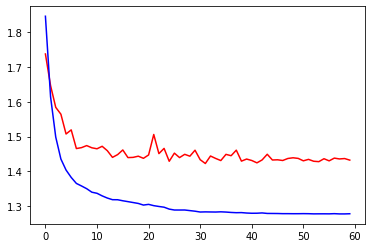

0.8375
Normalized confusion matrix


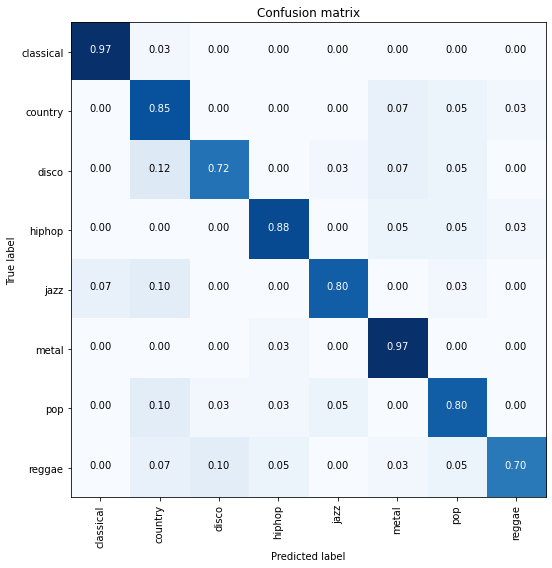

Training on GPU:0
Epoch     8: reducing learning rate of group 0 to 1.6800e-03.
[Epoch 10/60] [Train Loss: 1.3190] [Train Acc: 0.9635] [Valid Loss: 1.4656] [Valid Acc: 0.8187]
Epoch    14: reducing learning rate of group 0 to 1.1760e-03.
[Epoch 20/60] [Train Loss: 1.2942] [Train Acc: 0.9846] [Valid Loss: 1.4742] [Valid Acc: 0.8063]
Epoch    20: reducing learning rate of group 0 to 8.2320e-04.
Epoch    26: reducing learning rate of group 0 to 5.7624e-04.
[Epoch 30/60] [Train Loss: 1.2853] [Train Acc: 0.9913] [Valid Loss: 1.4619] [Valid Acc: 0.8187]
Epoch    30: reducing learning rate of group 0 to 4.0337e-04.
Epoch    37: reducing learning rate of group 0 to 2.8236e-04.
[Epoch 40/60] [Train Loss: 1.2820] [Train Acc: 0.9944] [Valid Loss: 1.4770] [Valid Acc: 0.8000]
Epoch    41: reducing learning rate of group 0 to 1.9765e-04.
Epoch    45: reducing learning rate of group 0 to 1.3836e-04.
Epoch    49: reducing learning rate of group 0 to 9.6849e-05.
[Epoch 50/60] [Train Loss: 1.2812] [Trai

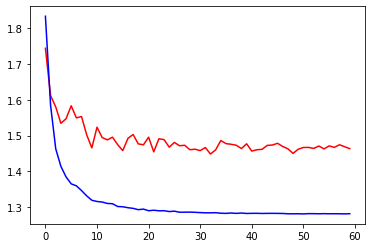

0.825
Normalized confusion matrix


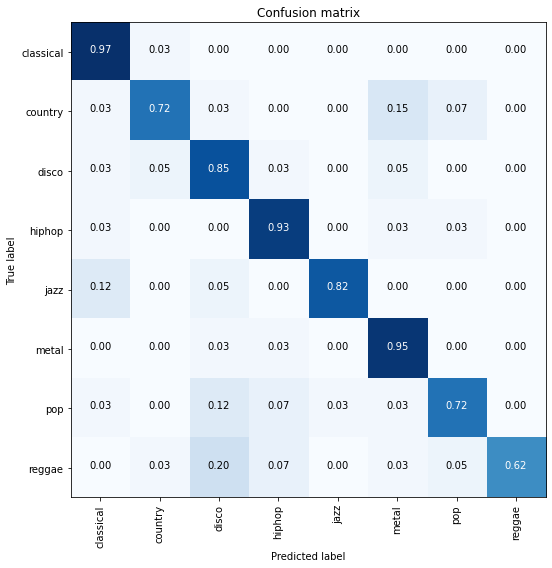

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3285] [Train Acc: 0.9532] [Valid Loss: 1.4574] [Valid Acc: 0.8313]
Epoch    18: reducing learning rate of group 0 to 1.9600e-03.
[Epoch 20/60] [Train Loss: 1.2944] [Train Acc: 0.9816] [Valid Loss: 1.4543] [Valid Acc: 0.8187]
Epoch    27: reducing learning rate of group 0 to 1.3720e-03.
[Epoch 30/60] [Train Loss: 1.2840] [Train Acc: 0.9917] [Valid Loss: 1.4314] [Valid Acc: 0.8313]
Epoch    31: reducing learning rate of group 0 to 9.6040e-04.
Epoch    37: reducing learning rate of group 0 to 6.7228e-04.
[Epoch 40/60] [Train Loss: 1.2817] [Train Acc: 0.9932] [Valid Loss: 1.4396] [Valid Acc: 0.8313]
Epoch    41: reducing learning rate of group 0 to 4.7060e-04.
Epoch    45: reducing learning rate of group 0 to 3.2942e-04.
Epoch    49: reducing learning rate of group 0 to 2.3059e-04.
[Epoch 50/60] [Train Loss: 1.2795] [Train Acc: 0.9954] [Valid Loss: 1.4352] [Valid Acc: 0.8313]
Epoch    53: reducing learning rate of group 0 to 1.6141e-04.
[Epoch

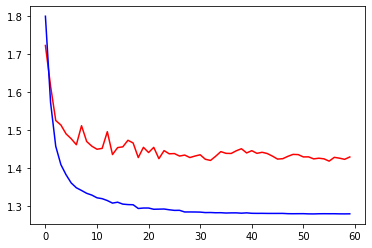

0.8406
Normalized confusion matrix


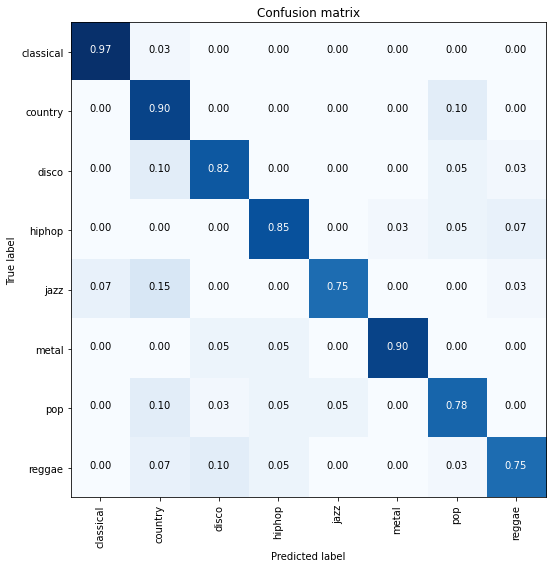

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3256] [Train Acc: 0.9559] [Valid Loss: 1.4568] [Valid Acc: 0.8250]
Epoch    12: reducing learning rate of group 0 to 2.1000e-03.
Epoch    18: reducing learning rate of group 0 to 1.4700e-03.
[Epoch 20/60] [Train Loss: 1.2924] [Train Acc: 0.9851] [Valid Loss: 1.4493] [Valid Acc: 0.8250]
Epoch    25: reducing learning rate of group 0 to 1.0290e-03.
Epoch    29: reducing learning rate of group 0 to 7.2030e-04.
[Epoch 30/60] [Train Loss: 1.2848] [Train Acc: 0.9916] [Valid Loss: 1.4253] [Valid Acc: 0.8438]
Epoch    33: reducing learning rate of group 0 to 5.0421e-04.
Epoch    37: reducing learning rate of group 0 to 3.5295e-04.
[Epoch 40/60] [Train Loss: 1.2826] [Train Acc: 0.9925] [Valid Loss: 1.4264] [Valid Acc: 0.8625]
Epoch    41: reducing learning rate of group 0 to 2.4706e-04.
Epoch    45: reducing learning rate of group 0 to 1.7294e-04.
Epoch    49: reducing learning rate of group 0 to 1.2106e-04.
[Epoch 50/60] [Train Loss: 1.2813] [Trai

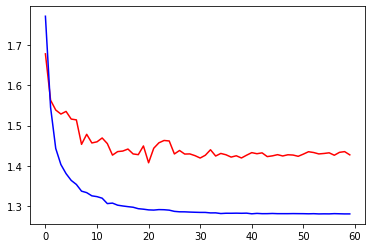

0.8469
Normalized confusion matrix


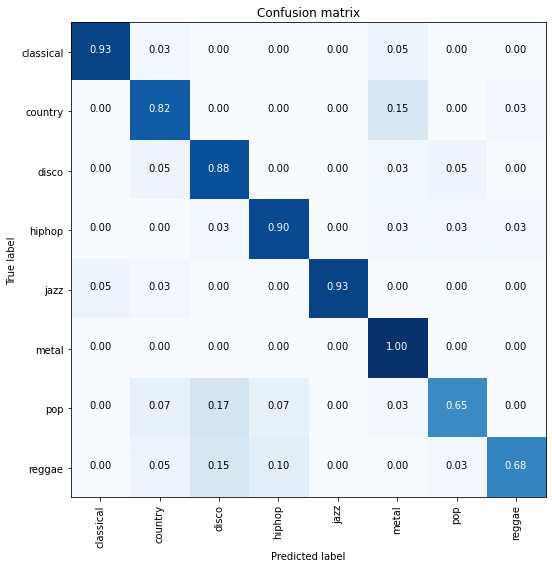

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3234] [Train Acc: 0.9583] [Valid Loss: 1.4852] [Valid Acc: 0.7688]
Epoch    13: reducing learning rate of group 0 to 2.2400e-03.
[Epoch 20/60] [Train Loss: 1.2942] [Train Acc: 0.9831] [Valid Loss: 1.4376] [Valid Acc: 0.8500]
[Epoch 30/60] [Train Loss: 1.2882] [Train Acc: 0.9882] [Valid Loss: 1.4750] [Valid Acc: 0.7875]
Epoch    33: reducing learning rate of group 0 to 1.5680e-03.
Epoch    37: reducing learning rate of group 0 to 1.0976e-03.
[Epoch 40/60] [Train Loss: 1.2795] [Train Acc: 0.9954] [Valid Loss: 1.4049] [Valid Acc: 0.8688]
Epoch    44: reducing learning rate of group 0 to 7.6832e-04.
Epoch    48: reducing learning rate of group 0 to 5.3782e-04.
[Epoch 50/60] [Train Loss: 1.2778] [Train Acc: 0.9970] [Valid Loss: 1.4232] [Valid Acc: 0.8562]
Epoch    52: reducing learning rate of group 0 to 3.7648e-04.
Epoch    56: reducing learning rate of group 0 to 2.6353e-04.
[Epoch 60/60] [Train Loss: 1.2776] [Train Acc: 0.9971] [Valid Loss: 

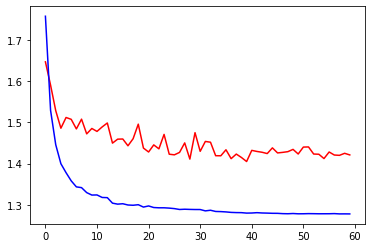

0.8344
Normalized confusion matrix


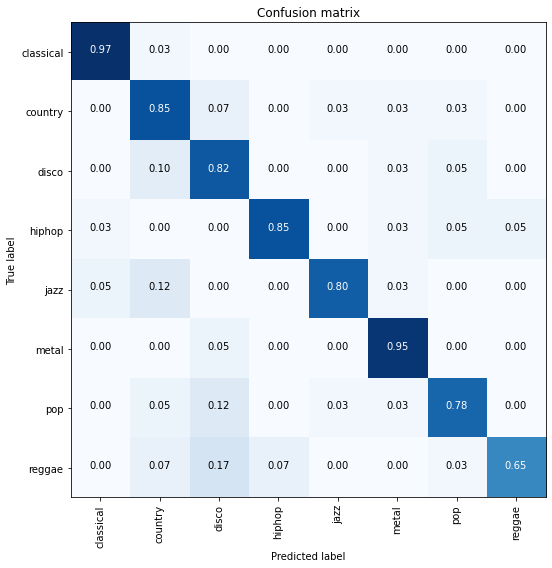

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3261] [Train Acc: 0.9536] [Valid Loss: 1.5042] [Valid Acc: 0.7688]
Epoch    10: reducing learning rate of group 0 to 2.3800e-03.
Epoch    15: reducing learning rate of group 0 to 1.6660e-03.
[Epoch 20/60] [Train Loss: 1.2908] [Train Acc: 0.9860] [Valid Loss: 1.4453] [Valid Acc: 0.8250]
Epoch    23: reducing learning rate of group 0 to 1.1662e-03.
[Epoch 30/60] [Train Loss: 1.2852] [Train Acc: 0.9912] [Valid Loss: 1.4357] [Valid Acc: 0.8438]
Epoch    30: reducing learning rate of group 0 to 8.1634e-04.
Epoch    34: reducing learning rate of group 0 to 5.7144e-04.
Epoch    38: reducing learning rate of group 0 to 4.0001e-04.
[Epoch 40/60] [Train Loss: 1.2814] [Train Acc: 0.9941] [Valid Loss: 1.4426] [Valid Acc: 0.8375]
Epoch    42: reducing learning rate of group 0 to 2.8000e-04.
Epoch    46: reducing learning rate of group 0 to 1.9600e-04.
[Epoch 50/60] [Train Loss: 1.2804] [Train Acc: 0.9951] [Valid Loss: 1.4527] [Valid Acc: 0.8187]
Epoch 

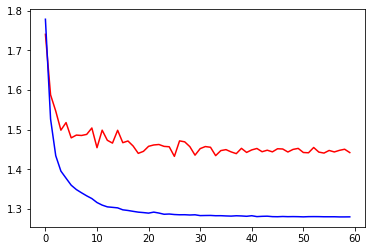

0.8344
Normalized confusion matrix


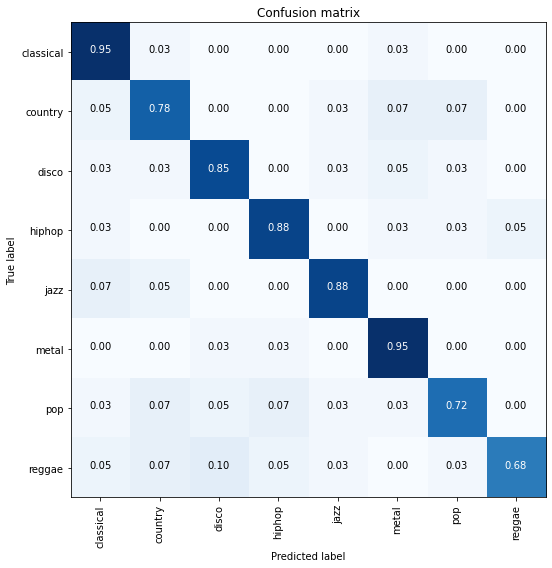

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3316] [Train Acc: 0.9480] [Valid Loss: 1.5091] [Valid Acc: 0.7688]
Epoch    18: reducing learning rate of group 0 to 2.5200e-03.
[Epoch 20/60] [Train Loss: 1.2948] [Train Acc: 0.9814] [Valid Loss: 1.4528] [Valid Acc: 0.8313]
[Epoch 30/60] [Train Loss: 1.2867] [Train Acc: 0.9896] [Valid Loss: 1.4370] [Valid Acc: 0.8375]
Epoch    31: reducing learning rate of group 0 to 1.7640e-03.
Epoch    35: reducing learning rate of group 0 to 1.2348e-03.
Epoch    39: reducing learning rate of group 0 to 8.6436e-04.
[Epoch 40/60] [Train Loss: 1.2805] [Train Acc: 0.9943] [Valid Loss: 1.4289] [Valid Acc: 0.8375]
Epoch    43: reducing learning rate of group 0 to 6.0505e-04.
Epoch    47: reducing learning rate of group 0 to 4.2354e-04.
[Epoch 50/60] [Train Loss: 1.2793] [Train Acc: 0.9954] [Valid Loss: 1.4257] [Valid Acc: 0.8500]
Epoch    51: reducing learning rate of group 0 to 2.9648e-04.
Epoch    55: reducing learning rate of group 0 to 2.0753e-04.
Epoch 

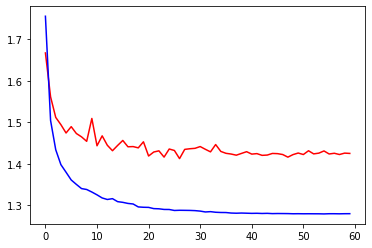

0.8594
Normalized confusion matrix


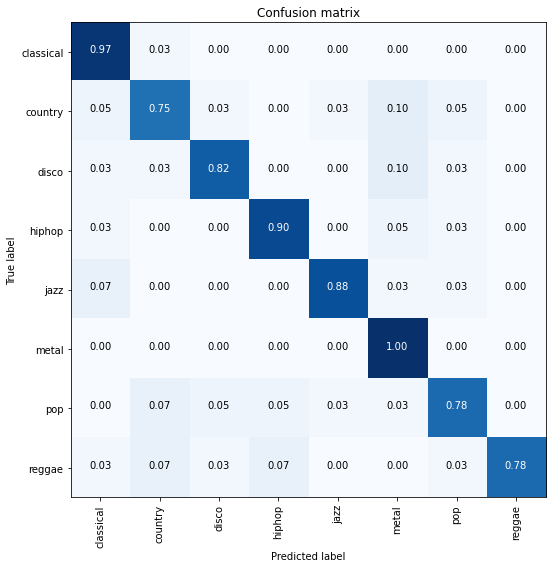

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3282] [Train Acc: 0.9517] [Valid Loss: 1.5195] [Valid Acc: 0.7688]
Epoch    15: reducing learning rate of group 0 to 2.6600e-03.
[Epoch 20/60] [Train Loss: 1.2942] [Train Acc: 0.9831] [Valid Loss: 1.4794] [Valid Acc: 0.8000]
Epoch    24: reducing learning rate of group 0 to 1.8620e-03.
[Epoch 30/60] [Train Loss: 1.2824] [Train Acc: 0.9928] [Valid Loss: 1.4741] [Valid Acc: 0.8125]
Epoch    32: reducing learning rate of group 0 to 1.3034e-03.
Epoch    39: reducing learning rate of group 0 to 9.1238e-04.
[Epoch 40/60] [Train Loss: 1.2794] [Train Acc: 0.9959] [Valid Loss: 1.4721] [Valid Acc: 0.8063]
Epoch    43: reducing learning rate of group 0 to 6.3867e-04.
Epoch    47: reducing learning rate of group 0 to 4.4707e-04.
[Epoch 50/60] [Train Loss: 1.2785] [Train Acc: 0.9963] [Valid Loss: 1.4711] [Valid Acc: 0.8125]
Epoch    51: reducing learning rate of group 0 to 3.1295e-04.
Epoch    55: reducing learning rate of group 0 to 2.1906e-04.
Epoch 

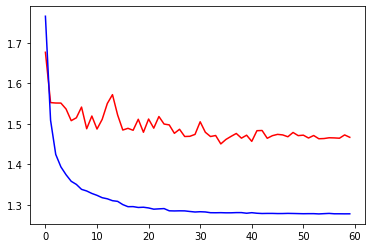

0.8063
Normalized confusion matrix


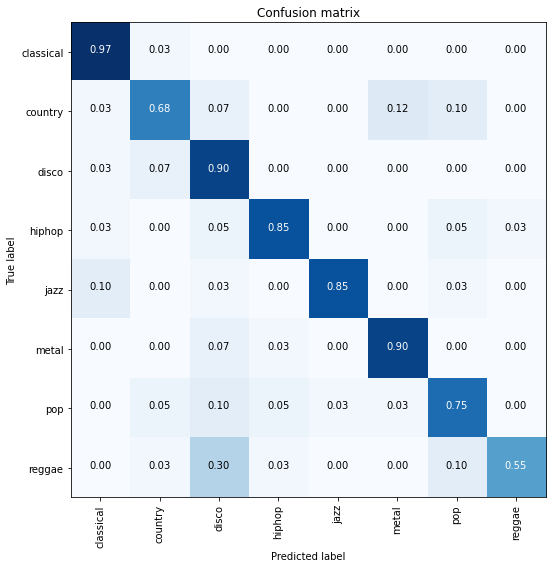

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3236] [Train Acc: 0.9543] [Valid Loss: 1.4933] [Valid Acc: 0.7812]
Epoch    12: reducing learning rate of group 0 to 2.8000e-03.
Epoch    16: reducing learning rate of group 0 to 1.9600e-03.
[Epoch 20/60] [Train Loss: 1.2897] [Train Acc: 0.9873] [Valid Loss: 1.4607] [Valid Acc: 0.8187]
[Epoch 30/60] [Train Loss: 1.2845] [Train Acc: 0.9912] [Valid Loss: 1.4572] [Valid Acc: 0.8000]
Epoch    36: reducing learning rate of group 0 to 1.3720e-03.
[Epoch 40/60] [Train Loss: 1.2801] [Train Acc: 0.9948] [Valid Loss: 1.4547] [Valid Acc: 0.8125]
Epoch    40: reducing learning rate of group 0 to 9.6040e-04.
Epoch    44: reducing learning rate of group 0 to 6.7228e-04.
Epoch    48: reducing learning rate of group 0 to 4.7060e-04.
[Epoch 50/60] [Train Loss: 1.2787] [Train Acc: 0.9961] [Valid Loss: 1.4464] [Valid Acc: 0.8250]
Epoch    52: reducing learning rate of group 0 to 3.2942e-04.
Epoch    56: reducing learning rate of group 0 to 2.3059e-04.
[Epoch

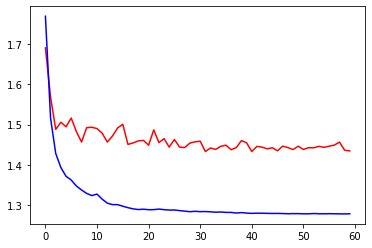

0.8313
Normalized confusion matrix


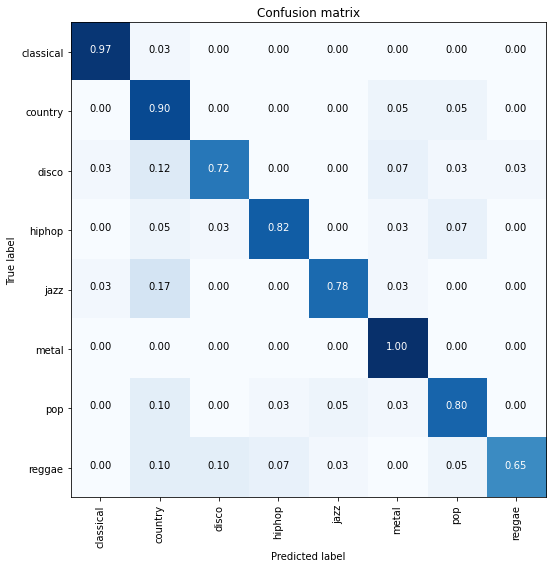

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3248] [Train Acc: 0.9536] [Valid Loss: 1.4718] [Valid Acc: 0.8063]
[Epoch 20/60] [Train Loss: 1.2955] [Train Acc: 0.9801] [Valid Loss: 1.4698] [Valid Acc: 0.7937]
Epoch    20: reducing learning rate of group 0 to 2.9400e-03.
Epoch    27: reducing learning rate of group 0 to 2.0580e-03.
[Epoch 30/60] [Train Loss: 1.2807] [Train Acc: 0.9944] [Valid Loss: 1.4474] [Valid Acc: 0.8187]
Epoch    31: reducing learning rate of group 0 to 1.4406e-03.
Epoch    35: reducing learning rate of group 0 to 1.0084e-03.
Epoch    39: reducing learning rate of group 0 to 7.0589e-04.
[Epoch 40/60] [Train Loss: 1.2785] [Train Acc: 0.9961] [Valid Loss: 1.4446] [Valid Acc: 0.8313]
Epoch    43: reducing learning rate of group 0 to 4.9413e-04.
Epoch    47: reducing learning rate of group 0 to 3.4589e-04.
[Epoch 50/60] [Train Loss: 1.2781] [Train Acc: 0.9964] [Valid Loss: 1.4365] [Valid Acc: 0.8313]
Epoch    56: reducing learning rate of group 0 to 2.4212e-04.
[Epoch

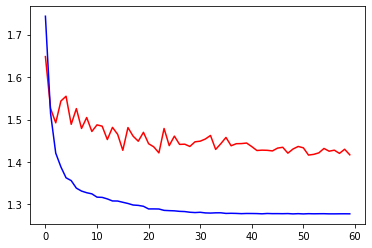

0.8438
Normalized confusion matrix


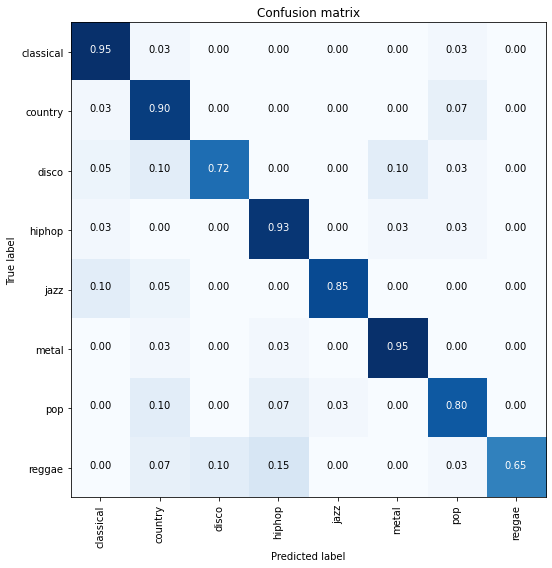

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3285] [Train Acc: 0.9508] [Valid Loss: 1.4491] [Valid Acc: 0.8375]
[Epoch 20/60] [Train Loss: 1.2996] [Train Acc: 0.9779] [Valid Loss: 1.4347] [Valid Acc: 0.8375]
Epoch    20: reducing learning rate of group 0 to 3.0800e-03.
Epoch    25: reducing learning rate of group 0 to 2.1560e-03.
Epoch    29: reducing learning rate of group 0 to 1.5092e-03.
[Epoch 30/60] [Train Loss: 1.2833] [Train Acc: 0.9919] [Valid Loss: 1.4168] [Valid Acc: 0.8625]
Epoch    34: reducing learning rate of group 0 to 1.0564e-03.
Epoch    39: reducing learning rate of group 0 to 7.3951e-04.
[Epoch 40/60] [Train Loss: 1.2809] [Train Acc: 0.9940] [Valid Loss: 1.4363] [Valid Acc: 0.8250]
Epoch    43: reducing learning rate of group 0 to 5.1766e-04.
Epoch    47: reducing learning rate of group 0 to 3.6236e-04.
[Epoch 50/60] [Train Loss: 1.2806] [Train Acc: 0.9938] [Valid Loss: 1.4343] [Valid Acc: 0.8313]
Epoch    51: reducing learning rate of group 0 to 2.5365e-04.
Epoch 

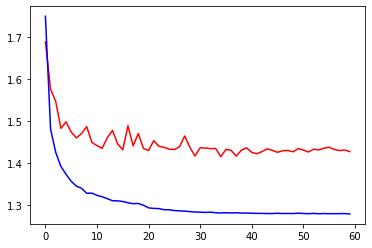

0.8469
Normalized confusion matrix


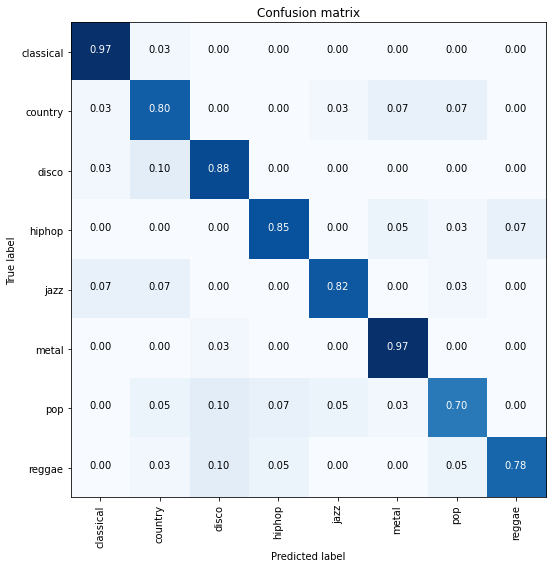

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3712] [Train Acc: 0.9028] [Valid Loss: 1.5087] [Valid Acc: 0.7688]
Epoch    10: reducing learning rate of group 0 to 1.4000e-02.
Epoch    19: reducing learning rate of group 0 to 9.8000e-03.
[Epoch 20/60] [Train Loss: 1.3109] [Train Acc: 0.9639] [Valid Loss: 1.4592] [Valid Acc: 0.8187]
Epoch    23: reducing learning rate of group 0 to 6.8600e-03.
Epoch    27: reducing learning rate of group 0 to 4.8020e-03.
[Epoch 30/60] [Train Loss: 1.2910] [Train Acc: 0.9837] [Valid Loss: 1.4490] [Valid Acc: 0.8250]
Epoch    34: reducing learning rate of group 0 to 3.3614e-03.
Epoch    38: reducing learning rate of group 0 to 2.3530e-03.
[Epoch 40/60] [Train Loss: 1.2856] [Train Acc: 0.9884] [Valid Loss: 1.4663] [Valid Acc: 0.8000]
Epoch    42: reducing learning rate of group 0 to 1.6471e-03.
Epoch    46: reducing learning rate of group 0 to 1.1530e-03.
[Epoch 50/60] [Train Loss: 1.2814] [Train Acc: 0.9931] [Valid Loss: 1.4817] [Valid Acc: 0.7812]
Epoch 

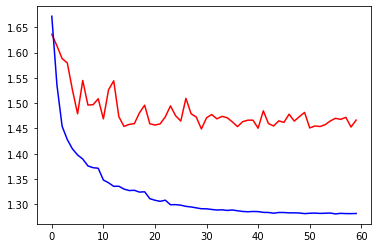

0.8156
Normalized confusion matrix


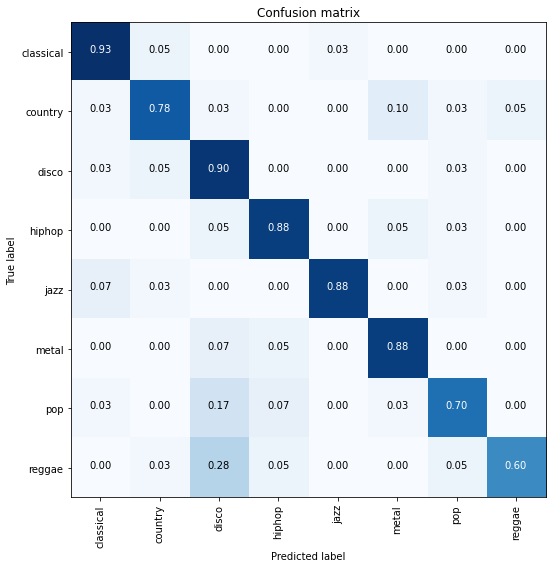

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3805] [Train Acc: 0.8934] [Valid Loss: 1.5061] [Valid Acc: 0.7625]
Epoch    16: reducing learning rate of group 0 to 1.6800e-02.
[Epoch 20/60] [Train Loss: 1.3254] [Train Acc: 0.9485] [Valid Loss: 1.4859] [Valid Acc: 0.8000]
Epoch    20: reducing learning rate of group 0 to 1.1760e-02.
Epoch    24: reducing learning rate of group 0 to 8.2320e-03.
Epoch    28: reducing learning rate of group 0 to 5.7624e-03.
[Epoch 30/60] [Train Loss: 1.3022] [Train Acc: 0.9714] [Valid Loss: 1.5407] [Valid Acc: 0.7312]
Epoch    32: reducing learning rate of group 0 to 4.0337e-03.
Epoch    36: reducing learning rate of group 0 to 2.8236e-03.
[Epoch 40/60] [Train Loss: 1.2962] [Train Acc: 0.9779] [Valid Loss: 1.5249] [Valid Acc: 0.7500]
Epoch    40: reducing learning rate of group 0 to 1.9765e-03.
Epoch    44: reducing learning rate of group 0 to 1.3836e-03.
Epoch    48: reducing learning rate of group 0 to 9.6849e-04.
[Epoch 50/60] [Train Loss: 1.2934] [Trai

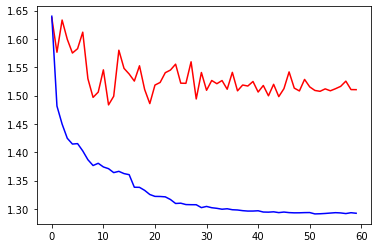

0.7781
Normalized confusion matrix


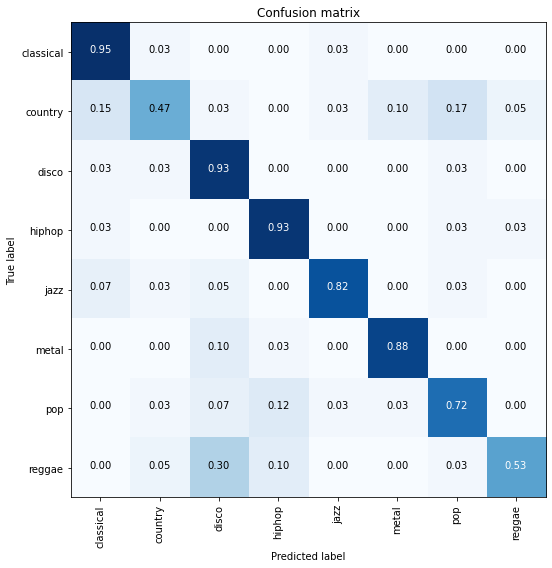

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3947] [Train Acc: 0.8792] [Valid Loss: 1.4998] [Valid Acc: 0.7688]
Epoch    11: reducing learning rate of group 0 to 1.9600e-02.
[Epoch 20/60] [Train Loss: 1.3349] [Train Acc: 0.9383] [Valid Loss: 1.4801] [Valid Acc: 0.7937]
Epoch    23: reducing learning rate of group 0 to 1.3720e-02.
[Epoch 30/60] [Train Loss: 1.3116] [Train Acc: 0.9620] [Valid Loss: 1.4334] [Valid Acc: 0.8438]
Epoch    34: reducing learning rate of group 0 to 9.6040e-03.
[Epoch 40/60] [Train Loss: 1.2969] [Train Acc: 0.9775] [Valid Loss: 1.4235] [Valid Acc: 0.8500]
Epoch    46: reducing learning rate of group 0 to 6.7228e-03.
[Epoch 50/60] [Train Loss: 1.2919] [Train Acc: 0.9823] [Valid Loss: 1.4340] [Valid Acc: 0.8375]
Epoch    50: reducing learning rate of group 0 to 4.7060e-03.
Epoch    54: reducing learning rate of group 0 to 3.2942e-03.
Epoch    58: reducing learning rate of group 0 to 2.3059e-03.
[Epoch 60/60] [Train Loss: 1.2867] [Train Acc: 0.9880] [Valid Loss: 

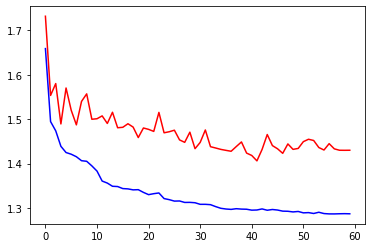

0.8344
Normalized confusion matrix


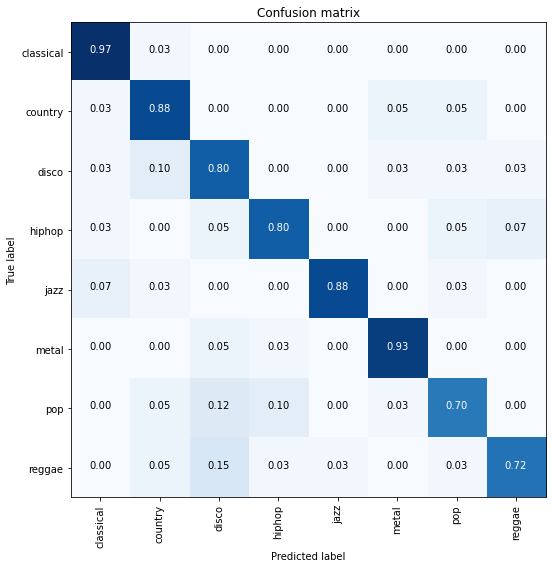

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.3817] [Train Acc: 0.8912] [Valid Loss: 1.4981] [Valid Acc: 0.7688]
Epoch    11: reducing learning rate of group 0 to 2.1000e-02.
Epoch    15: reducing learning rate of group 0 to 1.4700e-02.
[Epoch 20/60] [Train Loss: 1.3269] [Train Acc: 0.9466] [Valid Loss: 1.5285] [Valid Acc: 0.7375]
Epoch    23: reducing learning rate of group 0 to 1.0290e-02.
Epoch    27: reducing learning rate of group 0 to 7.2030e-03.
[Epoch 30/60] [Train Loss: 1.2996] [Train Acc: 0.9753] [Valid Loss: 1.4855] [Valid Acc: 0.7875]
Epoch    31: reducing learning rate of group 0 to 5.0421e-03.
Epoch    35: reducing learning rate of group 0 to 3.5295e-03.
Epoch    39: reducing learning rate of group 0 to 2.4706e-03.
[Epoch 40/60] [Train Loss: 1.2950] [Train Acc: 0.9793] [Valid Loss: 1.4870] [Valid Acc: 0.7812]
Epoch    43: reducing learning rate of group 0 to 1.7294e-03.
Epoch    47: reducing learning rate of group 0 to 1.2106e-03.
[Epoch 50/60] [Train Loss: 1.2905] [Trai

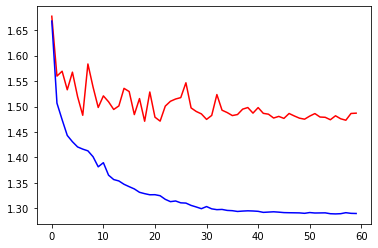

0.8
Normalized confusion matrix


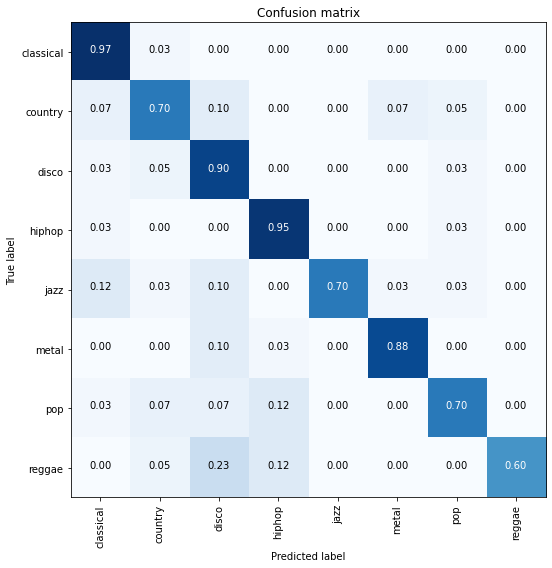

Training on GPU:0
Epoch     7: reducing learning rate of group 0 to 2.2400e-02.
[Epoch 10/60] [Train Loss: 1.3950] [Train Acc: 0.8788] [Valid Loss: 1.5369] [Valid Acc: 0.7312]
Epoch    15: reducing learning rate of group 0 to 1.5680e-02.
Epoch    19: reducing learning rate of group 0 to 1.0976e-02.
[Epoch 20/60] [Train Loss: 1.3315] [Train Acc: 0.9426] [Valid Loss: 1.4846] [Valid Acc: 0.7812]
Epoch    26: reducing learning rate of group 0 to 7.6832e-03.
[Epoch 30/60] [Train Loss: 1.3099] [Train Acc: 0.9639] [Valid Loss: 1.4816] [Valid Acc: 0.7937]
Epoch    30: reducing learning rate of group 0 to 5.3782e-03.
Epoch    36: reducing learning rate of group 0 to 3.7648e-03.
[Epoch 40/60] [Train Loss: 1.2968] [Train Acc: 0.9777] [Valid Loss: 1.4630] [Valid Acc: 0.8125]
Epoch    45: reducing learning rate of group 0 to 2.6353e-03.
Epoch    49: reducing learning rate of group 0 to 1.8447e-03.
[Epoch 50/60] [Train Loss: 1.2925] [Train Acc: 0.9818] [Valid Loss: 1.4595] [Valid Acc: 0.8187]
Epoch 

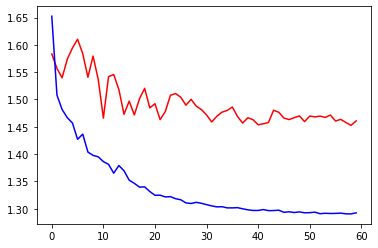

0.825
Normalized confusion matrix


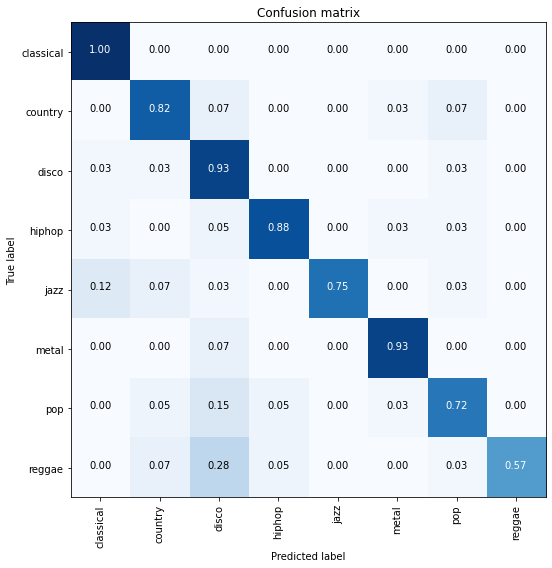

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.4090] [Train Acc: 0.8644] [Valid Loss: 1.5585] [Valid Acc: 0.7125]
Epoch    13: reducing learning rate of group 0 to 2.3800e-02.
Epoch    19: reducing learning rate of group 0 to 1.6660e-02.
[Epoch 20/60] [Train Loss: 1.3526] [Train Acc: 0.9206] [Valid Loss: 1.5117] [Valid Acc: 0.7625]
Epoch    23: reducing learning rate of group 0 to 1.1662e-02.
[Epoch 30/60] [Train Loss: 1.3218] [Train Acc: 0.9524] [Valid Loss: 1.5216] [Valid Acc: 0.7562]
Epoch    31: reducing learning rate of group 0 to 8.1634e-03.
Epoch    36: reducing learning rate of group 0 to 5.7144e-03.
[Epoch 40/60] [Train Loss: 1.3054] [Train Acc: 0.9684] [Valid Loss: 1.5185] [Valid Acc: 0.7562]
Epoch    40: reducing learning rate of group 0 to 4.0001e-03.
Epoch    48: reducing learning rate of group 0 to 2.8000e-03.
[Epoch 50/60] [Train Loss: 1.3020] [Train Acc: 0.9716] [Valid Loss: 1.5055] [Valid Acc: 0.7688]
Epoch    52: reducing learning rate of group 0 to 1.9600e-03.
Epoch 

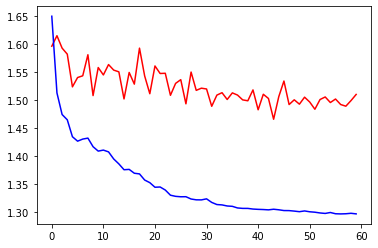

0.8
Normalized confusion matrix


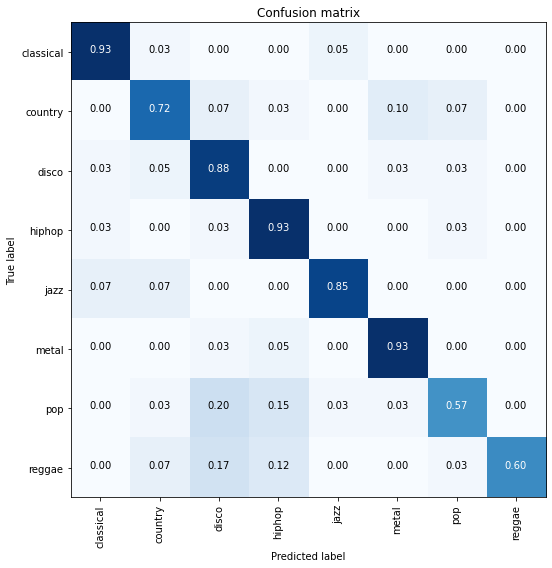

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.4189] [Train Acc: 0.8538] [Valid Loss: 1.6132] [Valid Acc: 0.6562]
Epoch    15: reducing learning rate of group 0 to 2.5200e-02.
Epoch    19: reducing learning rate of group 0 to 1.7640e-02.
[Epoch 20/60] [Train Loss: 1.3564] [Train Acc: 0.9168] [Valid Loss: 1.4883] [Valid Acc: 0.7875]
Epoch    24: reducing learning rate of group 0 to 1.2348e-02.
Epoch    28: reducing learning rate of group 0 to 8.6436e-03.
[Epoch 30/60] [Train Loss: 1.3276] [Train Acc: 0.9466] [Valid Loss: 1.5047] [Valid Acc: 0.7688]
Epoch    32: reducing learning rate of group 0 to 6.0505e-03.
Epoch    36: reducing learning rate of group 0 to 4.2354e-03.
[Epoch 40/60] [Train Loss: 1.3139] [Train Acc: 0.9598] [Valid Loss: 1.5227] [Valid Acc: 0.7500]
Epoch    41: reducing learning rate of group 0 to 2.9648e-03.
Epoch    45: reducing learning rate of group 0 to 2.0753e-03.
Epoch    49: reducing learning rate of group 0 to 1.4527e-03.
[Epoch 50/60] [Train Loss: 1.3091] [Trai

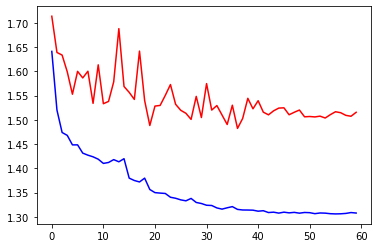

0.775
Normalized confusion matrix


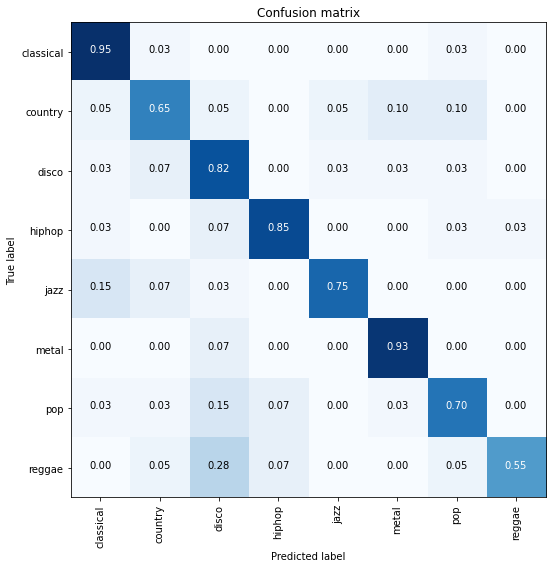

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.5049] [Train Acc: 0.7676] [Valid Loss: 1.5676] [Valid Acc: 0.7063]
[Epoch 20/60] [Train Loss: 1.4819] [Train Acc: 0.7913] [Valid Loss: 1.5676] [Valid Acc: 0.7000]
Epoch    21: reducing learning rate of group 0 to 2.6600e-02.
Epoch    25: reducing learning rate of group 0 to 1.8620e-02.
Epoch    29: reducing learning rate of group 0 to 1.3034e-02.
[Epoch 30/60] [Train Loss: 1.4402] [Train Acc: 0.8336] [Valid Loss: 1.5700] [Valid Acc: 0.7063]
Epoch    33: reducing learning rate of group 0 to 9.1238e-03.
Epoch    37: reducing learning rate of group 0 to 6.3867e-03.
[Epoch 40/60] [Train Loss: 1.4258] [Train Acc: 0.8477] [Valid Loss: 1.5533] [Valid Acc: 0.7188]
Epoch    41: reducing learning rate of group 0 to 4.4707e-03.
Epoch    45: reducing learning rate of group 0 to 3.1295e-03.
Epoch    49: reducing learning rate of group 0 to 2.1906e-03.
[Epoch 50/60] [Train Loss: 1.4215] [Train Acc: 0.8523] [Valid Loss: 1.5526] [Valid Acc: 0.7188]
Epoch 

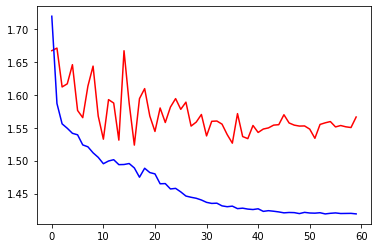

0.7188
Normalized confusion matrix


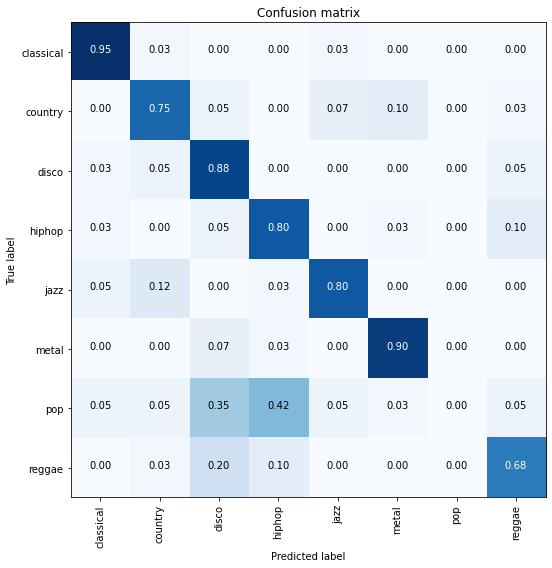

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.5126] [Train Acc: 0.7611] [Valid Loss: 1.6565] [Valid Acc: 0.6188]
Epoch    16: reducing learning rate of group 0 to 2.8000e-02.
[Epoch 20/60] [Train Loss: 1.4656] [Train Acc: 0.8080] [Valid Loss: 1.5863] [Valid Acc: 0.6937]
Epoch    20: reducing learning rate of group 0 to 1.9600e-02.
Epoch    26: reducing learning rate of group 0 to 1.3720e-02.
[Epoch 30/60] [Train Loss: 1.4412] [Train Acc: 0.8317] [Valid Loss: 1.5124] [Valid Acc: 0.7625]
Epoch    34: reducing learning rate of group 0 to 9.6040e-03.
Epoch    38: reducing learning rate of group 0 to 6.7228e-03.
[Epoch 40/60] [Train Loss: 1.4266] [Train Acc: 0.8470] [Valid Loss: 1.5354] [Valid Acc: 0.7375]
Epoch    42: reducing learning rate of group 0 to 4.7060e-03.
Epoch    46: reducing learning rate of group 0 to 3.2942e-03.
[Epoch 50/60] [Train Loss: 1.4224] [Train Acc: 0.8513] [Valid Loss: 1.5529] [Valid Acc: 0.7188]
Epoch    50: reducing learning rate of group 0 to 2.3059e-03.
Epoch 

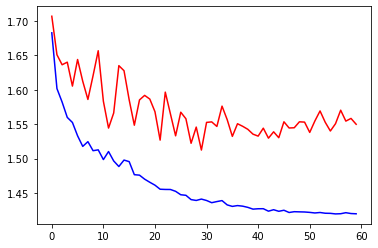

0.7188
Normalized confusion matrix


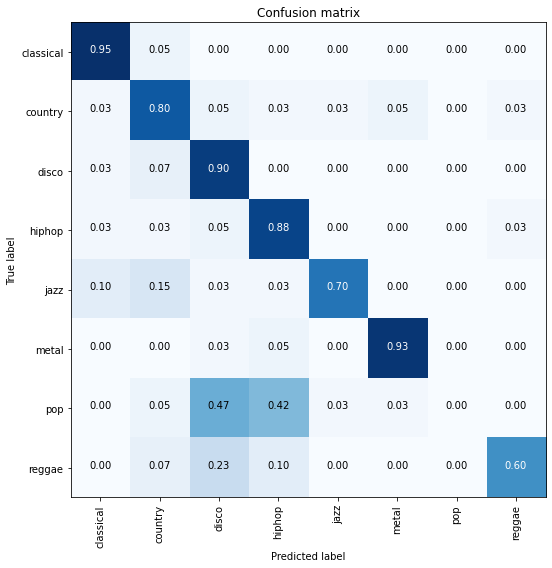

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.4657] [Train Acc: 0.8074] [Valid Loss: 1.5643] [Valid Acc: 0.7000]
Epoch    16: reducing learning rate of group 0 to 2.9400e-02.
[Epoch 20/60] [Train Loss: 1.4033] [Train Acc: 0.8703] [Valid Loss: 1.5079] [Valid Acc: 0.7625]
Epoch    20: reducing learning rate of group 0 to 2.0580e-02.
Epoch    24: reducing learning rate of group 0 to 1.4406e-02.
Epoch    28: reducing learning rate of group 0 to 1.0084e-02.
[Epoch 30/60] [Train Loss: 1.3511] [Train Acc: 0.9225] [Valid Loss: 1.5485] [Valid Acc: 0.7250]
Epoch    32: reducing learning rate of group 0 to 7.0589e-03.
Epoch    38: reducing learning rate of group 0 to 4.9413e-03.
[Epoch 40/60] [Train Loss: 1.3363] [Train Acc: 0.9375] [Valid Loss: 1.5117] [Valid Acc: 0.7625]
Epoch    42: reducing learning rate of group 0 to 3.4589e-03.
Epoch    46: reducing learning rate of group 0 to 2.4212e-03.
[Epoch 50/60] [Train Loss: 1.3266] [Train Acc: 0.9477] [Valid Loss: 1.5044] [Valid Acc: 0.7688]
Epoch 

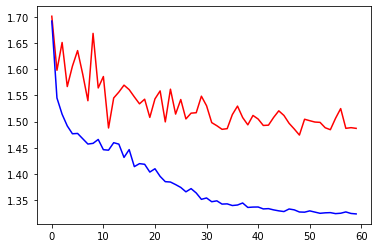

0.7937
Normalized confusion matrix


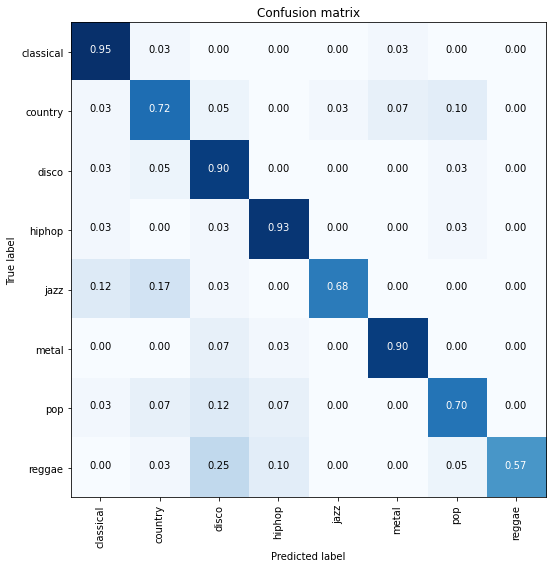

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.4470] [Train Acc: 0.8262] [Valid Loss: 1.5321] [Valid Acc: 0.7375]
Epoch    14: reducing learning rate of group 0 to 3.0800e-02.
[Epoch 20/60] [Train Loss: 1.4174] [Train Acc: 0.8558] [Valid Loss: 1.5027] [Valid Acc: 0.7688]
Epoch    22: reducing learning rate of group 0 to 2.1560e-02.
[Epoch 30/60] [Train Loss: 1.3812] [Train Acc: 0.8919] [Valid Loss: 1.5614] [Valid Acc: 0.7063]
Epoch    30: reducing learning rate of group 0 to 1.5092e-02.
Epoch    35: reducing learning rate of group 0 to 1.0564e-02.
[Epoch 40/60] [Train Loss: 1.3472] [Train Acc: 0.9258] [Valid Loss: 1.4889] [Valid Acc: 0.7875]
Epoch    42: reducing learning rate of group 0 to 7.3951e-03.
[Epoch 50/60] [Train Loss: 1.3339] [Train Acc: 0.9400] [Valid Loss: 1.4469] [Valid Acc: 0.8250]
Epoch    52: reducing learning rate of group 0 to 5.1766e-03.
Epoch    56: reducing learning rate of group 0 to 3.6236e-03.
[Epoch 60/60] [Train Loss: 1.3249] [Train Acc: 0.9487] [Valid Loss: 

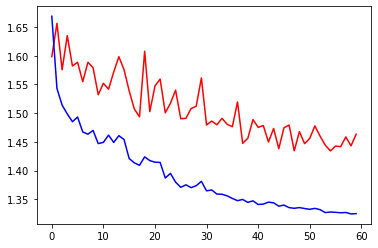

0.8125
Normalized confusion matrix


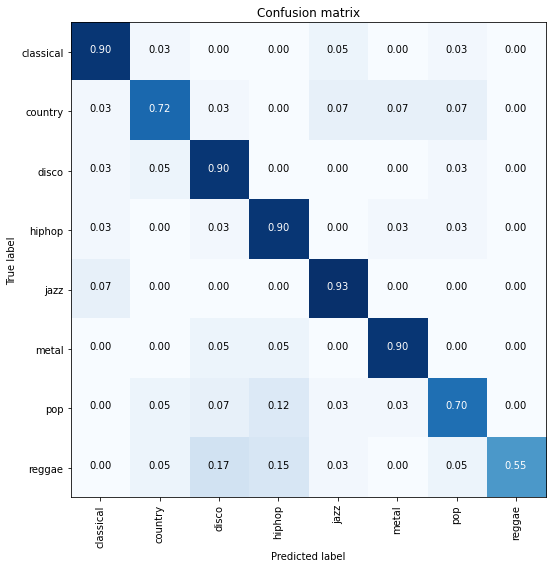

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.6736] [Train Acc: 0.6280] [Valid Loss: 1.7411] [Valid Acc: 0.5750]
[Epoch 20/60] [Train Loss: 1.4443] [Train Acc: 0.8792] [Valid Loss: 1.6036] [Valid Acc: 0.7063]
[Epoch 30/60] [Train Loss: 1.3612] [Train Acc: 0.9385] [Valid Loss: 1.5182] [Valid Acc: 0.7625]
Epoch    37: reducing learning rate of group 0 to 1.4000e-04.
[Epoch 40/60] [Train Loss: 1.3293] [Train Acc: 0.9628] [Valid Loss: 1.5037] [Valid Acc: 0.7750]
Epoch    47: reducing learning rate of group 0 to 9.8000e-05.
[Epoch 50/60] [Train Loss: 1.3170] [Train Acc: 0.9718] [Valid Loss: 1.4654] [Valid Acc: 0.8187]
Epoch    54: reducing learning rate of group 0 to 6.8600e-05.
Epoch    58: reducing learning rate of group 0 to 4.8020e-05.
[Epoch 60/60] [Train Loss: 1.3099] [Train Acc: 0.9758] [Valid Loss: 1.4756] [Valid Acc: 0.8063]
Training Finished
Test Accuracy: 81.88%


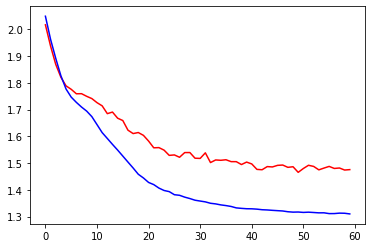

0.8125
Normalized confusion matrix


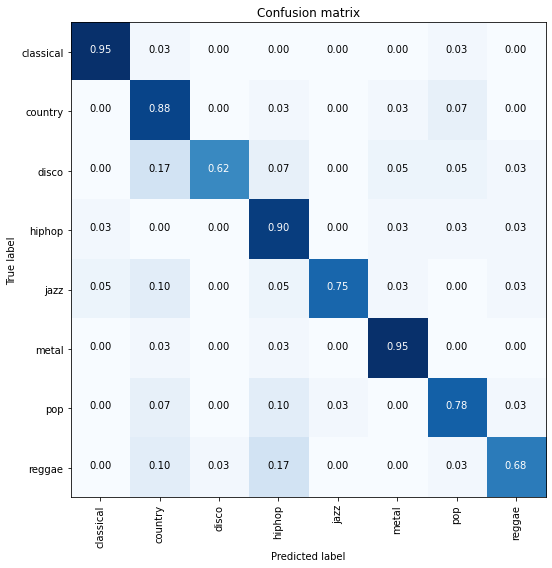

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.5915] [Train Acc: 0.7251] [Valid Loss: 1.6735] [Valid Acc: 0.6188]
[Epoch 20/60] [Train Loss: 1.4148] [Train Acc: 0.8947] [Valid Loss: 1.5392] [Valid Acc: 0.7562]
[Epoch 30/60] [Train Loss: 1.3535] [Train Acc: 0.9410] [Valid Loss: 1.5087] [Valid Acc: 0.7688]
[Epoch 40/60] [Train Loss: 1.3308] [Train Acc: 0.9579] [Valid Loss: 1.4915] [Valid Acc: 0.7875]
Epoch    40: reducing learning rate of group 0 to 1.6800e-04.
Epoch    44: reducing learning rate of group 0 to 1.1760e-04.
Epoch    48: reducing learning rate of group 0 to 8.2320e-05.
[Epoch 50/60] [Train Loss: 1.3141] [Train Acc: 0.9698] [Valid Loss: 1.4779] [Valid Acc: 0.8125]
Epoch    57: reducing learning rate of group 0 to 5.7624e-05.
[Epoch 60/60] [Train Loss: 1.3092] [Train Acc: 0.9759] [Valid Loss: 1.4729] [Valid Acc: 0.8187]
Training Finished
Test Accuracy: 86.25%


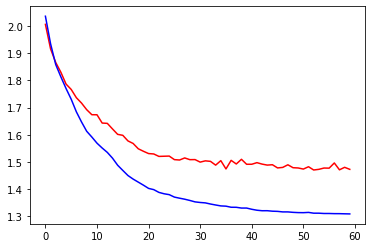

0.8406
Normalized confusion matrix


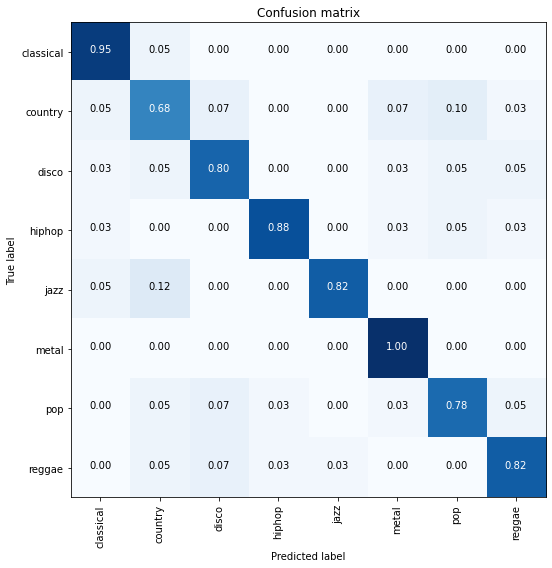

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.6209] [Train Acc: 0.6736] [Valid Loss: 1.7006] [Valid Acc: 0.5563]
[Epoch 20/60] [Train Loss: 1.4210] [Train Acc: 0.8907] [Valid Loss: 1.5444] [Valid Acc: 0.7625]
[Epoch 30/60] [Train Loss: 1.3525] [Train Acc: 0.9419] [Valid Loss: 1.4685] [Valid Acc: 0.8375]
[Epoch 40/60] [Train Loss: 1.3215] [Train Acc: 0.9659] [Valid Loss: 1.4496] [Valid Acc: 0.8625]
Epoch    43: reducing learning rate of group 0 to 1.9600e-04.
Epoch    47: reducing learning rate of group 0 to 1.3720e-04.
[Epoch 50/60] [Train Loss: 1.3089] [Train Acc: 0.9743] [Valid Loss: 1.4443] [Valid Acc: 0.8562]
Epoch    55: reducing learning rate of group 0 to 9.6040e-05.
Epoch    59: reducing learning rate of group 0 to 6.7228e-05.
[Epoch 60/60] [Train Loss: 1.3016] [Train Acc: 0.9817] [Valid Loss: 1.4421] [Valid Acc: 0.8375]
Training Finished
Test Accuracy: 81.25%


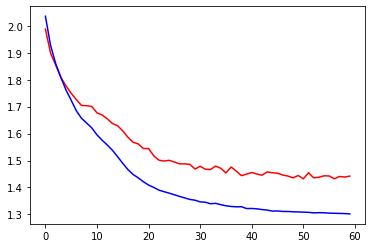

0.825
Normalized confusion matrix


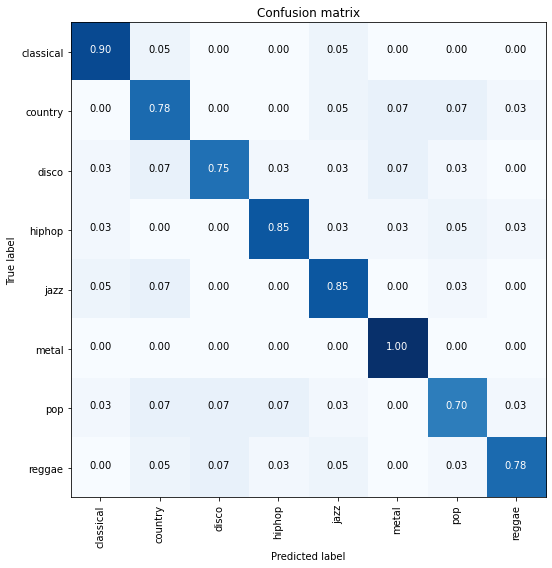

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.5378] [Train Acc: 0.7941] [Valid Loss: 1.6439] [Valid Acc: 0.6750]
[Epoch 20/60] [Train Loss: 1.3749] [Train Acc: 0.9273] [Valid Loss: 1.5112] [Valid Acc: 0.8000]
[Epoch 30/60] [Train Loss: 1.3353] [Train Acc: 0.9551] [Valid Loss: 1.5093] [Valid Acc: 0.7875]
Epoch    31: reducing learning rate of group 0 to 2.1000e-04.
Epoch    37: reducing learning rate of group 0 to 1.4700e-04.
[Epoch 40/60] [Train Loss: 1.3159] [Train Acc: 0.9698] [Valid Loss: 1.4765] [Valid Acc: 0.8063]
Epoch    43: reducing learning rate of group 0 to 1.0290e-04.
Epoch    47: reducing learning rate of group 0 to 7.2030e-05.
[Epoch 50/60] [Train Loss: 1.3076] [Train Acc: 0.9769] [Valid Loss: 1.4639] [Valid Acc: 0.8187]
Epoch    54: reducing learning rate of group 0 to 5.0421e-05.
[Epoch 60/60] [Train Loss: 1.3060] [Train Acc: 0.9774] [Valid Loss: 1.4704] [Valid Acc: 0.8125]
Training Finished
Test Accuracy: 81.25%


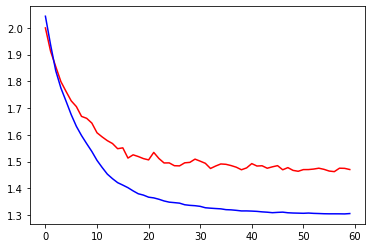

0.8125
Normalized confusion matrix


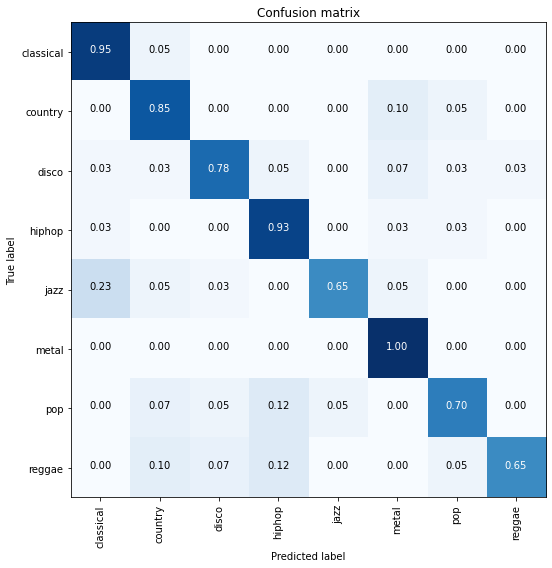

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.5361] [Train Acc: 0.7672] [Valid Loss: 1.6297] [Valid Acc: 0.6625]
[Epoch 20/60] [Train Loss: 1.3798] [Train Acc: 0.9227] [Valid Loss: 1.5180] [Valid Acc: 0.7812]
[Epoch 30/60] [Train Loss: 1.3354] [Train Acc: 0.9565] [Valid Loss: 1.4630] [Valid Acc: 0.8438]
Epoch    34: reducing learning rate of group 0 to 2.2400e-04.
[Epoch 40/60] [Train Loss: 1.3161] [Train Acc: 0.9704] [Valid Loss: 1.4726] [Valid Acc: 0.8125]
Epoch    42: reducing learning rate of group 0 to 1.5680e-04.
Epoch    47: reducing learning rate of group 0 to 1.0976e-04.
[Epoch 50/60] [Train Loss: 1.3046] [Train Acc: 0.9801] [Valid Loss: 1.4593] [Valid Acc: 0.8125]
Epoch    52: reducing learning rate of group 0 to 7.6832e-05.
Epoch    57: reducing learning rate of group 0 to 5.3782e-05.
[Epoch 60/60] [Train Loss: 1.3021] [Train Acc: 0.9801] [Valid Loss: 1.4406] [Valid Acc: 0.8625]
Training Finished
Test Accuracy: 81.88%


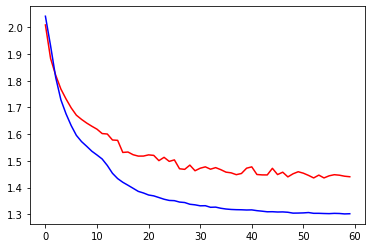

0.8406
Normalized confusion matrix


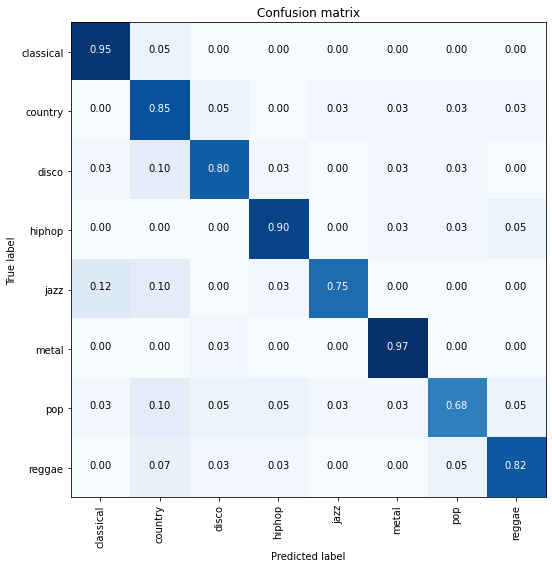

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.5136] [Train Acc: 0.8002] [Valid Loss: 1.6313] [Valid Acc: 0.6750]
[Epoch 20/60] [Train Loss: 1.3590] [Train Acc: 0.9381] [Valid Loss: 1.5168] [Valid Acc: 0.7812]
Epoch    23: reducing learning rate of group 0 to 2.3800e-04.
[Epoch 30/60] [Train Loss: 1.3227] [Train Acc: 0.9667] [Valid Loss: 1.4872] [Valid Acc: 0.8063]
Epoch    30: reducing learning rate of group 0 to 1.6660e-04.
Epoch    35: reducing learning rate of group 0 to 1.1662e-04.
[Epoch 40/60] [Train Loss: 1.3090] [Train Acc: 0.9769] [Valid Loss: 1.4496] [Valid Acc: 0.8375]
Epoch    44: reducing learning rate of group 0 to 8.1634e-05.
Epoch    48: reducing learning rate of group 0 to 5.7144e-05.
[Epoch 50/60] [Train Loss: 1.3032] [Train Acc: 0.9802] [Valid Loss: 1.4526] [Valid Acc: 0.8187]
Epoch    52: reducing learning rate of group 0 to 4.0001e-05.
Epoch    56: reducing learning rate of group 0 to 2.8000e-05.
[Epoch 60/60] [Train Loss: 1.3025] [Train Acc: 0.9803] [Valid Loss: 

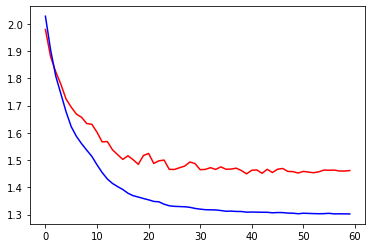

0.8281
Normalized confusion matrix


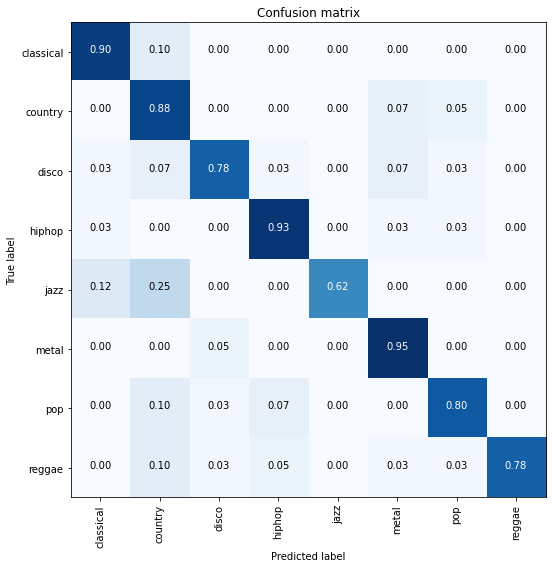

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.4723] [Train Acc: 0.8492] [Valid Loss: 1.6170] [Valid Acc: 0.7063]
[Epoch 20/60] [Train Loss: 1.3520] [Train Acc: 0.9464] [Valid Loss: 1.5235] [Valid Acc: 0.7625]
[Epoch 30/60] [Train Loss: 1.3179] [Train Acc: 0.9684] [Valid Loss: 1.4773] [Valid Acc: 0.8000]
Epoch    31: reducing learning rate of group 0 to 2.5200e-04.
Epoch    35: reducing learning rate of group 0 to 1.7640e-04.
[Epoch 40/60] [Train Loss: 1.3037] [Train Acc: 0.9808] [Valid Loss: 1.4478] [Valid Acc: 0.8500]
Epoch    42: reducing learning rate of group 0 to 1.2348e-04.
Epoch    48: reducing learning rate of group 0 to 8.6436e-05.
[Epoch 50/60] [Train Loss: 1.2978] [Train Acc: 0.9832] [Valid Loss: 1.4547] [Valid Acc: 0.8375]
Epoch    52: reducing learning rate of group 0 to 6.0505e-05.
Epoch    56: reducing learning rate of group 0 to 4.2354e-05.
[Epoch 60/60] [Train Loss: 1.2941] [Train Acc: 0.9869] [Valid Loss: 1.4591] [Valid Acc: 0.8375]
Epoch    60: reducing learning rat

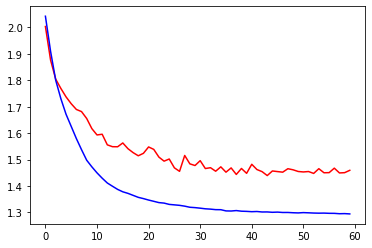

0.8375
Normalized confusion matrix


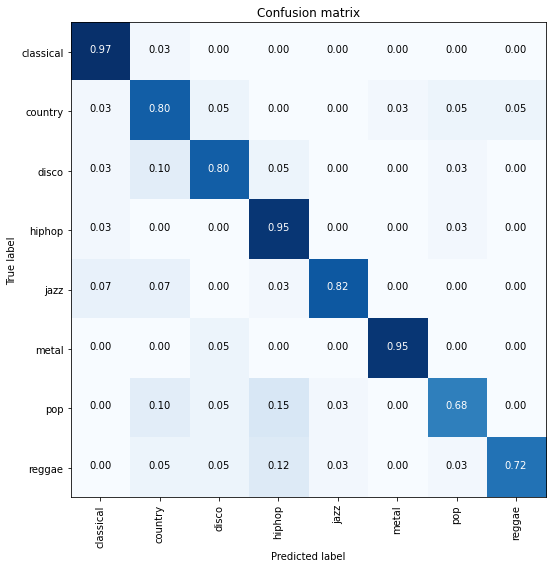

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.4609] [Train Acc: 0.8574] [Valid Loss: 1.5573] [Valid Acc: 0.7688]
[Epoch 20/60] [Train Loss: 1.3549] [Train Acc: 0.9398] [Valid Loss: 1.4822] [Valid Acc: 0.8187]
Epoch    23: reducing learning rate of group 0 to 2.6600e-04.
[Epoch 30/60] [Train Loss: 1.3234] [Train Acc: 0.9650] [Valid Loss: 1.4516] [Valid Acc: 0.8375]
Epoch    31: reducing learning rate of group 0 to 1.8620e-04.
Epoch    36: reducing learning rate of group 0 to 1.3034e-04.
[Epoch 40/60] [Train Loss: 1.3104] [Train Acc: 0.9760] [Valid Loss: 1.4305] [Valid Acc: 0.8625]
Epoch    40: reducing learning rate of group 0 to 9.1238e-05.
Epoch    44: reducing learning rate of group 0 to 6.3867e-05.
Epoch    48: reducing learning rate of group 0 to 4.4707e-05.
[Epoch 50/60] [Train Loss: 1.3042] [Train Acc: 0.9795] [Valid Loss: 1.4305] [Valid Acc: 0.8688]
Epoch    52: reducing learning rate of group 0 to 3.1295e-05.
Epoch    56: reducing learning rate of group 0 to 2.1906e-05.
[Epoch

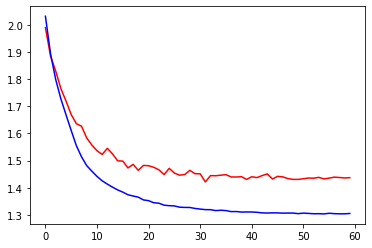

0.8406
Normalized confusion matrix


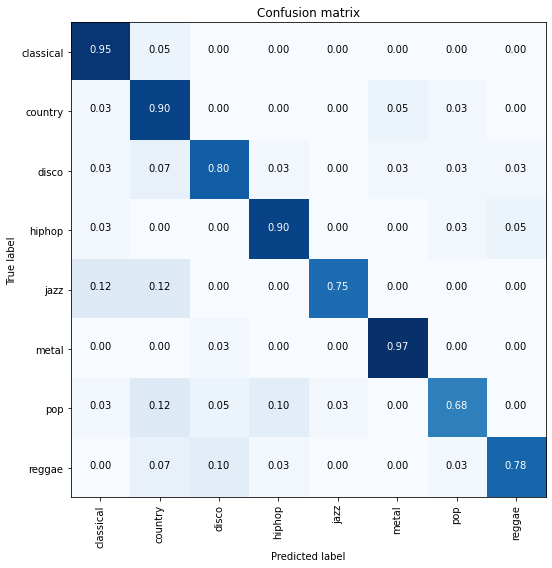

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.4458] [Train Acc: 0.8701] [Valid Loss: 1.5834] [Valid Acc: 0.7562]
[Epoch 20/60] [Train Loss: 1.3433] [Train Acc: 0.9502] [Valid Loss: 1.5216] [Valid Acc: 0.7625]
Epoch    28: reducing learning rate of group 0 to 2.8000e-04.
[Epoch 30/60] [Train Loss: 1.3120] [Train Acc: 0.9733] [Valid Loss: 1.4936] [Valid Acc: 0.7875]
Epoch    33: reducing learning rate of group 0 to 1.9600e-04.
[Epoch 40/60] [Train Loss: 1.3008] [Train Acc: 0.9824] [Valid Loss: 1.4918] [Valid Acc: 0.7812]
Epoch    40: reducing learning rate of group 0 to 1.3720e-04.
Epoch    45: reducing learning rate of group 0 to 9.6040e-05.
Epoch    49: reducing learning rate of group 0 to 6.7228e-05.
[Epoch 50/60] [Train Loss: 1.2956] [Train Acc: 0.9853] [Valid Loss: 1.4803] [Valid Acc: 0.8000]
Epoch    53: reducing learning rate of group 0 to 4.7060e-05.
Epoch    57: reducing learning rate of group 0 to 3.2942e-05.
[Epoch 60/60] [Train Loss: 1.2934] [Train Acc: 0.9876] [Valid Loss: 

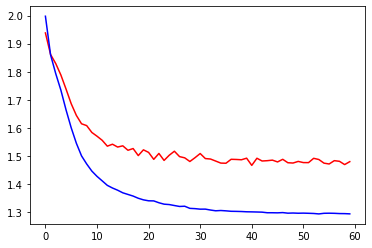

0.8031
Normalized confusion matrix


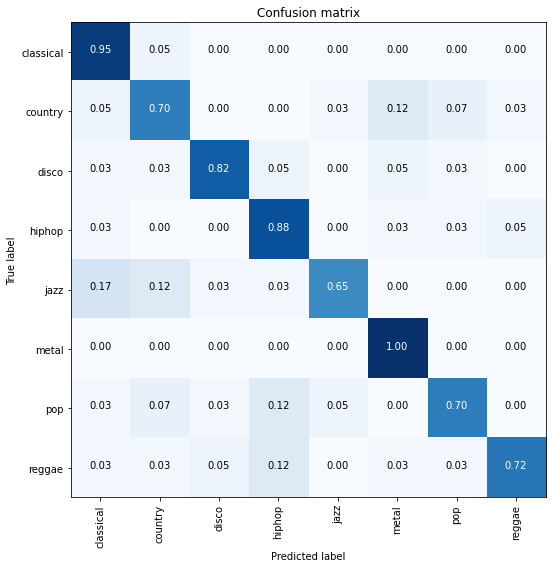

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.4602] [Train Acc: 0.8633] [Valid Loss: 1.5945] [Valid Acc: 0.7250]
[Epoch 20/60] [Train Loss: 1.3420] [Train Acc: 0.9491] [Valid Loss: 1.4918] [Valid Acc: 0.8000]
[Epoch 30/60] [Train Loss: 1.3117] [Train Acc: 0.9723] [Valid Loss: 1.4899] [Valid Acc: 0.7875]
Epoch    35: reducing learning rate of group 0 to 2.9400e-04.
[Epoch 40/60] [Train Loss: 1.2957] [Train Acc: 0.9854] [Valid Loss: 1.4537] [Valid Acc: 0.8250]
Epoch    46: reducing learning rate of group 0 to 2.0580e-04.
[Epoch 50/60] [Train Loss: 1.2901] [Train Acc: 0.9894] [Valid Loss: 1.4657] [Valid Acc: 0.8125]
Epoch    50: reducing learning rate of group 0 to 1.4406e-04.
Epoch    57: reducing learning rate of group 0 to 1.0084e-04.
[Epoch 60/60] [Train Loss: 1.2861] [Train Acc: 0.9929] [Valid Loss: 1.4422] [Valid Acc: 0.8500]
Training Finished
Test Accuracy: 83.75%


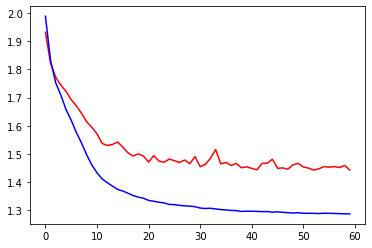

0.8438
Normalized confusion matrix


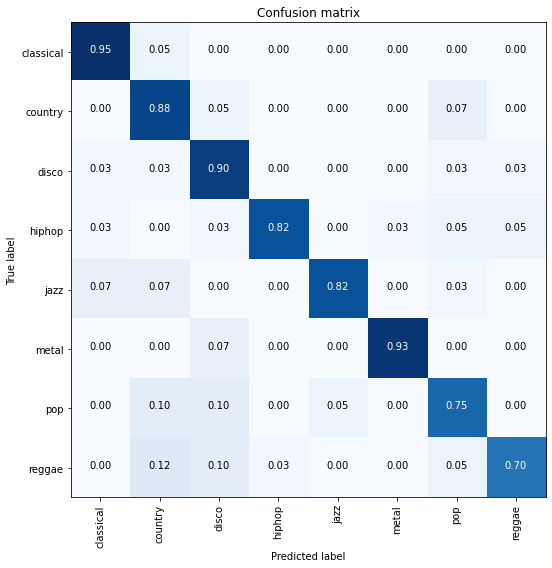

Training on GPU:0
[Epoch 10/60] [Train Loss: 1.4613] [Train Acc: 0.8590] [Valid Loss: 1.5889] [Valid Acc: 0.7063]
[Epoch 20/60] [Train Loss: 1.3472] [Train Acc: 0.9483] [Valid Loss: 1.4819] [Valid Acc: 0.8125]
Epoch    24: reducing learning rate of group 0 to 3.0800e-04.
[Epoch 30/60] [Train Loss: 1.3165] [Train Acc: 0.9705] [Valid Loss: 1.4630] [Valid Acc: 0.8375]
Epoch    39: reducing learning rate of group 0 to 2.1560e-04.
[Epoch 40/60] [Train Loss: 1.3029] [Train Acc: 0.9789] [Valid Loss: 1.4620] [Valid Acc: 0.8125]
Epoch    48: reducing learning rate of group 0 to 1.5092e-04.
[Epoch 50/60] [Train Loss: 1.2953] [Train Acc: 0.9856] [Valid Loss: 1.4571] [Valid Acc: 0.8313]
Epoch    52: reducing learning rate of group 0 to 1.0564e-04.
Epoch    59: reducing learning rate of group 0 to 7.3951e-05.
[Epoch 60/60] [Train Loss: 1.2908] [Train Acc: 0.9899] [Valid Loss: 1.4521] [Valid Acc: 0.8375]
Training Finished
Test Accuracy: 83.12%


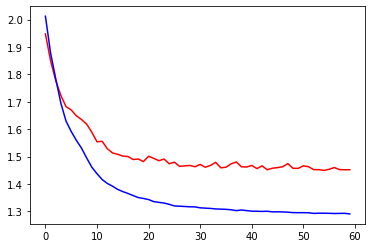

0.8344
Normalized confusion matrix


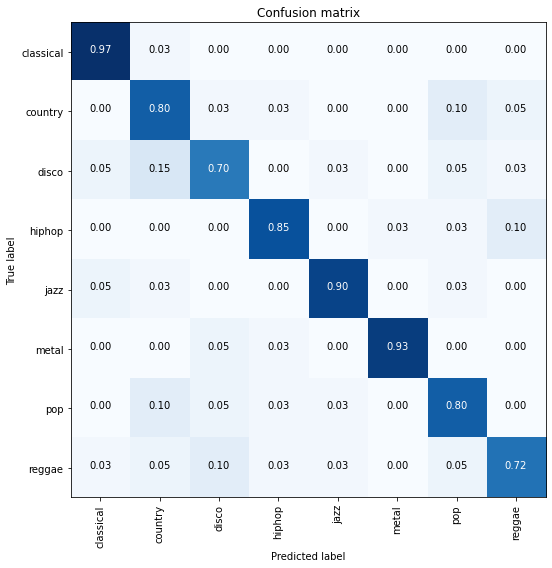

./model_0.0036000000000000003_60_30
0.86875


In [83]:
best=''
best_acc = 0

for lr in lrs :
    acc, path = run(lr,60,30)
    if acc > best_acc:
        best_acc = acc
        best =path
    gc.collect()
    torch.cuda.empty_cache() 
        
print(best)
print(best_acc)

### Best For Feature6
./model_0.0036000000000000003_60_30 <br>
0.86875

In [ ]:
hparams.feature_path = 'feature5'

In [14]:
train_loader, valid_loader, test_loader = get_dataloader(hparams)

In [15]:
lrs = [2.0,2.4,2.8,3.0, 3.2, 3.4, 3.6, 3.8, 4.0,4.2,4.4 ]
lrs = [i * 1e-3 for i in lrs] +[i*1e-2 for i in lrs]+[i*1e-4 for i in lrs] 

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3338] [Train Acc: 0.9502] [Valid Loss: 1.4455] [Valid Acc: 0.8500]
Epoch    17: reducing learning rate of group 0 to 1.4000e-03.
[Epoch 20/70] [Train Loss: 1.2999] [Train Acc: 0.9775] [Valid Loss: 1.4419] [Valid Acc: 0.8375]
Epoch    21: reducing learning rate of group 0 to 9.8000e-04.
Epoch    25: reducing learning rate of group 0 to 6.8600e-04.
[Epoch 30/70] [Train Loss: 1.2876] [Train Acc: 0.9892] [Valid Loss: 1.4368] [Valid Acc: 0.8375]
Epoch    31: reducing learning rate of group 0 to 4.8020e-04.
Epoch    37: reducing learning rate of group 0 to 3.3614e-04.
[Epoch 40/70] [Train Loss: 1.2834] [Train Acc: 0.9928] [Valid Loss: 1.4340] [Valid Acc: 0.8438]
Epoch    41: reducing learning rate of group 0 to 2.3530e-04.
Epoch    45: reducing learning rate of group 0 to 1.6471e-04.
Epoch    49: reducing learning rate of group 0 to 1.1530e-04.
[Epoch 50/70] [Train Loss: 1.2825] [Train Acc: 0.9931] [Valid Loss: 1.4249] [Valid Acc: 0.8500]
Epoch 

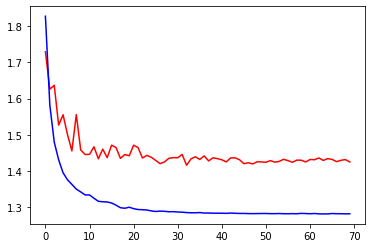

0.8562
Normalized confusion matrix


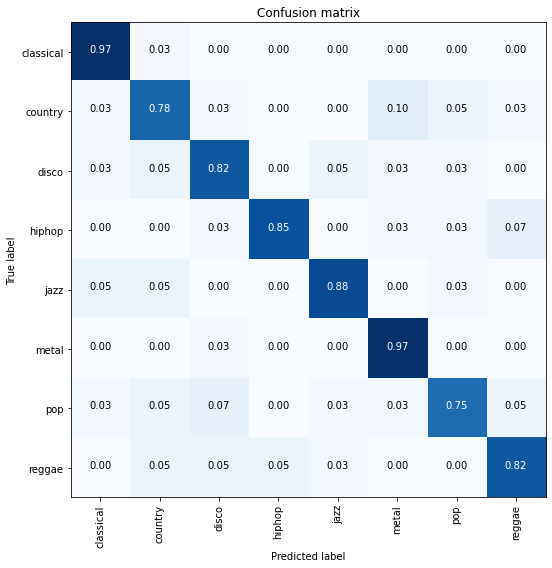

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3336] [Train Acc: 0.9485] [Valid Loss: 1.5097] [Valid Acc: 0.7562]
[Epoch 20/70] [Train Loss: 1.2982] [Train Acc: 0.9799] [Valid Loss: 1.4711] [Valid Acc: 0.8063]
Epoch    20: reducing learning rate of group 0 to 1.6800e-03.
Epoch    24: reducing learning rate of group 0 to 1.1760e-03.
Epoch    28: reducing learning rate of group 0 to 8.2320e-04.
[Epoch 30/70] [Train Loss: 1.2854] [Train Acc: 0.9903] [Valid Loss: 1.4534] [Valid Acc: 0.8063]
Epoch    32: reducing learning rate of group 0 to 5.7624e-04.
Epoch    39: reducing learning rate of group 0 to 4.0337e-04.
[Epoch 40/70] [Train Loss: 1.2826] [Train Acc: 0.9925] [Valid Loss: 1.4607] [Valid Acc: 0.8125]
Epoch    47: reducing learning rate of group 0 to 2.8236e-04.
[Epoch 50/70] [Train Loss: 1.2822] [Train Acc: 0.9932] [Valid Loss: 1.4436] [Valid Acc: 0.8375]
Epoch    51: reducing learning rate of group 0 to 1.9765e-04.
Epoch    59: reducing learning rate of group 0 to 1.3836e-04.
[Epoch

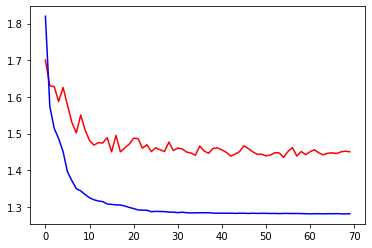

0.8313
Normalized confusion matrix


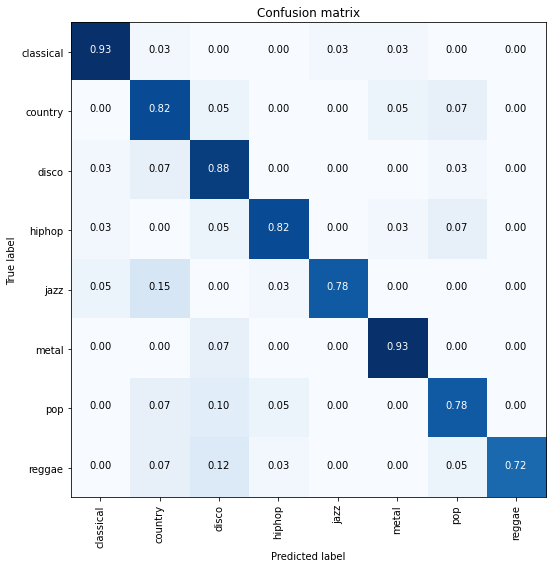

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3361] [Train Acc: 0.9441] [Valid Loss: 1.4655] [Valid Acc: 0.8125]
Epoch    16: reducing learning rate of group 0 to 1.9600e-03.
[Epoch 20/70] [Train Loss: 1.2947] [Train Acc: 0.9826] [Valid Loss: 1.4719] [Valid Acc: 0.7875]
Epoch    20: reducing learning rate of group 0 to 1.3720e-03.
Epoch    24: reducing learning rate of group 0 to 9.6040e-04.
[Epoch 30/70] [Train Loss: 1.2847] [Train Acc: 0.9916] [Valid Loss: 1.4597] [Valid Acc: 0.8187]
Epoch    31: reducing learning rate of group 0 to 6.7228e-04.
Epoch    35: reducing learning rate of group 0 to 4.7060e-04.
Epoch    39: reducing learning rate of group 0 to 3.2942e-04.
[Epoch 40/70] [Train Loss: 1.2810] [Train Acc: 0.9947] [Valid Loss: 1.4551] [Valid Acc: 0.8125]
Epoch    43: reducing learning rate of group 0 to 2.3059e-04.
Epoch    47: reducing learning rate of group 0 to 1.6141e-04.
[Epoch 50/70] [Train Loss: 1.2806] [Train Acc: 0.9948] [Valid Loss: 1.4498] [Valid Acc: 0.8125]
Epoch 

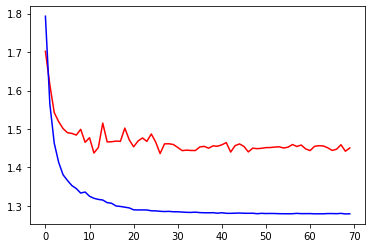

0.8187
Normalized confusion matrix


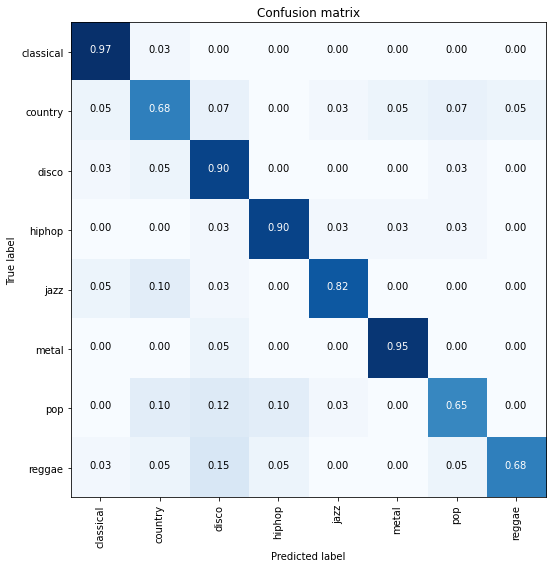

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3264] [Train Acc: 0.9549] [Valid Loss: 1.4630] [Valid Acc: 0.7875]
[Epoch 20/70] [Train Loss: 1.3014] [Train Acc: 0.9769] [Valid Loss: 1.4496] [Valid Acc: 0.8250]
[Epoch 30/70] [Train Loss: 1.2866] [Train Acc: 0.9892] [Valid Loss: 1.4611] [Valid Acc: 0.8125]
Epoch    30: reducing learning rate of group 0 to 2.1000e-03.
Epoch    37: reducing learning rate of group 0 to 1.4700e-03.
[Epoch 40/70] [Train Loss: 1.2798] [Train Acc: 0.9954] [Valid Loss: 1.4223] [Valid Acc: 0.8500]
Epoch    41: reducing learning rate of group 0 to 1.0290e-03.
Epoch    45: reducing learning rate of group 0 to 7.2030e-04.
Epoch    49: reducing learning rate of group 0 to 5.0421e-04.
[Epoch 50/70] [Train Loss: 1.2777] [Train Acc: 0.9970] [Valid Loss: 1.4141] [Valid Acc: 0.8688]
Epoch    54: reducing learning rate of group 0 to 3.5295e-04.
Epoch    58: reducing learning rate of group 0 to 2.4706e-04.
[Epoch 60/70] [Train Loss: 1.2766] [Train Acc: 0.9981] [Valid Loss: 

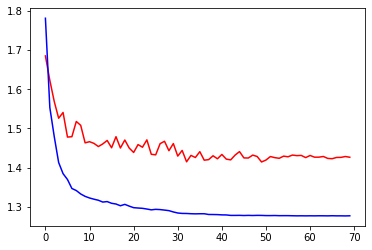

0.85
Normalized confusion matrix


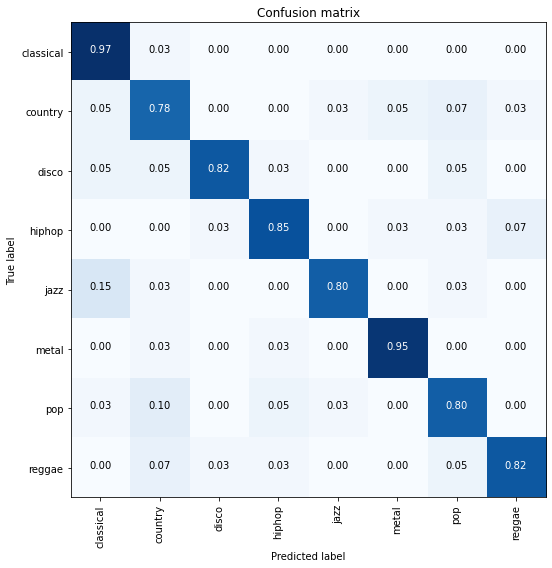

Training on GPU:0
Epoch     8: reducing learning rate of group 0 to 2.2400e-03.
[Epoch 10/70] [Train Loss: 1.3188] [Train Acc: 0.9613] [Valid Loss: 1.5021] [Valid Acc: 0.7750]
[Epoch 20/70] [Train Loss: 1.2968] [Train Acc: 0.9815] [Valid Loss: 1.4777] [Valid Acc: 0.8063]
Epoch    23: reducing learning rate of group 0 to 1.5680e-03.
Epoch    27: reducing learning rate of group 0 to 1.0976e-03.
[Epoch 30/70] [Train Loss: 1.2831] [Train Acc: 0.9931] [Valid Loss: 1.4492] [Valid Acc: 0.8375]
Epoch    31: reducing learning rate of group 0 to 7.6832e-04.
Epoch    36: reducing learning rate of group 0 to 5.3782e-04.
[Epoch 40/70] [Train Loss: 1.2806] [Train Acc: 0.9944] [Valid Loss: 1.4413] [Valid Acc: 0.8313]
Epoch    40: reducing learning rate of group 0 to 3.7648e-04.
Epoch    44: reducing learning rate of group 0 to 2.6353e-04.
Epoch    48: reducing learning rate of group 0 to 1.8447e-04.
[Epoch 50/70] [Train Loss: 1.2795] [Train Acc: 0.9959] [Valid Loss: 1.4461] [Valid Acc: 0.8313]
Epoch 

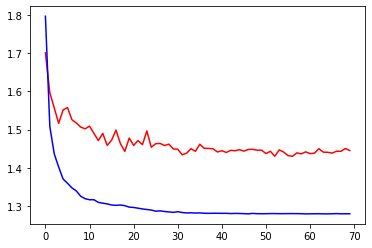

0.8375
Normalized confusion matrix


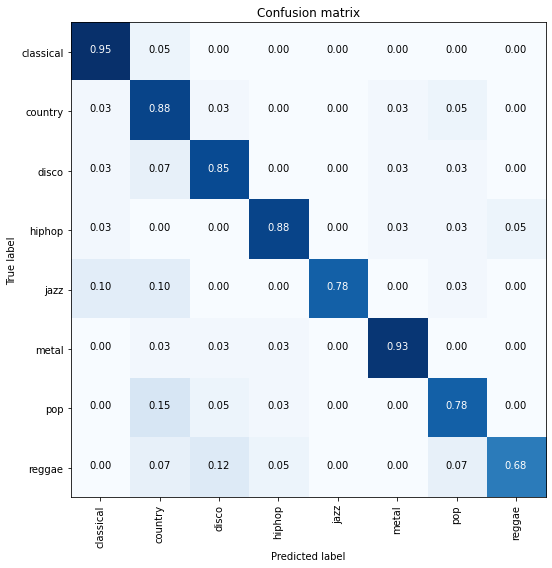

Training on GPU:0
Epoch     8: reducing learning rate of group 0 to 2.3800e-03.
[Epoch 10/70] [Train Loss: 1.3160] [Train Acc: 0.9633] [Valid Loss: 1.4575] [Valid Acc: 0.8187]
Epoch    14: reducing learning rate of group 0 to 1.6660e-03.
Epoch    18: reducing learning rate of group 0 to 1.1662e-03.
[Epoch 20/70] [Train Loss: 1.2907] [Train Acc: 0.9861] [Valid Loss: 1.4754] [Valid Acc: 0.8063]
Epoch    22: reducing learning rate of group 0 to 8.1634e-04.
Epoch    28: reducing learning rate of group 0 to 5.7144e-04.
[Epoch 30/70] [Train Loss: 1.2842] [Train Acc: 0.9921] [Valid Loss: 1.4732] [Valid Acc: 0.7875]
Epoch    32: reducing learning rate of group 0 to 4.0001e-04.
Epoch    36: reducing learning rate of group 0 to 2.8000e-04.
[Epoch 40/70] [Train Loss: 1.2818] [Train Acc: 0.9942] [Valid Loss: 1.4640] [Valid Acc: 0.8187]
Epoch    40: reducing learning rate of group 0 to 1.9600e-04.
Epoch    44: reducing learning rate of group 0 to 1.3720e-04.
Epoch    48: reducing learning rate of g

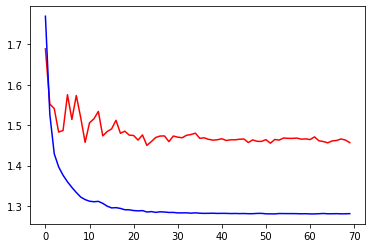

0.825
Normalized confusion matrix


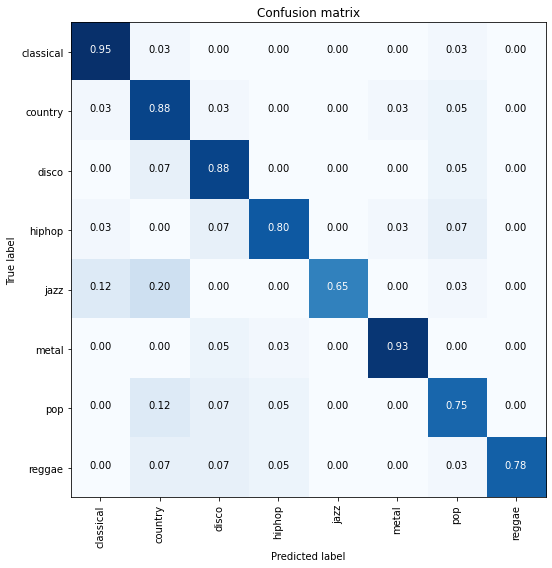

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3252] [Train Acc: 0.9554] [Valid Loss: 1.4564] [Valid Acc: 0.8250]
[Epoch 20/70] [Train Loss: 1.2971] [Train Acc: 0.9796] [Valid Loss: 1.4270] [Valid Acc: 0.8500]
Epoch    26: reducing learning rate of group 0 to 2.5200e-03.
[Epoch 30/70] [Train Loss: 1.2842] [Train Acc: 0.9911] [Valid Loss: 1.4460] [Valid Acc: 0.8125]
Epoch    30: reducing learning rate of group 0 to 1.7640e-03.
Epoch    34: reducing learning rate of group 0 to 1.2348e-03.
Epoch    38: reducing learning rate of group 0 to 8.6436e-04.
[Epoch 40/70] [Train Loss: 1.2788] [Train Acc: 0.9964] [Valid Loss: 1.4422] [Valid Acc: 0.8250]
Epoch    48: reducing learning rate of group 0 to 6.0505e-04.
[Epoch 50/70] [Train Loss: 1.2775] [Train Acc: 0.9972] [Valid Loss: 1.4324] [Valid Acc: 0.8313]
Epoch    52: reducing learning rate of group 0 to 4.2354e-04.
Epoch    56: reducing learning rate of group 0 to 2.9648e-04.
[Epoch 60/70] [Train Loss: 1.2775] [Train Acc: 0.9970] [Valid Loss: 

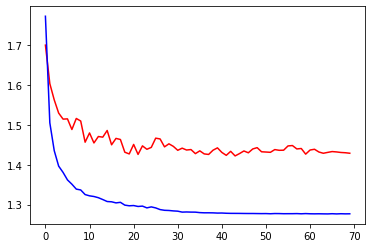

0.8438
Normalized confusion matrix


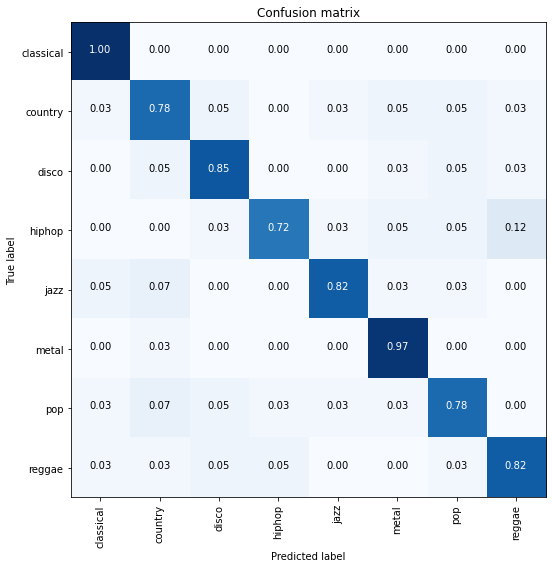

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3242] [Train Acc: 0.9539] [Valid Loss: 1.4820] [Valid Acc: 0.7875]
Epoch    10: reducing learning rate of group 0 to 2.6600e-03.
[Epoch 20/70] [Train Loss: 1.2963] [Train Acc: 0.9810] [Valid Loss: 1.4390] [Valid Acc: 0.8438]
Epoch    29: reducing learning rate of group 0 to 1.8620e-03.
[Epoch 30/70] [Train Loss: 1.2870] [Train Acc: 0.9885] [Valid Loss: 1.4404] [Valid Acc: 0.8250]
Epoch    35: reducing learning rate of group 0 to 1.3034e-03.
[Epoch 40/70] [Train Loss: 1.2803] [Train Acc: 0.9946] [Valid Loss: 1.4301] [Valid Acc: 0.8500]
Epoch    42: reducing learning rate of group 0 to 9.1238e-04.
Epoch    46: reducing learning rate of group 0 to 6.3867e-04.
[Epoch 50/70] [Train Loss: 1.2796] [Train Acc: 0.9955] [Valid Loss: 1.4321] [Valid Acc: 0.8500]
Epoch    51: reducing learning rate of group 0 to 4.4707e-04.
Epoch    55: reducing learning rate of group 0 to 3.1295e-04.
Epoch    59: reducing learning rate of group 0 to 2.1906e-04.
[Epoch

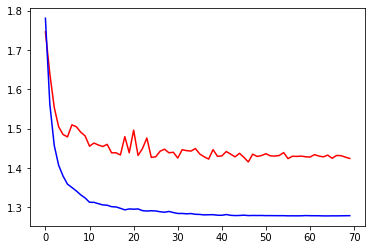

0.8438
Normalized confusion matrix


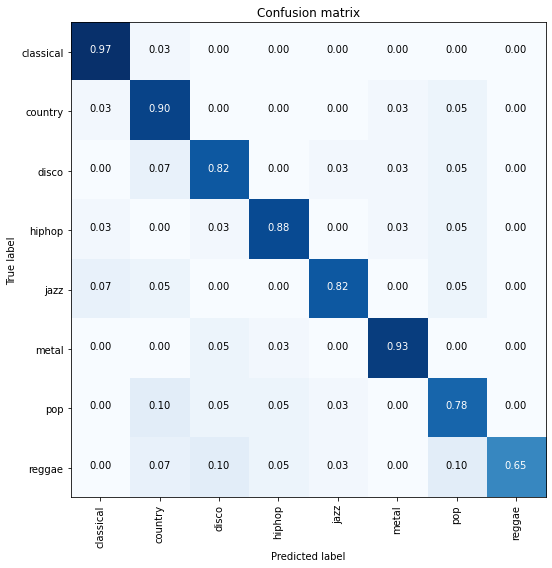

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3334] [Train Acc: 0.9449] [Valid Loss: 1.4705] [Valid Acc: 0.8000]
Epoch    14: reducing learning rate of group 0 to 2.8000e-03.
[Epoch 20/70] [Train Loss: 1.2972] [Train Acc: 0.9794] [Valid Loss: 1.4510] [Valid Acc: 0.8250]
Epoch    27: reducing learning rate of group 0 to 1.9600e-03.
[Epoch 30/70] [Train Loss: 1.2893] [Train Acc: 0.9870] [Valid Loss: 1.4467] [Valid Acc: 0.8250]
Epoch    31: reducing learning rate of group 0 to 1.3720e-03.
Epoch    38: reducing learning rate of group 0 to 9.6040e-04.
[Epoch 40/70] [Train Loss: 1.2823] [Train Acc: 0.9926] [Valid Loss: 1.4435] [Valid Acc: 0.8250]
Epoch    42: reducing learning rate of group 0 to 6.7228e-04.
Epoch    46: reducing learning rate of group 0 to 4.7060e-04.
[Epoch 50/70] [Train Loss: 1.2813] [Train Acc: 0.9940] [Valid Loss: 1.4454] [Valid Acc: 0.8250]
Epoch    50: reducing learning rate of group 0 to 3.2942e-04.
Epoch    54: reducing learning rate of group 0 to 2.3059e-04.
Epoch 

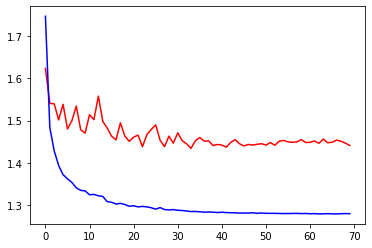

0.8438
Normalized confusion matrix


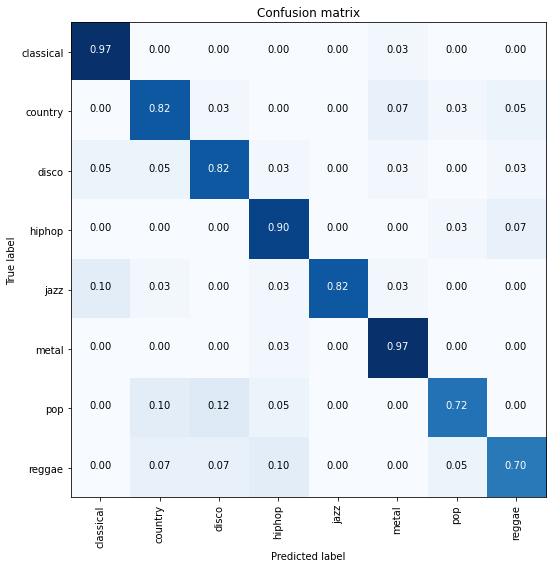

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3195] [Train Acc: 0.9593] [Valid Loss: 1.4845] [Valid Acc: 0.7812]
Epoch    13: reducing learning rate of group 0 to 2.9400e-03.
Epoch    17: reducing learning rate of group 0 to 2.0580e-03.
[Epoch 20/70] [Train Loss: 1.2870] [Train Acc: 0.9891] [Valid Loss: 1.4561] [Valid Acc: 0.8187]
Epoch    21: reducing learning rate of group 0 to 1.4406e-03.
Epoch    27: reducing learning rate of group 0 to 1.0084e-03.
[Epoch 30/70] [Train Loss: 1.2815] [Train Acc: 0.9939] [Valid Loss: 1.4415] [Valid Acc: 0.8375]
Epoch    32: reducing learning rate of group 0 to 7.0589e-04.
Epoch    36: reducing learning rate of group 0 to 4.9413e-04.
[Epoch 40/70] [Train Loss: 1.2802] [Train Acc: 0.9948] [Valid Loss: 1.4462] [Valid Acc: 0.8313]
Epoch    40: reducing learning rate of group 0 to 3.4589e-04.
Epoch    44: reducing learning rate of group 0 to 2.4212e-04.
Epoch    48: reducing learning rate of group 0 to 1.6949e-04.
[Epoch 50/70] [Train Loss: 1.2793] [Trai

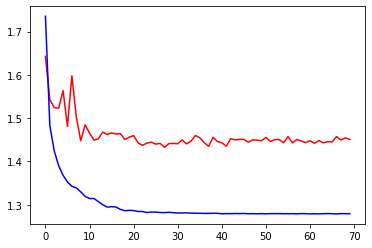

0.8344
Normalized confusion matrix


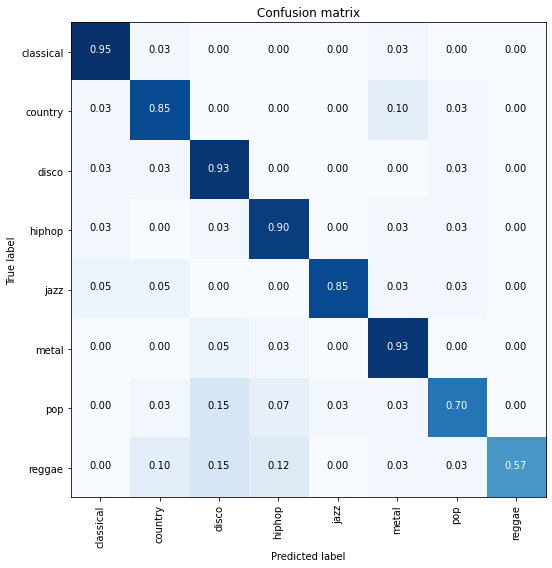

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3240] [Train Acc: 0.9561] [Valid Loss: 1.4624] [Valid Acc: 0.8125]
Epoch    12: reducing learning rate of group 0 to 3.0800e-03.
Epoch    16: reducing learning rate of group 0 to 2.1560e-03.
[Epoch 20/70] [Train Loss: 1.2915] [Train Acc: 0.9848] [Valid Loss: 1.4613] [Valid Acc: 0.8125]
Epoch    20: reducing learning rate of group 0 to 1.5092e-03.
Epoch    24: reducing learning rate of group 0 to 1.0564e-03.
Epoch    28: reducing learning rate of group 0 to 7.3951e-04.
[Epoch 30/70] [Train Loss: 1.2828] [Train Acc: 0.9920] [Valid Loss: 1.4761] [Valid Acc: 0.7875]
Epoch    32: reducing learning rate of group 0 to 5.1766e-04.
Epoch    36: reducing learning rate of group 0 to 3.6236e-04.
[Epoch 40/70] [Train Loss: 1.2811] [Train Acc: 0.9943] [Valid Loss: 1.4777] [Valid Acc: 0.7875]
Epoch    40: reducing learning rate of group 0 to 2.5365e-04.
Epoch    44: reducing learning rate of group 0 to 1.7756e-04.
Epoch    48: reducing learning rate of g

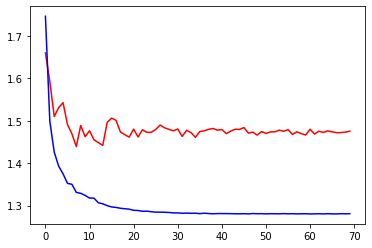

0.8094
Normalized confusion matrix


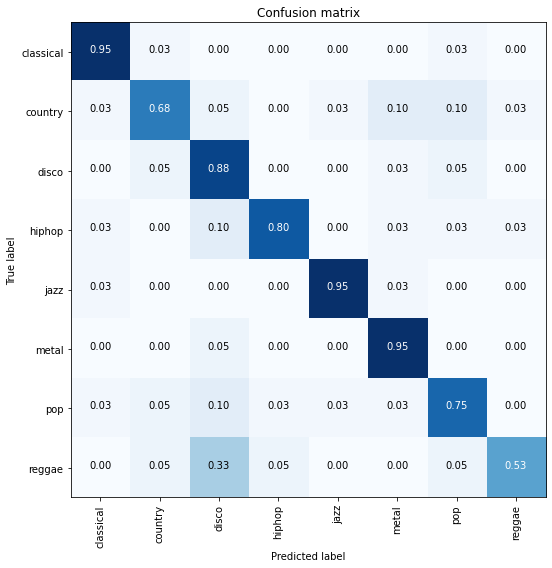

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3550] [Train Acc: 0.9200] [Valid Loss: 1.4906] [Valid Acc: 0.7812]
Epoch    18: reducing learning rate of group 0 to 1.4000e-02.
[Epoch 20/70] [Train Loss: 1.3128] [Train Acc: 0.9613] [Valid Loss: 1.4459] [Valid Acc: 0.8250]
Epoch    24: reducing learning rate of group 0 to 9.8000e-03.
[Epoch 30/70] [Train Loss: 1.2972] [Train Acc: 0.9773] [Valid Loss: 1.4521] [Valid Acc: 0.8187]
Epoch    33: reducing learning rate of group 0 to 6.8600e-03.
Epoch    37: reducing learning rate of group 0 to 4.8020e-03.
[Epoch 40/70] [Train Loss: 1.2895] [Train Acc: 0.9847] [Valid Loss: 1.4387] [Valid Acc: 0.8375]
Epoch    41: reducing learning rate of group 0 to 3.3614e-03.
Epoch    45: reducing learning rate of group 0 to 2.3530e-03.
Epoch    49: reducing learning rate of group 0 to 1.6471e-03.
[Epoch 50/70] [Train Loss: 1.2863] [Train Acc: 0.9875] [Valid Loss: 1.4437] [Valid Acc: 0.8187]
Epoch    53: reducing learning rate of group 0 to 1.1530e-03.
Epoch 

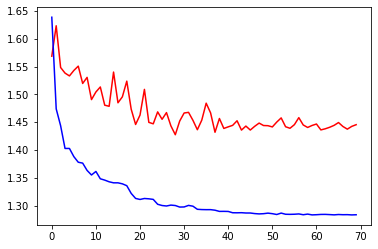

0.825
Normalized confusion matrix


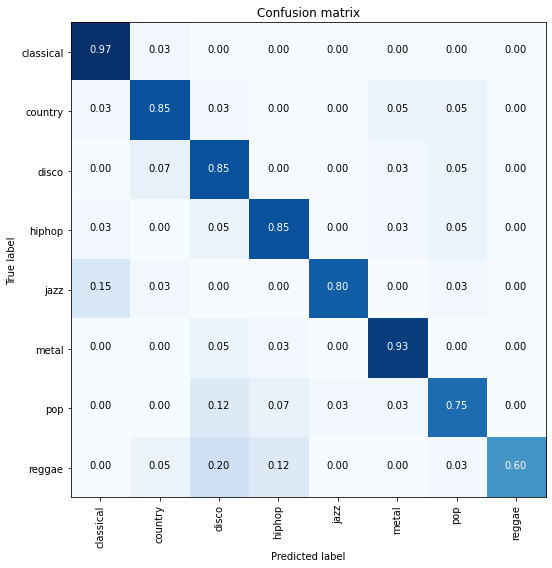

Training on GPU:0
Epoch     9: reducing learning rate of group 0 to 1.6800e-02.
[Epoch 10/70] [Train Loss: 1.3590] [Train Acc: 0.9154] [Valid Loss: 1.5078] [Valid Acc: 0.7688]
Epoch    13: reducing learning rate of group 0 to 1.1760e-02.
Epoch    17: reducing learning rate of group 0 to 8.2320e-03.
[Epoch 20/70] [Train Loss: 1.3115] [Train Acc: 0.9638] [Valid Loss: 1.5033] [Valid Acc: 0.7625]
Epoch    22: reducing learning rate of group 0 to 5.7624e-03.
[Epoch 30/70] [Train Loss: 1.2966] [Train Acc: 0.9779] [Valid Loss: 1.5014] [Valid Acc: 0.7625]
Epoch    30: reducing learning rate of group 0 to 4.0337e-03.
Epoch    34: reducing learning rate of group 0 to 2.8236e-03.
[Epoch 40/70] [Train Loss: 1.2904] [Train Acc: 0.9841] [Valid Loss: 1.4693] [Valid Acc: 0.8063]
Epoch    45: reducing learning rate of group 0 to 1.9765e-03.
Epoch    49: reducing learning rate of group 0 to 1.3836e-03.
[Epoch 50/70] [Train Loss: 1.2886] [Train Acc: 0.9854] [Valid Loss: 1.4962] [Valid Acc: 0.7875]
Epoch 

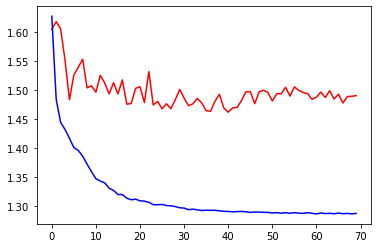

0.8031
Normalized confusion matrix


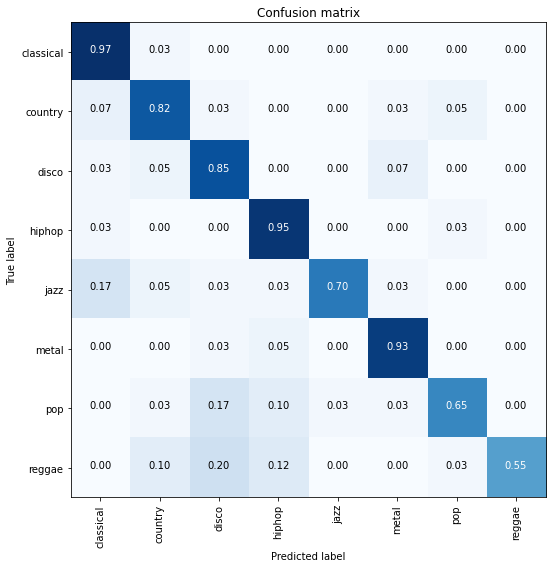

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3846] [Train Acc: 0.8896] [Valid Loss: 1.5242] [Valid Acc: 0.7500]
Epoch    11: reducing learning rate of group 0 to 1.9600e-02.
Epoch    15: reducing learning rate of group 0 to 1.3720e-02.
[Epoch 20/70] [Train Loss: 1.3293] [Train Acc: 0.9454] [Valid Loss: 1.5199] [Valid Acc: 0.7562]
Epoch    20: reducing learning rate of group 0 to 9.6040e-03.


KeyboardInterrupt: 

In [16]:
best=''
best_acc = 0

for lr in lrs :
    acc, path = run(lr,70,30)
    if acc > best_acc:
        best_acc = acc
        best =path
    gc.collect()
    torch.cuda.empty_cache() 
        
print(best)
print(best_acc)

In [17]:
best, best_acc

('./model_0.002_70_30', 0.85625)

In [ ]:
del train_loader
del valid_loader
del test_loader

gc.collect()
torch.cuda.empty_cache() 

In [10]:
lrs = [2.0,2.4,2.8,3.0, 3.2, 3.4, 3.6, 3.8, 4.0,4.2,4.4 ]
lrs = [i * 1e-3 for i in lrs] +[i*1e-2 for i in lrs]+[i*1e-4 for i in lrs] 

In [22]:
hparams.feature_path = 'feature0'

In [12]:
train_loader, valid_loader, test_loader = get_dataloader(hparams)

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.3058] [Train Acc: 0.9753] [Valid Loss: 1.5866] [Valid Acc: 0.6933]
Epoch    17: reducing learning rate of group 0 to 1.4000e-03.
[Epoch 20/80] [Train Loss: 1.2858] [Train Acc: 0.9897] [Valid Loss: 1.5604] [Valid Acc: 0.7133]
Epoch    25: reducing learning rate of group 0 to 9.8000e-04.
Epoch    29: reducing learning rate of group 0 to 6.8600e-04.
[Epoch 30/80] [Train Loss: 1.2824] [Train Acc: 0.9924] [Valid Loss: 1.5814] [Valid Acc: 0.6667]
Epoch    37: reducing learning rate of group 0 to 4.8020e-04.
[Epoch 40/80] [Train Loss: 1.2796] [Train Acc: 0.9958] [Valid Loss: 1.5409] [Valid Acc: 0.7400]
Epoch    41: reducing learning rate of group 0 to 3.3614e-04.
Epoch    45: reducing learning rate of group 0 to 2.3530e-04.
Epoch    49: reducing learning rate of group 0 to 1.6471e-04.
[Epoch 50/80] [Train Loss: 1.2788] [Train Acc: 0.9960] [Valid Loss: 1.5488] [Valid Acc: 0.7200]
Epoch    53: reducing learning rate of group 0 to 1.1530e-04.
Epoch 

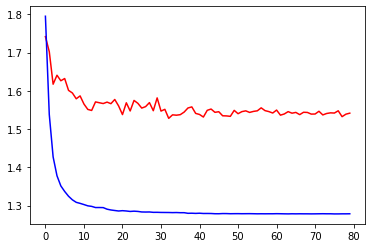

0.7427
Normalized confusion matrix


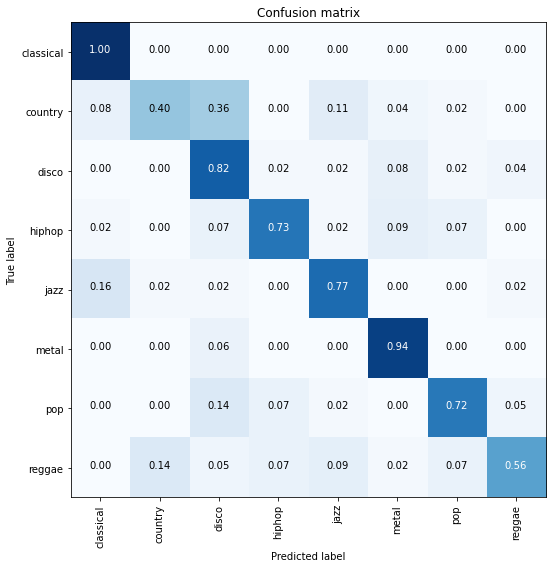

Training on GPU:0
Epoch     8: reducing learning rate of group 0 to 1.6800e-03.
[Epoch 10/80] [Train Loss: 1.3001] [Train Acc: 0.9787] [Valid Loss: 1.6154] [Valid Acc: 0.6533]
Epoch    12: reducing learning rate of group 0 to 1.1760e-03.
Epoch    16: reducing learning rate of group 0 to 8.2320e-04.
[Epoch 20/80] [Train Loss: 1.2863] [Train Acc: 0.9898] [Valid Loss: 1.5968] [Valid Acc: 0.6667]
Epoch    20: reducing learning rate of group 0 to 5.7624e-04.
Epoch    24: reducing learning rate of group 0 to 4.0337e-04.
Epoch    28: reducing learning rate of group 0 to 2.8236e-04.
[Epoch 30/80] [Train Loss: 1.2826] [Train Acc: 0.9929] [Valid Loss: 1.5970] [Valid Acc: 0.6667]
Epoch    32: reducing learning rate of group 0 to 1.9765e-04.
Epoch    36: reducing learning rate of group 0 to 1.3836e-04.
[Epoch 40/80] [Train Loss: 1.2825] [Train Acc: 0.9926] [Valid Loss: 1.5959] [Valid Acc: 0.6800]
Epoch    40: reducing learning rate of group 0 to 9.6849e-05.
Epoch    44: reducing learning rate of g

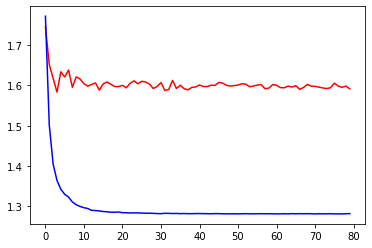

0.7374
Normalized confusion matrix


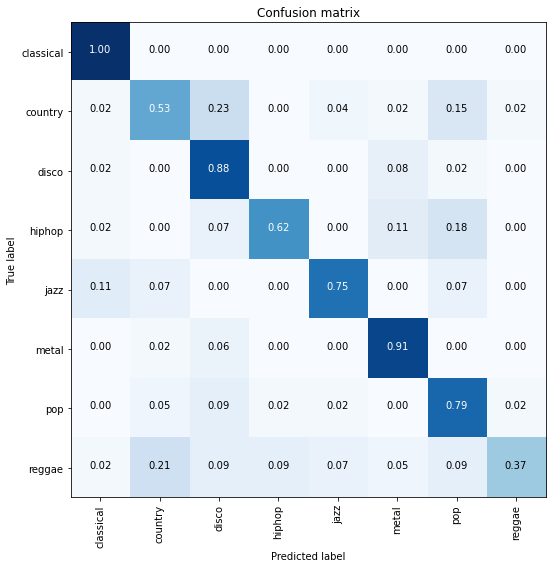

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.3008] [Train Acc: 0.9781] [Valid Loss: 1.5622] [Valid Acc: 0.7133]
Epoch    12: reducing learning rate of group 0 to 1.9600e-03.
[Epoch 20/80] [Train Loss: 1.2860] [Train Acc: 0.9901] [Valid Loss: 1.5660] [Valid Acc: 0.7067]
Epoch    22: reducing learning rate of group 0 to 1.3720e-03.
Epoch    26: reducing learning rate of group 0 to 9.6040e-04.
[Epoch 30/80] [Train Loss: 1.2816] [Train Acc: 0.9931] [Valid Loss: 1.5574] [Valid Acc: 0.7200]
Epoch    30: reducing learning rate of group 0 to 6.7228e-04.
Epoch    36: reducing learning rate of group 0 to 4.7060e-04.
[Epoch 40/80] [Train Loss: 1.2813] [Train Acc: 0.9935] [Valid Loss: 1.5384] [Valid Acc: 0.7333]
Epoch    41: reducing learning rate of group 0 to 3.2942e-04.
Epoch    45: reducing learning rate of group 0 to 2.3059e-04.
Epoch    49: reducing learning rate of group 0 to 1.6141e-04.
[Epoch 50/80] [Train Loss: 1.2808] [Train Acc: 0.9937] [Valid Loss: 1.5372] [Valid Acc: 0.7267]
Epoch 

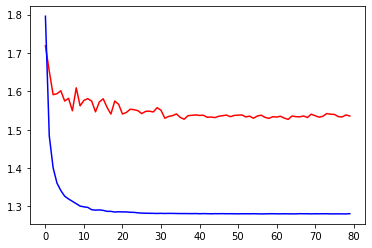

0.7533
Normalized confusion matrix


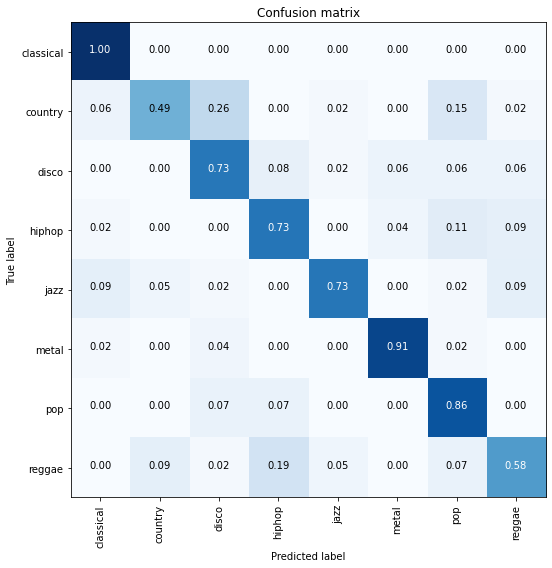

Training on GPU:0
Epoch     9: reducing learning rate of group 0 to 2.1000e-03.
[Epoch 10/80] [Train Loss: 1.2964] [Train Acc: 0.9818] [Valid Loss: 1.6100] [Valid Acc: 0.6600]
Epoch    13: reducing learning rate of group 0 to 1.4700e-03.
Epoch    17: reducing learning rate of group 0 to 1.0290e-03.
[Epoch 20/80] [Train Loss: 1.2842] [Train Acc: 0.9913] [Valid Loss: 1.5889] [Valid Acc: 0.6667]
Epoch    21: reducing learning rate of group 0 to 7.2030e-04.
Epoch    25: reducing learning rate of group 0 to 5.0421e-04.
Epoch    29: reducing learning rate of group 0 to 3.5295e-04.
[Epoch 30/80] [Train Loss: 1.2817] [Train Acc: 0.9934] [Valid Loss: 1.6016] [Valid Acc: 0.6733]
[Epoch 40/80] [Train Loss: 1.2816] [Train Acc: 0.9934] [Valid Loss: 1.5751] [Valid Acc: 0.6800]
Epoch    41: reducing learning rate of group 0 to 2.4706e-04.
Epoch    45: reducing learning rate of group 0 to 1.7294e-04.
Epoch    49: reducing learning rate of group 0 to 1.2106e-04.
[Epoch 50/80] [Train Loss: 1.2813] [Trai

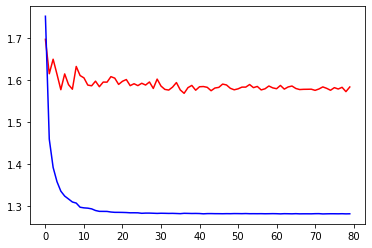

0.7294
Normalized confusion matrix


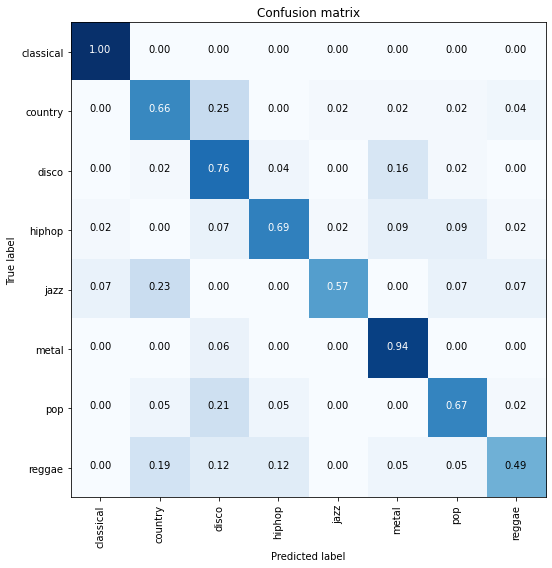

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.3005] [Train Acc: 0.9773] [Valid Loss: 1.6080] [Valid Acc: 0.6600]
Epoch    13: reducing learning rate of group 0 to 2.2400e-03.
Epoch    17: reducing learning rate of group 0 to 1.5680e-03.
[Epoch 20/80] [Train Loss: 1.2842] [Train Acc: 0.9905] [Valid Loss: 1.6097] [Valid Acc: 0.6467]
Epoch    21: reducing learning rate of group 0 to 1.0976e-03.
Epoch    25: reducing learning rate of group 0 to 7.6832e-04.
Epoch    29: reducing learning rate of group 0 to 5.3782e-04.
[Epoch 30/80] [Train Loss: 1.2817] [Train Acc: 0.9929] [Valid Loss: 1.5957] [Valid Acc: 0.6667]
Epoch    33: reducing learning rate of group 0 to 3.7648e-04.
Epoch    37: reducing learning rate of group 0 to 2.6353e-04.
[Epoch 40/80] [Train Loss: 1.2811] [Train Acc: 0.9933] [Valid Loss: 1.6006] [Valid Acc: 0.6667]
Epoch    41: reducing learning rate of group 0 to 1.8447e-04.
Epoch    45: reducing learning rate of group 0 to 1.2913e-04.
Epoch    49: reducing learning rate of g

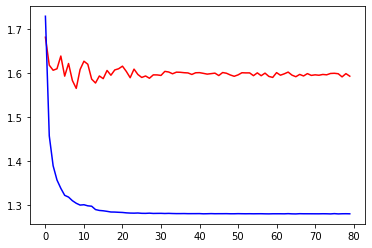

0.7401
Normalized confusion matrix


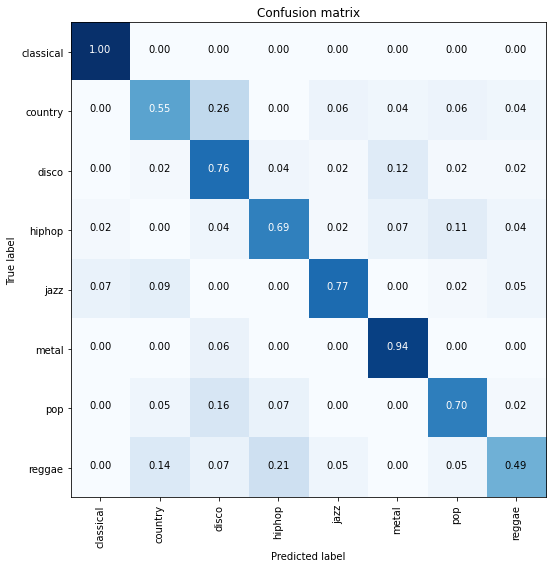

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.3003] [Train Acc: 0.9771] [Valid Loss: 1.6224] [Valid Acc: 0.6400]
Epoch    12: reducing learning rate of group 0 to 2.3800e-03.
Epoch    16: reducing learning rate of group 0 to 1.6660e-03.
[Epoch 20/80] [Train Loss: 1.2844] [Train Acc: 0.9906] [Valid Loss: 1.5977] [Valid Acc: 0.6667]
Epoch    20: reducing learning rate of group 0 to 1.1662e-03.
Epoch    24: reducing learning rate of group 0 to 8.1634e-04.
Epoch    28: reducing learning rate of group 0 to 5.7144e-04.
[Epoch 30/80] [Train Loss: 1.2818] [Train Acc: 0.9930] [Valid Loss: 1.5827] [Valid Acc: 0.6800]
Epoch    32: reducing learning rate of group 0 to 4.0001e-04.
Epoch    36: reducing learning rate of group 0 to 2.8000e-04.
[Epoch 40/80] [Train Loss: 1.2810] [Train Acc: 0.9936] [Valid Loss: 1.5868] [Valid Acc: 0.6800]
Epoch    40: reducing learning rate of group 0 to 1.9600e-04.
Epoch    44: reducing learning rate of group 0 to 1.3720e-04.
Epoch    48: reducing learning rate of g

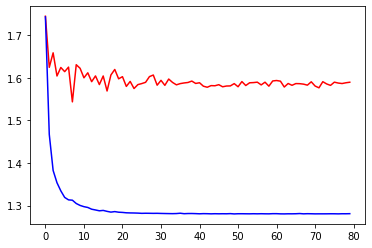

0.7347
Normalized confusion matrix


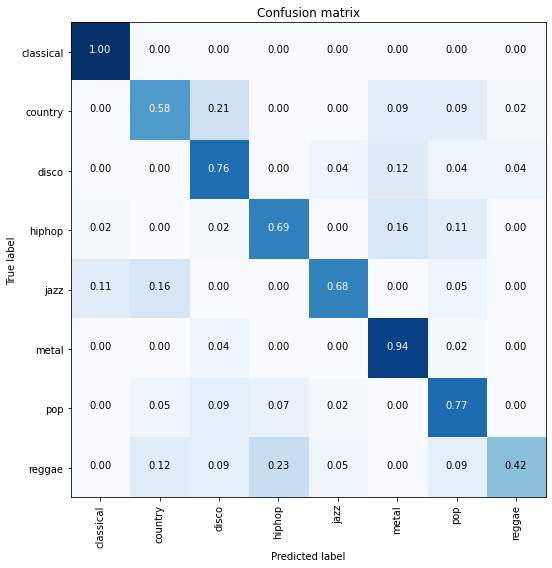

Training on GPU:0
Epoch     8: reducing learning rate of group 0 to 2.5200e-03.
[Epoch 10/80] [Train Loss: 1.2989] [Train Acc: 0.9794] [Valid Loss: 1.6118] [Valid Acc: 0.6467]
Epoch    12: reducing learning rate of group 0 to 1.7640e-03.
Epoch    17: reducing learning rate of group 0 to 1.2348e-03.
[Epoch 20/80] [Train Loss: 1.2838] [Train Acc: 0.9914] [Valid Loss: 1.6150] [Valid Acc: 0.6667]
Epoch    21: reducing learning rate of group 0 to 8.6436e-04.
Epoch    25: reducing learning rate of group 0 to 6.0505e-04.
Epoch    29: reducing learning rate of group 0 to 4.2354e-04.
[Epoch 30/80] [Train Loss: 1.2815] [Train Acc: 0.9931] [Valid Loss: 1.6176] [Valid Acc: 0.6533]
Epoch    33: reducing learning rate of group 0 to 2.9648e-04.
Epoch    37: reducing learning rate of group 0 to 2.0753e-04.
[Epoch 40/80] [Train Loss: 1.2812] [Train Acc: 0.9935] [Valid Loss: 1.6063] [Valid Acc: 0.6667]
Epoch    45: reducing learning rate of group 0 to 1.4527e-04.
Epoch    49: reducing learning rate of g

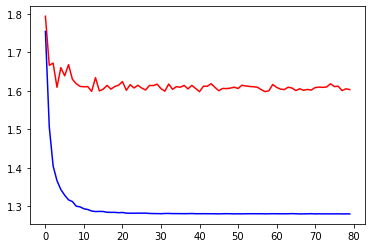

0.687
Normalized confusion matrix


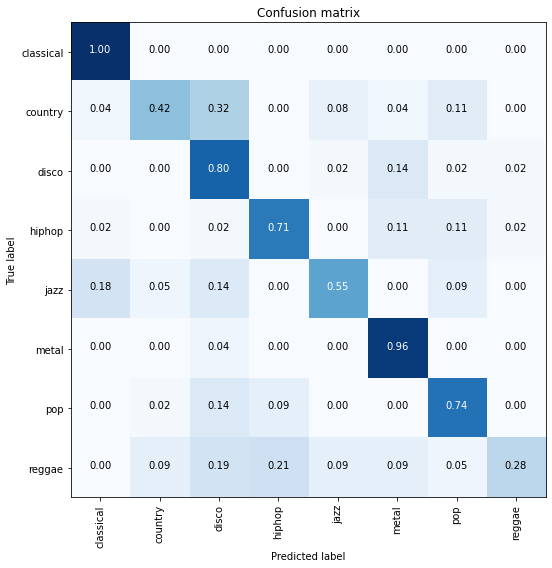

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.2992] [Train Acc: 0.9790] [Valid Loss: 1.6186] [Valid Acc: 0.6667]
Epoch    13: reducing learning rate of group 0 to 2.6600e-03.
Epoch    17: reducing learning rate of group 0 to 1.8620e-03.
[Epoch 20/80] [Train Loss: 1.2841] [Train Acc: 0.9914] [Valid Loss: 1.6159] [Valid Acc: 0.6600]
Epoch    21: reducing learning rate of group 0 to 1.3034e-03.
Epoch    25: reducing learning rate of group 0 to 9.1238e-04.
Epoch    29: reducing learning rate of group 0 to 6.3867e-04.
[Epoch 30/80] [Train Loss: 1.2816] [Train Acc: 0.9929] [Valid Loss: 1.5956] [Valid Acc: 0.6733]
Epoch    33: reducing learning rate of group 0 to 4.4707e-04.
Epoch    37: reducing learning rate of group 0 to 3.1295e-04.
[Epoch 40/80] [Train Loss: 1.2813] [Train Acc: 0.9929] [Valid Loss: 1.5974] [Valid Acc: 0.6667]
Epoch    41: reducing learning rate of group 0 to 2.1906e-04.
Epoch    45: reducing learning rate of group 0 to 1.5334e-04.
Epoch    49: reducing learning rate of g

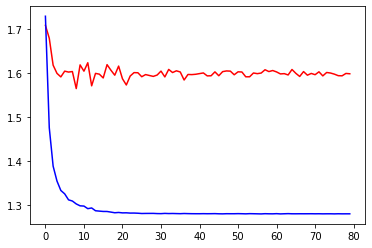

0.7241
Normalized confusion matrix


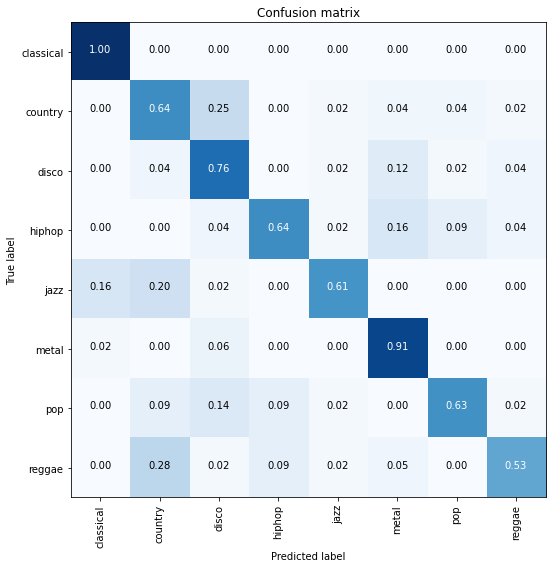

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.3023] [Train Acc: 0.9756] [Valid Loss: 1.5899] [Valid Acc: 0.6800]
Epoch    10: reducing learning rate of group 0 to 2.8000e-03.
Epoch    16: reducing learning rate of group 0 to 1.9600e-03.
[Epoch 20/80] [Train Loss: 1.2845] [Train Acc: 0.9909] [Valid Loss: 1.5662] [Valid Acc: 0.7000]
Epoch    20: reducing learning rate of group 0 to 1.3720e-03.
Epoch    24: reducing learning rate of group 0 to 9.6040e-04.
Epoch    28: reducing learning rate of group 0 to 6.7228e-04.
[Epoch 30/80] [Train Loss: 1.2817] [Train Acc: 0.9927] [Valid Loss: 1.5702] [Valid Acc: 0.7067]
Epoch    32: reducing learning rate of group 0 to 4.7060e-04.
Epoch    36: reducing learning rate of group 0 to 3.2942e-04.
[Epoch 40/80] [Train Loss: 1.2811] [Train Acc: 0.9937] [Valid Loss: 1.5762] [Valid Acc: 0.7000]
Epoch    40: reducing learning rate of group 0 to 2.3059e-04.
Epoch    44: reducing learning rate of group 0 to 1.6141e-04.
Epoch    48: reducing learning rate of g

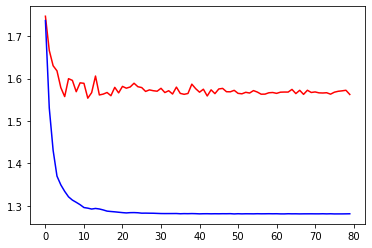

0.7294
Normalized confusion matrix


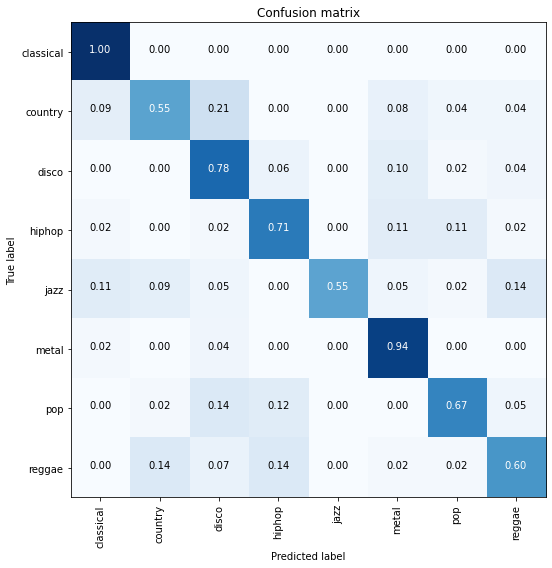

Training on GPU:0
Epoch     9: reducing learning rate of group 0 to 2.9400e-03.
[Epoch 10/80] [Train Loss: 1.2938] [Train Acc: 0.9825] [Valid Loss: 1.5580] [Valid Acc: 0.7200]
[Epoch 20/80] [Train Loss: 1.2850] [Train Acc: 0.9908] [Valid Loss: 1.5483] [Valid Acc: 0.7267]
Epoch    21: reducing learning rate of group 0 to 2.0580e-03.
Epoch    27: reducing learning rate of group 0 to 1.4406e-03.
[Epoch 30/80] [Train Loss: 1.2794] [Train Acc: 0.9950] [Valid Loss: 1.5578] [Valid Acc: 0.7267]
Epoch    31: reducing learning rate of group 0 to 1.0084e-03.
Epoch    37: reducing learning rate of group 0 to 7.0589e-04.
[Epoch 40/80] [Train Loss: 1.2781] [Train Acc: 0.9962] [Valid Loss: 1.5570] [Valid Acc: 0.7200]
Epoch    41: reducing learning rate of group 0 to 4.9413e-04.
Epoch    45: reducing learning rate of group 0 to 3.4589e-04.
Epoch    49: reducing learning rate of group 0 to 2.4212e-04.
[Epoch 50/80] [Train Loss: 1.2777] [Train Acc: 0.9968] [Valid Loss: 1.5437] [Valid Acc: 0.7267]
Epoch 

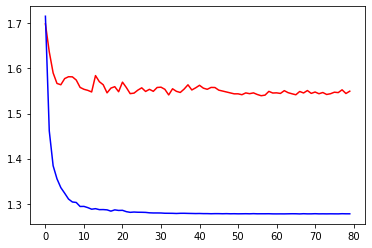

0.756
Normalized confusion matrix


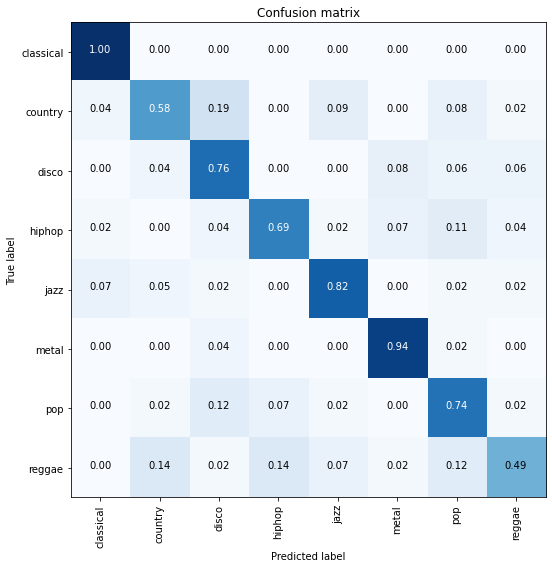

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.3007] [Train Acc: 0.9770] [Valid Loss: 1.6127] [Valid Acc: 0.6467]
Epoch    11: reducing learning rate of group 0 to 3.0800e-03.
Epoch    19: reducing learning rate of group 0 to 2.1560e-03.
[Epoch 20/80] [Train Loss: 1.2833] [Train Acc: 0.9917] [Valid Loss: 1.5639] [Valid Acc: 0.7133]
Epoch    23: reducing learning rate of group 0 to 1.5092e-03.
Epoch    27: reducing learning rate of group 0 to 1.0564e-03.
[Epoch 30/80] [Train Loss: 1.2809] [Train Acc: 0.9936] [Valid Loss: 1.5800] [Valid Acc: 0.6867]
Epoch    31: reducing learning rate of group 0 to 7.3951e-04.
Epoch    35: reducing learning rate of group 0 to 5.1766e-04.
Epoch    39: reducing learning rate of group 0 to 3.6236e-04.
[Epoch 40/80] [Train Loss: 1.2803] [Train Acc: 0.9941] [Valid Loss: 1.5716] [Valid Acc: 0.6933]
Epoch    43: reducing learning rate of group 0 to 2.5365e-04.
Epoch    47: reducing learning rate of group 0 to 1.7756e-04.
[Epoch 50/80] [Train Loss: 1.2802] [Trai

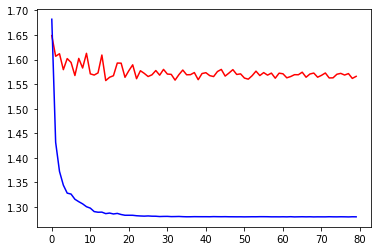

0.7666
Normalized confusion matrix


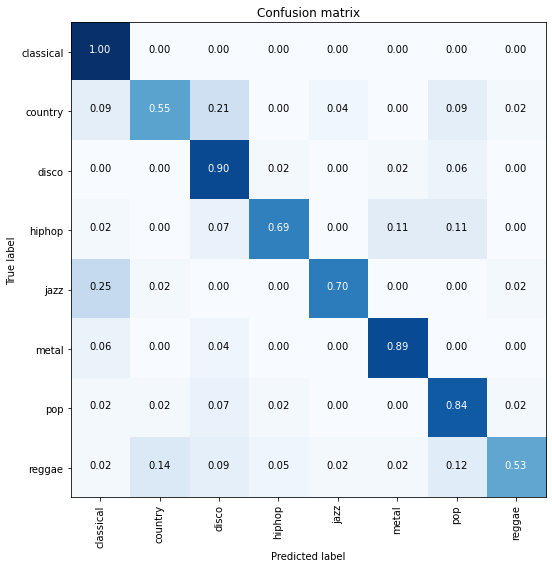

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.3290] [Train Acc: 0.9457] [Valid Loss: 1.5988] [Valid Acc: 0.6800]
Epoch    12: reducing learning rate of group 0 to 1.4000e-02.
Epoch    19: reducing learning rate of group 0 to 9.8000e-03.
[Epoch 20/80] [Train Loss: 1.2870] [Train Acc: 0.9873] [Valid Loss: 1.5556] [Valid Acc: 0.7133]
Epoch    23: reducing learning rate of group 0 to 6.8600e-03.
Epoch    27: reducing learning rate of group 0 to 4.8020e-03.
[Epoch 30/80] [Train Loss: 1.2831] [Train Acc: 0.9911] [Valid Loss: 1.5838] [Valid Acc: 0.6800]
Epoch    31: reducing learning rate of group 0 to 3.3614e-03.
Epoch    35: reducing learning rate of group 0 to 2.3530e-03.
Epoch    39: reducing learning rate of group 0 to 1.6471e-03.
[Epoch 40/80] [Train Loss: 1.2823] [Train Acc: 0.9918] [Valid Loss: 1.5696] [Valid Acc: 0.6933]
Epoch    43: reducing learning rate of group 0 to 1.1530e-03.
Epoch    47: reducing learning rate of group 0 to 8.0707e-04.
[Epoch 50/80] [Train Loss: 1.2822] [Trai

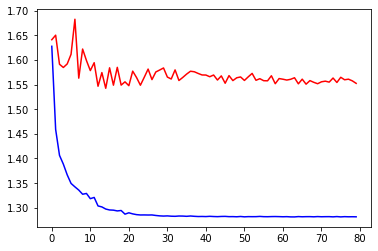

0.7427
Normalized confusion matrix


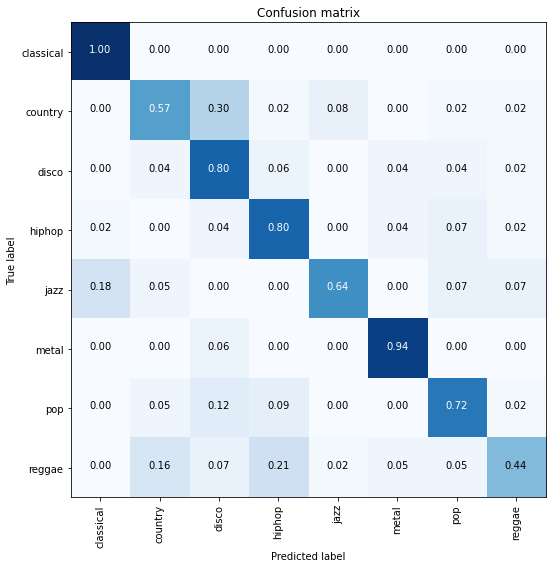

Training on GPU:0
Epoch     9: reducing learning rate of group 0 to 1.6800e-02.
[Epoch 10/80] [Train Loss: 1.3243] [Train Acc: 0.9496] [Valid Loss: 1.5716] [Valid Acc: 0.7000]
Epoch    15: reducing learning rate of group 0 to 1.1760e-02.
Epoch    19: reducing learning rate of group 0 to 8.2320e-03.
[Epoch 20/80] [Train Loss: 1.2904] [Train Acc: 0.9840] [Valid Loss: 1.5512] [Valid Acc: 0.7133]
Epoch    23: reducing learning rate of group 0 to 5.7624e-03.
Epoch    28: reducing learning rate of group 0 to 4.0337e-03.
[Epoch 30/80] [Train Loss: 1.2863] [Train Acc: 0.9880] [Valid Loss: 1.5698] [Valid Acc: 0.6933]
Epoch    32: reducing learning rate of group 0 to 2.8236e-03.
Epoch    36: reducing learning rate of group 0 to 1.9765e-03.
[Epoch 40/80] [Train Loss: 1.2852] [Train Acc: 0.9890] [Valid Loss: 1.5553] [Valid Acc: 0.7133]
Epoch    40: reducing learning rate of group 0 to 1.3836e-03.
Epoch    44: reducing learning rate of group 0 to 9.6849e-04.
Epoch    48: reducing learning rate of g

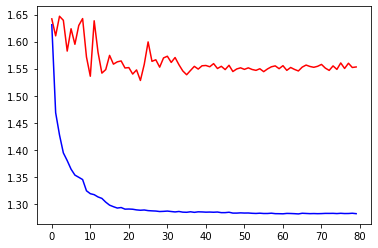

0.756
Normalized confusion matrix


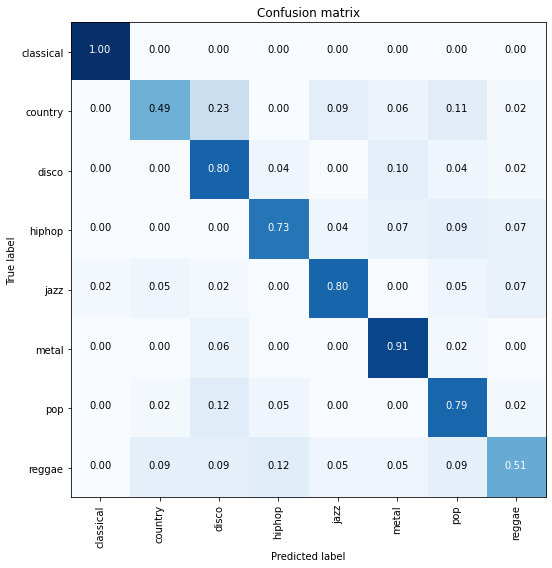

Training on GPU:0
Epoch     8: reducing learning rate of group 0 to 1.9600e-02.
[Epoch 10/80] [Train Loss: 1.3313] [Train Acc: 0.9432] [Valid Loss: 1.6152] [Valid Acc: 0.6467]
Epoch    12: reducing learning rate of group 0 to 1.3720e-02.
[Epoch 20/80] [Train Loss: 1.2994] [Train Acc: 0.9750] [Valid Loss: 1.5933] [Valid Acc: 0.6800]
Epoch    20: reducing learning rate of group 0 to 9.6040e-03.
Epoch    24: reducing learning rate of group 0 to 6.7228e-03.
Epoch    28: reducing learning rate of group 0 to 4.7060e-03.
[Epoch 30/80] [Train Loss: 1.2881] [Train Acc: 0.9858] [Valid Loss: 1.5828] [Valid Acc: 0.6867]
Epoch    32: reducing learning rate of group 0 to 3.2942e-03.
Epoch    36: reducing learning rate of group 0 to 2.3059e-03.
[Epoch 40/80] [Train Loss: 1.2843] [Train Acc: 0.9898] [Valid Loss: 1.5629] [Valid Acc: 0.7133]
Epoch    43: reducing learning rate of group 0 to 1.6141e-03.
Epoch    47: reducing learning rate of group 0 to 1.1299e-03.
[Epoch 50/80] [Train Loss: 1.2837] [Trai

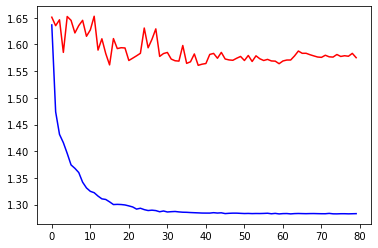

0.7639
Normalized confusion matrix


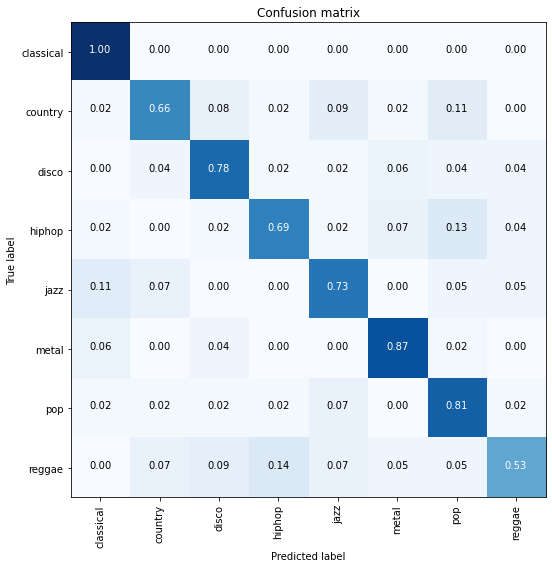

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.3400] [Train Acc: 0.9342] [Valid Loss: 1.5684] [Valid Acc: 0.7000]
Epoch    11: reducing learning rate of group 0 to 2.1000e-02.
Epoch    15: reducing learning rate of group 0 to 1.4700e-02.
Epoch    19: reducing learning rate of group 0 to 1.0290e-02.
[Epoch 20/80] [Train Loss: 1.2968] [Train Acc: 0.9774] [Valid Loss: 1.5794] [Valid Acc: 0.6867]
Epoch    23: reducing learning rate of group 0 to 7.2030e-03.
Epoch    27: reducing learning rate of group 0 to 5.0421e-03.
[Epoch 30/80] [Train Loss: 1.2861] [Train Acc: 0.9876] [Valid Loss: 1.5944] [Valid Acc: 0.6800]
Epoch    31: reducing learning rate of group 0 to 3.5295e-03.
Epoch    35: reducing learning rate of group 0 to 2.4706e-03.
Epoch    39: reducing learning rate of group 0 to 1.7294e-03.
[Epoch 40/80] [Train Loss: 1.2842] [Train Acc: 0.9898] [Valid Loss: 1.5831] [Valid Acc: 0.6933]
Epoch    43: reducing learning rate of group 0 to 1.2106e-03.
Epoch    47: reducing learning rate of g

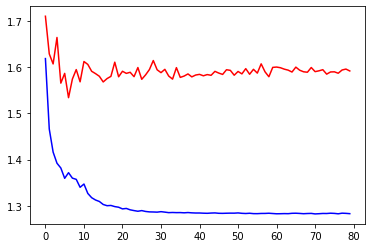

0.7109
Normalized confusion matrix


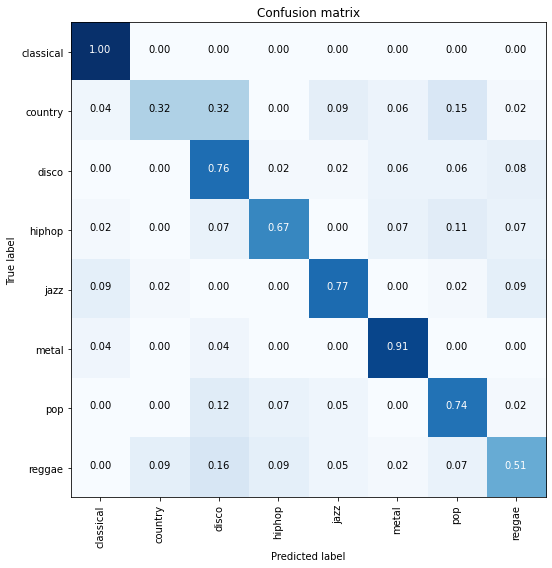

Training on GPU:0
Epoch     6: reducing learning rate of group 0 to 2.2400e-02.
[Epoch 10/80] [Train Loss: 1.4300] [Train Acc: 0.8439] [Valid Loss: 1.6483] [Valid Acc: 0.6200]
Epoch    13: reducing learning rate of group 0 to 1.5680e-02.
[Epoch 20/80] [Train Loss: 1.4024] [Train Acc: 0.8712] [Valid Loss: 1.6417] [Valid Acc: 0.6200]
Epoch    23: reducing learning rate of group 0 to 1.0976e-02.
Epoch    27: reducing learning rate of group 0 to 7.6832e-03.
[Epoch 30/80] [Train Loss: 1.3976] [Train Acc: 0.8760] [Valid Loss: 1.6433] [Valid Acc: 0.6333]
Epoch    31: reducing learning rate of group 0 to 5.3782e-03.
Epoch    35: reducing learning rate of group 0 to 3.7648e-03.
Epoch    39: reducing learning rate of group 0 to 2.6353e-03.
[Epoch 40/80] [Train Loss: 1.3960] [Train Acc: 0.8772] [Valid Loss: 1.6224] [Valid Acc: 0.6533]
Epoch    43: reducing learning rate of group 0 to 1.8447e-03.
Epoch    47: reducing learning rate of group 0 to 1.2913e-03.
[Epoch 50/80] [Train Loss: 1.3960] [Trai

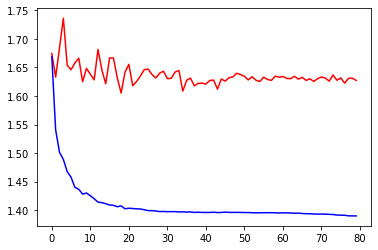

0.6578
Normalized confusion matrix


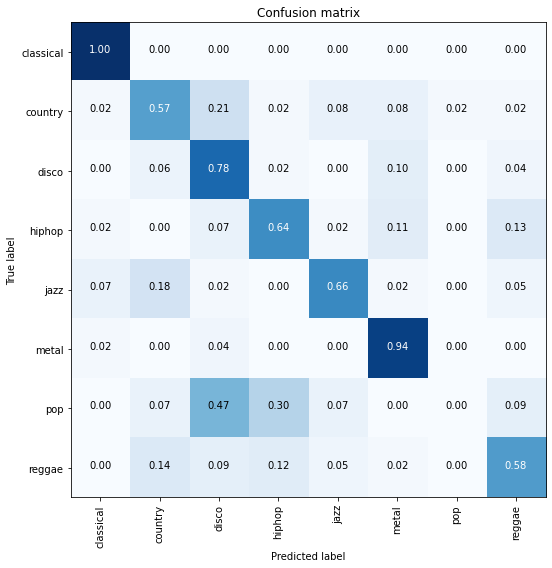

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.4459] [Train Acc: 0.8280] [Valid Loss: 1.6711] [Valid Acc: 0.6000]
Epoch    10: reducing learning rate of group 0 to 2.3800e-02.
Epoch    18: reducing learning rate of group 0 to 1.6660e-02.
[Epoch 20/80] [Train Loss: 1.4077] [Train Acc: 0.8656] [Valid Loss: 1.6035] [Valid Acc: 0.6733]
Epoch    23: reducing learning rate of group 0 to 1.1662e-02.
Epoch    27: reducing learning rate of group 0 to 8.1634e-03.
[Epoch 30/80] [Train Loss: 1.4011] [Train Acc: 0.8726] [Valid Loss: 1.6193] [Valid Acc: 0.6467]
Epoch    31: reducing learning rate of group 0 to 5.7144e-03.
Epoch    35: reducing learning rate of group 0 to 4.0001e-03.
Epoch    39: reducing learning rate of group 0 to 2.8000e-03.
[Epoch 40/80] [Train Loss: 1.3983] [Train Acc: 0.8747] [Valid Loss: 1.5902] [Valid Acc: 0.6800]
Epoch    43: reducing learning rate of group 0 to 1.9600e-03.
Epoch    47: reducing learning rate of group 0 to 1.3720e-03.
[Epoch 50/80] [Train Loss: 1.3978] [Trai

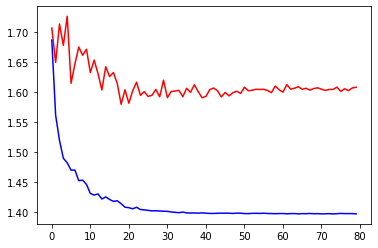

0.6737
Normalized confusion matrix


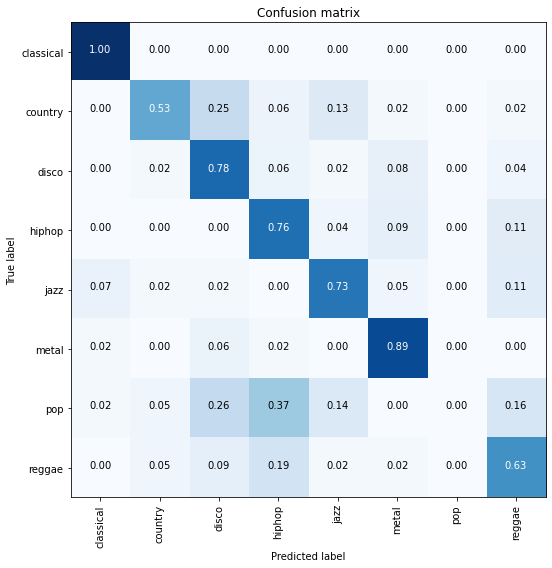

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.3764] [Train Acc: 0.8967] [Valid Loss: 1.5816] [Valid Acc: 0.6867]
Epoch    11: reducing learning rate of group 0 to 2.5200e-02.
Epoch    16: reducing learning rate of group 0 to 1.7640e-02.
[Epoch 20/80] [Train Loss: 1.3027] [Train Acc: 0.9711] [Valid Loss: 1.5793] [Valid Acc: 0.6933]
Epoch    20: reducing learning rate of group 0 to 1.2348e-02.
Epoch    24: reducing learning rate of group 0 to 8.6436e-03.
Epoch    28: reducing learning rate of group 0 to 6.0505e-03.
[Epoch 30/80] [Train Loss: 1.2895] [Train Acc: 0.9843] [Valid Loss: 1.5371] [Valid Acc: 0.7333]
Epoch    32: reducing learning rate of group 0 to 4.2354e-03.
Epoch    36: reducing learning rate of group 0 to 2.9648e-03.
[Epoch 40/80] [Train Loss: 1.2864] [Train Acc: 0.9876] [Valid Loss: 1.5519] [Valid Acc: 0.7133]
Epoch    40: reducing learning rate of group 0 to 2.0753e-03.
Epoch    44: reducing learning rate of group 0 to 1.4527e-03.
Epoch    48: reducing learning rate of g

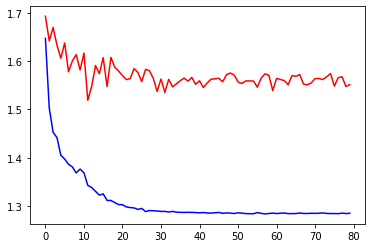

0.7401
Normalized confusion matrix


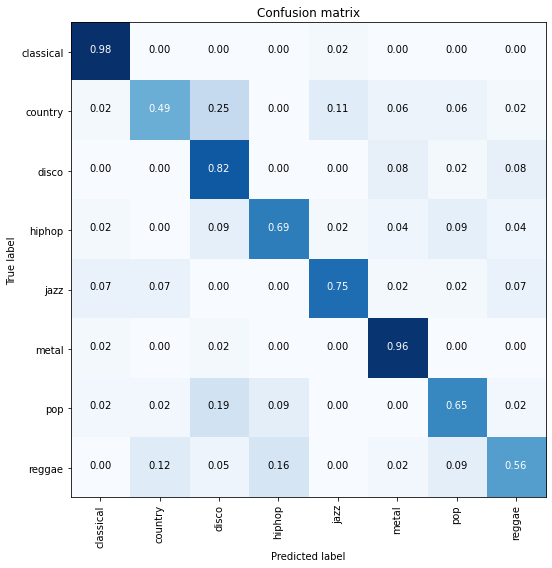

Training on GPU:0
Epoch     5: reducing learning rate of group 0 to 2.6600e-02.
[Epoch 10/80] [Train Loss: 1.4345] [Train Acc: 0.8394] [Valid Loss: 1.6827] [Valid Acc: 0.5933]
Epoch    12: reducing learning rate of group 0 to 1.8620e-02.
Epoch    16: reducing learning rate of group 0 to 1.3034e-02.
[Epoch 20/80] [Train Loss: 1.4075] [Train Acc: 0.8662] [Valid Loss: 1.6273] [Valid Acc: 0.6467]
Epoch    20: reducing learning rate of group 0 to 9.1238e-03.
Epoch    24: reducing learning rate of group 0 to 6.3867e-03.
Epoch    28: reducing learning rate of group 0 to 4.4707e-03.
[Epoch 30/80] [Train Loss: 1.4007] [Train Acc: 0.8730] [Valid Loss: 1.6501] [Valid Acc: 0.6200]
Epoch    32: reducing learning rate of group 0 to 3.1295e-03.
Epoch    36: reducing learning rate of group 0 to 2.1906e-03.
[Epoch 40/80] [Train Loss: 1.3993] [Train Acc: 0.8743] [Valid Loss: 1.6260] [Valid Acc: 0.6533]
Epoch    40: reducing learning rate of group 0 to 1.5334e-03.
Epoch    44: reducing learning rate of g

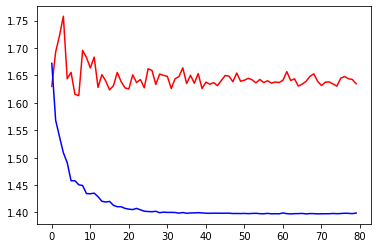

0.6711
Normalized confusion matrix


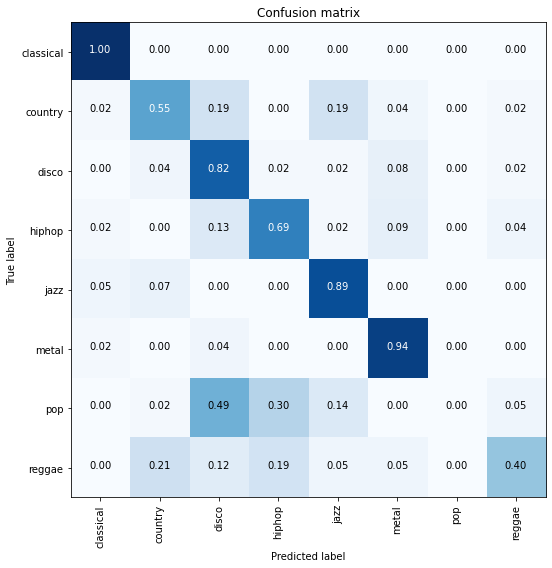

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.4620] [Train Acc: 0.8108] [Valid Loss: 1.6625] [Valid Acc: 0.6067]
Epoch    13: reducing learning rate of group 0 to 2.8000e-02.
[Epoch 20/80] [Train Loss: 1.4293] [Train Acc: 0.8443] [Valid Loss: 1.6712] [Valid Acc: 0.6000]
Epoch    21: reducing learning rate of group 0 to 1.9600e-02.
Epoch    25: reducing learning rate of group 0 to 1.3720e-02.
Epoch    29: reducing learning rate of group 0 to 9.6040e-03.
[Epoch 30/80] [Train Loss: 1.4052] [Train Acc: 0.8684] [Valid Loss: 1.6259] [Valid Acc: 0.6467]
Epoch    33: reducing learning rate of group 0 to 6.7228e-03.
Epoch    37: reducing learning rate of group 0 to 4.7060e-03.
[Epoch 40/80] [Train Loss: 1.4003] [Train Acc: 0.8737] [Valid Loss: 1.6212] [Valid Acc: 0.6467]
Epoch    41: reducing learning rate of group 0 to 3.2942e-03.
Epoch    47: reducing learning rate of group 0 to 2.3059e-03.
[Epoch 50/80] [Train Loss: 1.3994] [Train Acc: 0.8740] [Valid Loss: 1.6175] [Valid Acc: 0.6533]
Epoch 

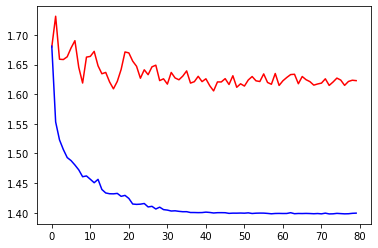

0.6499
Normalized confusion matrix


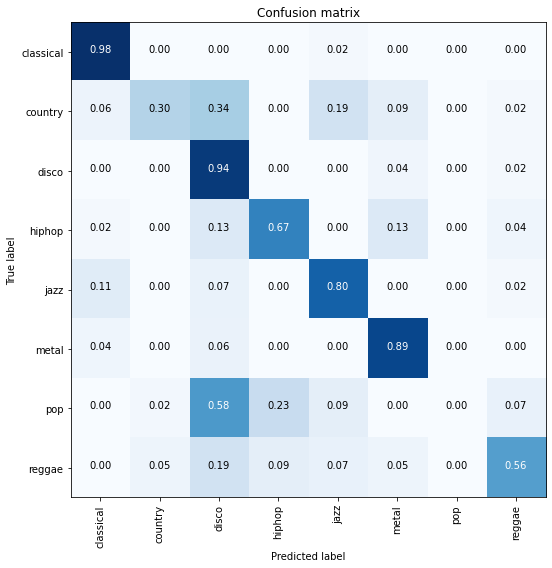

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.4246] [Train Acc: 0.8483] [Valid Loss: 1.6294] [Valid Acc: 0.6400]
Epoch    11: reducing learning rate of group 0 to 2.9400e-02.
[Epoch 20/80] [Train Loss: 1.3504] [Train Acc: 0.9236] [Valid Loss: 1.5580] [Valid Acc: 0.7133]
Epoch    25: reducing learning rate of group 0 to 2.0580e-02.
[Epoch 30/80] [Train Loss: 1.3238] [Train Acc: 0.9503] [Valid Loss: 1.5699] [Valid Acc: 0.7000]
Epoch    32: reducing learning rate of group 0 to 1.4406e-02.
Epoch    36: reducing learning rate of group 0 to 1.0084e-02.
[Epoch 40/80] [Train Loss: 1.3000] [Train Acc: 0.9736] [Valid Loss: 1.5446] [Valid Acc: 0.7267]
Epoch    40: reducing learning rate of group 0 to 7.0589e-03.
Epoch    44: reducing learning rate of group 0 to 4.9413e-03.
Epoch    48: reducing learning rate of group 0 to 3.4589e-03.
[Epoch 50/80] [Train Loss: 1.2930] [Train Acc: 0.9809] [Valid Loss: 1.5429] [Valid Acc: 0.7333]
Epoch    52: reducing learning rate of group 0 to 2.4212e-03.
Epoch 

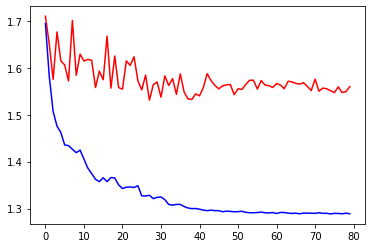

0.748
Normalized confusion matrix


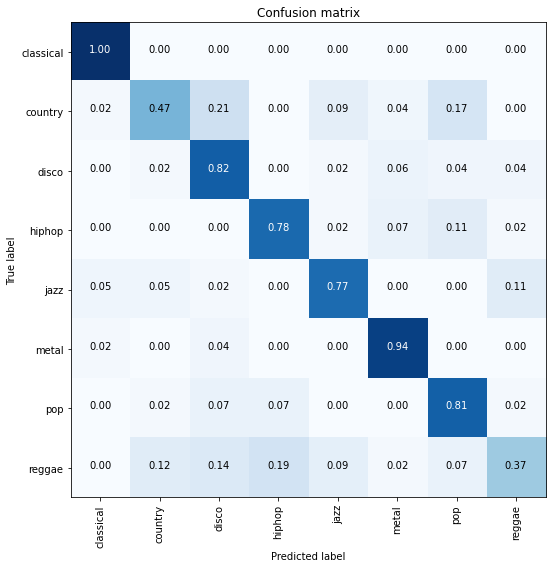

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.4732] [Train Acc: 0.7996] [Valid Loss: 1.6406] [Valid Acc: 0.6267]
Epoch    11: reducing learning rate of group 0 to 3.0800e-02.
Epoch    15: reducing learning rate of group 0 to 2.1560e-02.
[Epoch 20/80] [Train Loss: 1.4179] [Train Acc: 0.8557] [Valid Loss: 1.5769] [Valid Acc: 0.6933]
Epoch    24: reducing learning rate of group 0 to 1.5092e-02.
[Epoch 30/80] [Train Loss: 1.4093] [Train Acc: 0.8644] [Valid Loss: 1.6198] [Valid Acc: 0.6533]
Epoch    30: reducing learning rate of group 0 to 1.0564e-02.
Epoch    34: reducing learning rate of group 0 to 7.3951e-03.
Epoch    38: reducing learning rate of group 0 to 5.1766e-03.
[Epoch 40/80] [Train Loss: 1.4021] [Train Acc: 0.8714] [Valid Loss: 1.5925] [Valid Acc: 0.6933]
Epoch    42: reducing learning rate of group 0 to 3.6236e-03.
Epoch    46: reducing learning rate of group 0 to 2.5365e-03.
[Epoch 50/80] [Train Loss: 1.4007] [Train Acc: 0.8732] [Valid Loss: 1.5869] [Valid Acc: 0.6867]
Epoch 

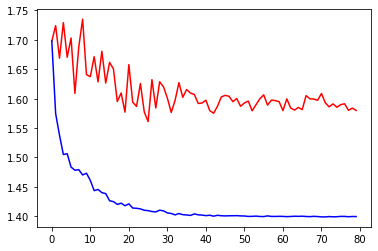

0.6631
Normalized confusion matrix


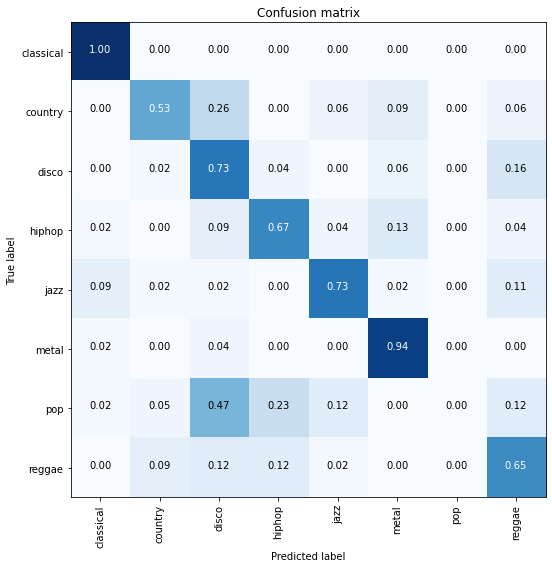

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.5879] [Train Acc: 0.7318] [Valid Loss: 1.7503] [Valid Acc: 0.5200]
[Epoch 20/80] [Train Loss: 1.4298] [Train Acc: 0.8902] [Valid Loss: 1.6844] [Valid Acc: 0.6133]
[Epoch 30/80] [Train Loss: 1.3390] [Train Acc: 0.9569] [Valid Loss: 1.6363] [Valid Acc: 0.6200]
Epoch    31: reducing learning rate of group 0 to 1.4000e-04.
Epoch    35: reducing learning rate of group 0 to 9.8000e-05.
Epoch    39: reducing learning rate of group 0 to 6.8600e-05.
[Epoch 40/80] [Train Loss: 1.3164] [Train Acc: 0.9730] [Valid Loss: 1.6528] [Valid Acc: 0.6200]
Epoch    43: reducing learning rate of group 0 to 4.8020e-05.
Epoch    48: reducing learning rate of group 0 to 3.3614e-05.
[Epoch 50/80] [Train Loss: 1.3085] [Train Acc: 0.9793] [Valid Loss: 1.6591] [Valid Acc: 0.6133]
Epoch    52: reducing learning rate of group 0 to 2.3530e-05.
Epoch    56: reducing learning rate of group 0 to 1.6471e-05.
[Epoch 60/80] [Train Loss: 1.3055] [Train Acc: 0.9808] [Valid Loss: 

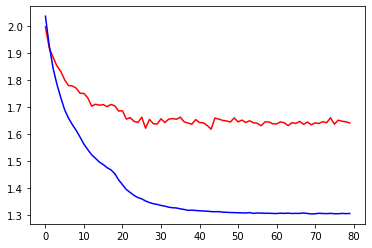

0.687
Normalized confusion matrix


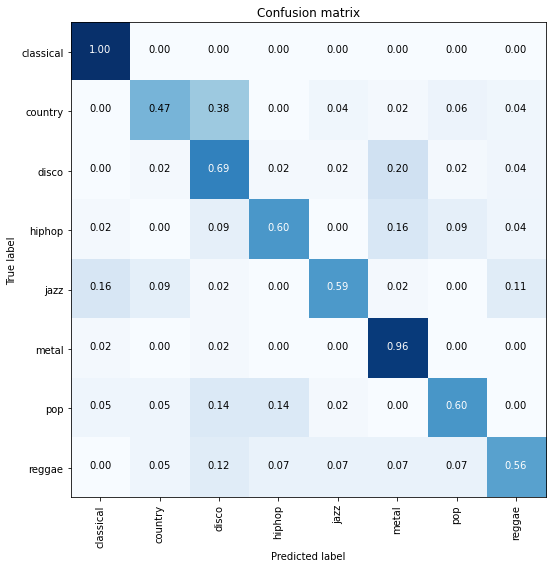

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.5318] [Train Acc: 0.7851] [Valid Loss: 1.7133] [Valid Acc: 0.5667]
[Epoch 20/80] [Train Loss: 1.3777] [Train Acc: 0.9320] [Valid Loss: 1.6454] [Valid Acc: 0.6267]
Epoch    22: reducing learning rate of group 0 to 1.6800e-04.
[Epoch 30/80] [Train Loss: 1.3248] [Train Acc: 0.9669] [Valid Loss: 1.6311] [Valid Acc: 0.6400]
Epoch    31: reducing learning rate of group 0 to 1.1760e-04.
Epoch    35: reducing learning rate of group 0 to 8.2320e-05.
Epoch    39: reducing learning rate of group 0 to 5.7624e-05.
[Epoch 40/80] [Train Loss: 1.3104] [Train Acc: 0.9777] [Valid Loss: 1.6156] [Valid Acc: 0.6667]
Epoch    43: reducing learning rate of group 0 to 4.0337e-05.
Epoch    47: reducing learning rate of group 0 to 2.8236e-05.
[Epoch 50/80] [Train Loss: 1.3041] [Train Acc: 0.9819] [Valid Loss: 1.6181] [Valid Acc: 0.6600]
Epoch    51: reducing learning rate of group 0 to 1.9765e-05.
Epoch    55: reducing learning rate of group 0 to 1.3836e-05.
Epoch 

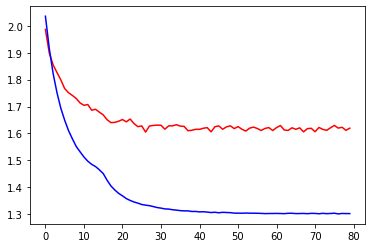

0.7374
Normalized confusion matrix


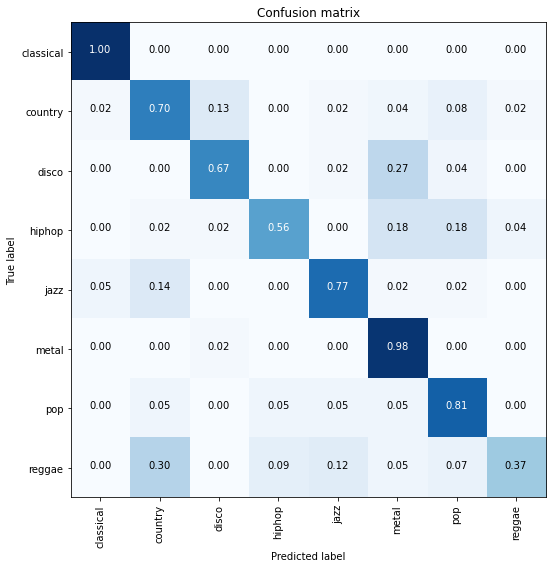

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.5241] [Train Acc: 0.8246] [Valid Loss: 1.7000] [Valid Acc: 0.6200]
[Epoch 20/80] [Train Loss: 1.3493] [Train Acc: 0.9473] [Valid Loss: 1.6344] [Valid Acc: 0.6533]
Epoch    22: reducing learning rate of group 0 to 1.9600e-04.
Epoch    27: reducing learning rate of group 0 to 1.3720e-04.
[Epoch 30/80] [Train Loss: 1.3134] [Train Acc: 0.9737] [Valid Loss: 1.6062] [Valid Acc: 0.6933]
Epoch    34: reducing learning rate of group 0 to 9.6040e-05.
Epoch    39: reducing learning rate of group 0 to 6.7228e-05.
[Epoch 40/80] [Train Loss: 1.3022] [Train Acc: 0.9832] [Valid Loss: 1.6180] [Valid Acc: 0.6600]
Epoch    45: reducing learning rate of group 0 to 4.7060e-05.
Epoch    49: reducing learning rate of group 0 to 3.2942e-05.
[Epoch 50/80] [Train Loss: 1.2990] [Train Acc: 0.9844] [Valid Loss: 1.5951] [Valid Acc: 0.6733]
Epoch    53: reducing learning rate of group 0 to 2.3059e-05.
Epoch    57: reducing learning rate of group 0 to 1.6141e-05.
[Epoch

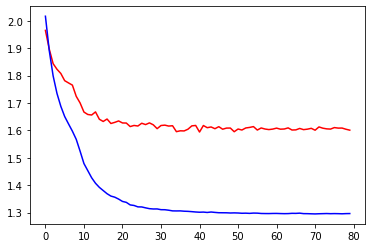

0.7082
Normalized confusion matrix


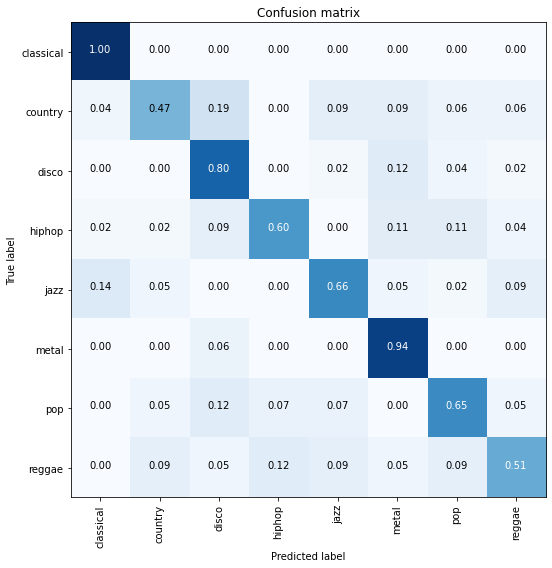

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.4456] [Train Acc: 0.8801] [Valid Loss: 1.6965] [Valid Acc: 0.5800]
[Epoch 20/80] [Train Loss: 1.3298] [Train Acc: 0.9610] [Valid Loss: 1.6555] [Valid Acc: 0.6200]
[Epoch 30/80] [Train Loss: 1.3041] [Train Acc: 0.9798] [Valid Loss: 1.6489] [Valid Acc: 0.6400]
Epoch    30: reducing learning rate of group 0 to 2.1000e-04.
Epoch    34: reducing learning rate of group 0 to 1.4700e-04.
Epoch    38: reducing learning rate of group 0 to 1.0290e-04.
[Epoch 40/80] [Train Loss: 1.2933] [Train Acc: 0.9873] [Valid Loss: 1.6530] [Valid Acc: 0.6200]
Epoch    42: reducing learning rate of group 0 to 7.2030e-05.
Epoch    46: reducing learning rate of group 0 to 5.0421e-05.
[Epoch 50/80] [Train Loss: 1.2910] [Train Acc: 0.9884] [Valid Loss: 1.6303] [Valid Acc: 0.6467]
Epoch    50: reducing learning rate of group 0 to 3.5295e-05.
Epoch    54: reducing learning rate of group 0 to 2.4706e-05.
Epoch    58: reducing learning rate of group 0 to 1.7294e-05.
[Epoch

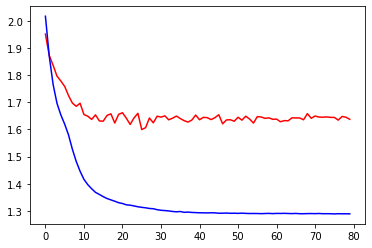

0.6711
Normalized confusion matrix


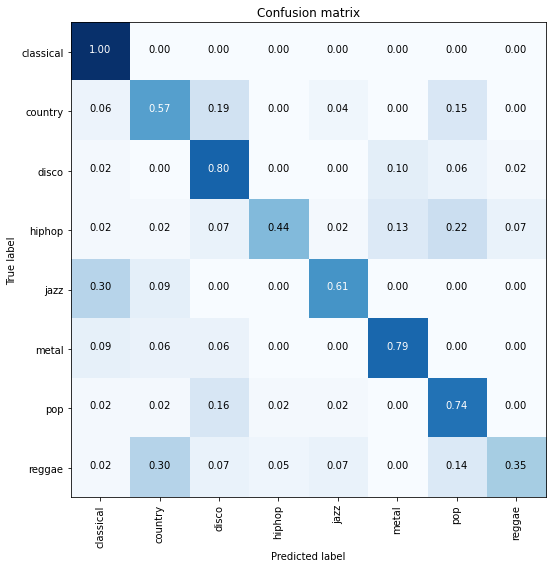

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.5050] [Train Acc: 0.8420] [Valid Loss: 1.6425] [Valid Acc: 0.6733]
[Epoch 20/80] [Train Loss: 1.3356] [Train Acc: 0.9578] [Valid Loss: 1.5578] [Valid Acc: 0.7400]
Epoch    24: reducing learning rate of group 0 to 2.2400e-04.
Epoch    29: reducing learning rate of group 0 to 1.5680e-04.
[Epoch 30/80] [Train Loss: 1.3063] [Train Acc: 0.9791] [Valid Loss: 1.5688] [Valid Acc: 0.7267]
Epoch    33: reducing learning rate of group 0 to 1.0976e-04.
Epoch    37: reducing learning rate of group 0 to 7.6832e-05.
[Epoch 40/80] [Train Loss: 1.2970] [Train Acc: 0.9862] [Valid Loss: 1.5591] [Valid Acc: 0.7400]
Epoch    41: reducing learning rate of group 0 to 5.3782e-05.
Epoch    45: reducing learning rate of group 0 to 3.7648e-05.
Epoch    49: reducing learning rate of group 0 to 2.6353e-05.
[Epoch 50/80] [Train Loss: 1.2963] [Train Acc: 0.9857] [Valid Loss: 1.5576] [Valid Acc: 0.7400]
Epoch    56: reducing learning rate of group 0 to 1.8447e-05.
[Epoch

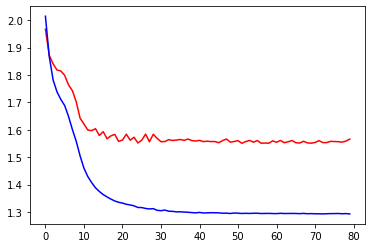

0.7347
Normalized confusion matrix


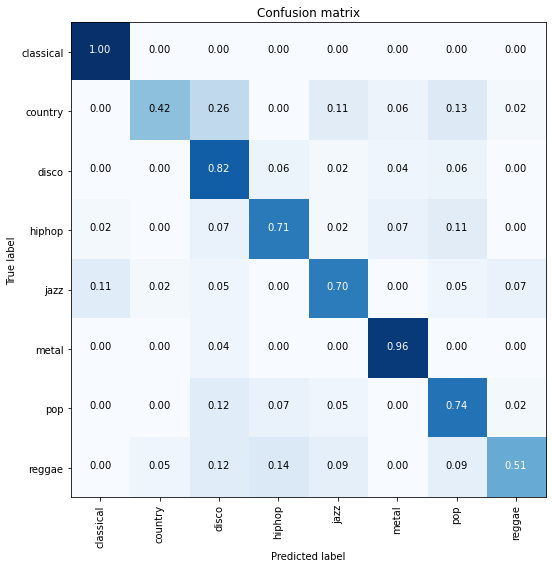

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.4674] [Train Acc: 0.8615] [Valid Loss: 1.6184] [Valid Acc: 0.6733]
Epoch    18: reducing learning rate of group 0 to 2.3800e-04.
[Epoch 20/80] [Train Loss: 1.3384] [Train Acc: 0.9546] [Valid Loss: 1.6130] [Valid Acc: 0.6533]
Epoch    22: reducing learning rate of group 0 to 1.6660e-04.
Epoch    26: reducing learning rate of group 0 to 1.1662e-04.
[Epoch 30/80] [Train Loss: 1.3131] [Train Acc: 0.9756] [Valid Loss: 1.6116] [Valid Acc: 0.6600]
Epoch    32: reducing learning rate of group 0 to 8.1634e-05.
Epoch    36: reducing learning rate of group 0 to 5.7144e-05.
[Epoch 40/80] [Train Loss: 1.3052] [Train Acc: 0.9807] [Valid Loss: 1.6033] [Valid Acc: 0.6800]
Epoch    40: reducing learning rate of group 0 to 4.0001e-05.
Epoch    44: reducing learning rate of group 0 to 2.8000e-05.
Epoch    49: reducing learning rate of group 0 to 1.9600e-05.
[Epoch 50/80] [Train Loss: 1.3026] [Train Acc: 0.9829] [Valid Loss: 1.5996] [Valid Acc: 0.6733]
Epoch 

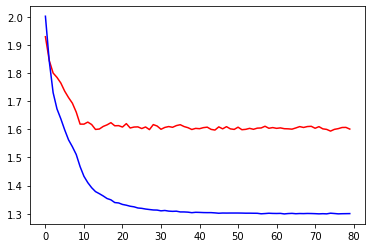

0.7029
Normalized confusion matrix


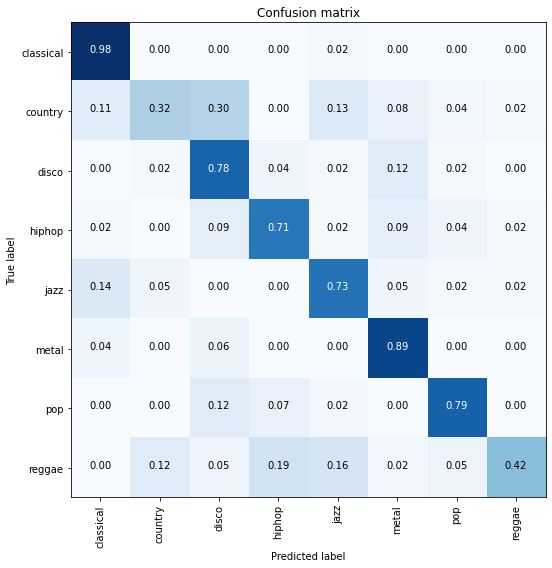

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.4228] [Train Acc: 0.8927] [Valid Loss: 1.6551] [Valid Acc: 0.6333]
Epoch    16: reducing learning rate of group 0 to 2.5200e-04.
[Epoch 20/80] [Train Loss: 1.3249] [Train Acc: 0.9653] [Valid Loss: 1.6153] [Valid Acc: 0.6733]
Epoch    21: reducing learning rate of group 0 to 1.7640e-04.
Epoch    26: reducing learning rate of group 0 to 1.2348e-04.
[Epoch 30/80] [Train Loss: 1.3054] [Train Acc: 0.9791] [Valid Loss: 1.5948] [Valid Acc: 0.6800]
Epoch    34: reducing learning rate of group 0 to 8.6436e-05.
Epoch    39: reducing learning rate of group 0 to 6.0505e-05.
[Epoch 40/80] [Train Loss: 1.2993] [Train Acc: 0.9848] [Valid Loss: 1.6058] [Valid Acc: 0.6800]
Epoch    43: reducing learning rate of group 0 to 4.2354e-05.
Epoch    47: reducing learning rate of group 0 to 2.9648e-05.
[Epoch 50/80] [Train Loss: 1.2959] [Train Acc: 0.9859] [Valid Loss: 1.6044] [Valid Acc: 0.6800]
Epoch    51: reducing learning rate of group 0 to 2.0753e-05.
Epoch 

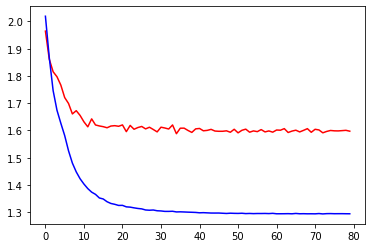

0.695
Normalized confusion matrix


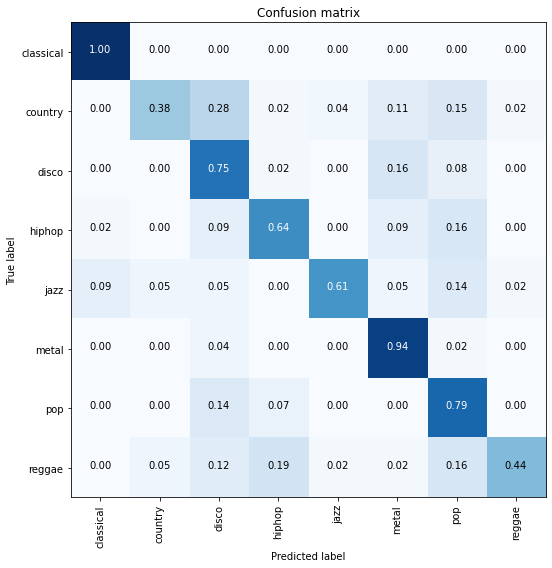

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.4682] [Train Acc: 0.8429] [Valid Loss: 1.6944] [Valid Acc: 0.6000]
[Epoch 20/80] [Train Loss: 1.3262] [Train Acc: 0.9640] [Valid Loss: 1.6564] [Valid Acc: 0.6000]
Epoch    23: reducing learning rate of group 0 to 2.6600e-04.
Epoch    27: reducing learning rate of group 0 to 1.8620e-04.
[Epoch 30/80] [Train Loss: 1.3009] [Train Acc: 0.9825] [Valid Loss: 1.6336] [Valid Acc: 0.6333]
Epoch    31: reducing learning rate of group 0 to 1.3034e-04.
Epoch    35: reducing learning rate of group 0 to 9.1238e-05.
Epoch    39: reducing learning rate of group 0 to 6.3867e-05.
[Epoch 40/80] [Train Loss: 1.2954] [Train Acc: 0.9858] [Valid Loss: 1.6463] [Valid Acc: 0.6133]
Epoch    43: reducing learning rate of group 0 to 4.4707e-05.
Epoch    47: reducing learning rate of group 0 to 3.1295e-05.
[Epoch 50/80] [Train Loss: 1.2919] [Train Acc: 0.9890] [Valid Loss: 1.6225] [Valid Acc: 0.6600]
Epoch    52: reducing learning rate of group 0 to 2.1906e-05.
Epoch 

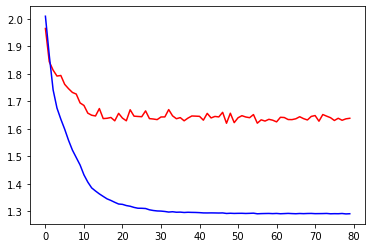

0.6658
Normalized confusion matrix


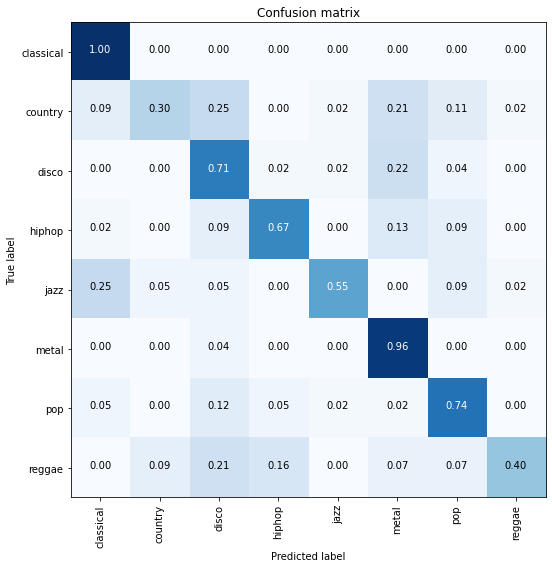

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.4089] [Train Acc: 0.9031] [Valid Loss: 1.6162] [Valid Acc: 0.6867]
[Epoch 20/80] [Train Loss: 1.3202] [Train Acc: 0.9686] [Valid Loss: 1.5881] [Valid Acc: 0.7000]
Epoch    21: reducing learning rate of group 0 to 2.8000e-04.
Epoch    25: reducing learning rate of group 0 to 1.9600e-04.
Epoch    29: reducing learning rate of group 0 to 1.3720e-04.
[Epoch 30/80] [Train Loss: 1.2961] [Train Acc: 0.9856] [Valid Loss: 1.5907] [Valid Acc: 0.6867]
Epoch    38: reducing learning rate of group 0 to 9.6040e-05.
[Epoch 40/80] [Train Loss: 1.2935] [Train Acc: 0.9873] [Valid Loss: 1.5988] [Valid Acc: 0.6867]
Epoch    43: reducing learning rate of group 0 to 6.7228e-05.
Epoch    47: reducing learning rate of group 0 to 4.7060e-05.
[Epoch 50/80] [Train Loss: 1.2918] [Train Acc: 0.9880] [Valid Loss: 1.5761] [Valid Acc: 0.7067]
Epoch    51: reducing learning rate of group 0 to 3.2942e-05.
Epoch    55: reducing learning rate of group 0 to 2.3059e-05.
Epoch 

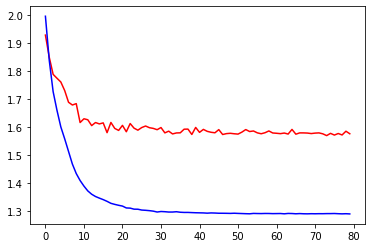

0.7162
Normalized confusion matrix


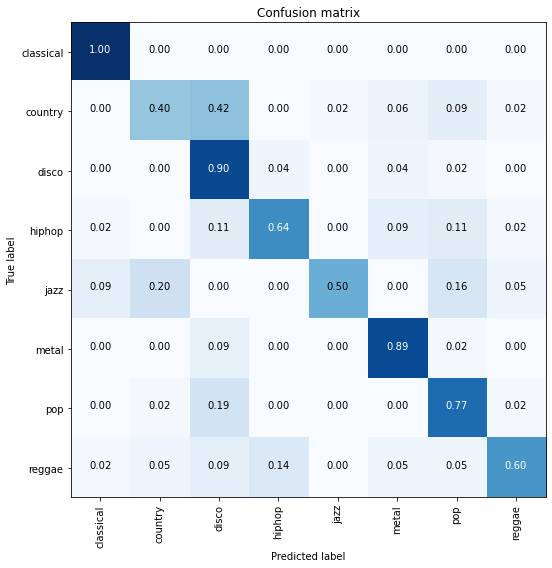

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.4280] [Train Acc: 0.8960] [Valid Loss: 1.6675] [Valid Acc: 0.6267]
[Epoch 20/80] [Train Loss: 1.3215] [Train Acc: 0.9674] [Valid Loss: 1.6629] [Valid Acc: 0.6067]
Epoch    22: reducing learning rate of group 0 to 2.9400e-04.
[Epoch 30/80] [Train Loss: 1.2988] [Train Acc: 0.9829] [Valid Loss: 1.6323] [Valid Acc: 0.6333]
Epoch    30: reducing learning rate of group 0 to 2.0580e-04.
Epoch    34: reducing learning rate of group 0 to 1.4406e-04.
[Epoch 40/80] [Train Loss: 1.2922] [Train Acc: 0.9878] [Valid Loss: 1.6357] [Valid Acc: 0.6333]
Epoch    40: reducing learning rate of group 0 to 1.0084e-04.
Epoch    44: reducing learning rate of group 0 to 7.0589e-05.
Epoch    48: reducing learning rate of group 0 to 4.9413e-05.
[Epoch 50/80] [Train Loss: 1.2883] [Train Acc: 0.9914] [Valid Loss: 1.6074] [Valid Acc: 0.6600]
Epoch    54: reducing learning rate of group 0 to 3.4589e-05.
Epoch    58: reducing learning rate of group 0 to 2.4212e-05.
[Epoch

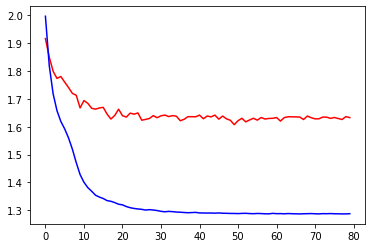

0.7003
Normalized confusion matrix


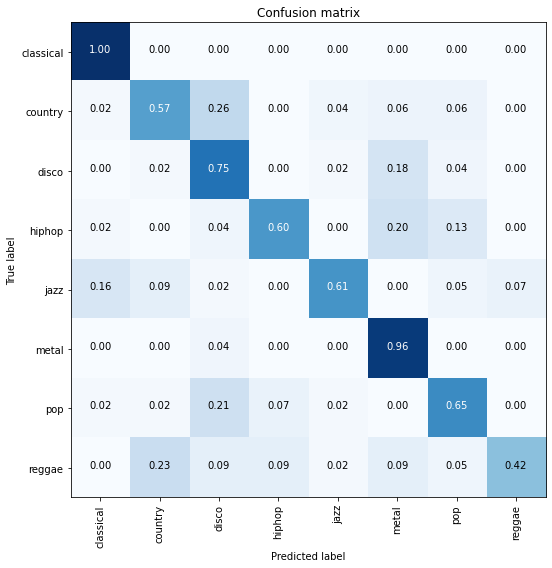

Training on GPU:0
[Epoch 10/80] [Train Loss: 1.4080] [Train Acc: 0.9097] [Valid Loss: 1.6260] [Valid Acc: 0.6533]
Epoch    16: reducing learning rate of group 0 to 3.0800e-04.
[Epoch 20/80] [Train Loss: 1.3120] [Train Acc: 0.9755] [Valid Loss: 1.6325] [Valid Acc: 0.6400]
Epoch    21: reducing learning rate of group 0 to 2.1560e-04.
Epoch    28: reducing learning rate of group 0 to 1.5092e-04.
[Epoch 30/80] [Train Loss: 1.2985] [Train Acc: 0.9839] [Valid Loss: 1.6167] [Valid Acc: 0.6733]
Epoch    32: reducing learning rate of group 0 to 1.0564e-04.
Epoch    36: reducing learning rate of group 0 to 7.3951e-05.
[Epoch 40/80] [Train Loss: 1.2927] [Train Acc: 0.9881] [Valid Loss: 1.6097] [Valid Acc: 0.6800]
Epoch    40: reducing learning rate of group 0 to 5.1766e-05.
Epoch    44: reducing learning rate of group 0 to 3.6236e-05.
Epoch    48: reducing learning rate of group 0 to 2.5365e-05.
[Epoch 50/80] [Train Loss: 1.2914] [Train Acc: 0.9887] [Valid Loss: 1.6291] [Valid Acc: 0.6533]
Epoch 

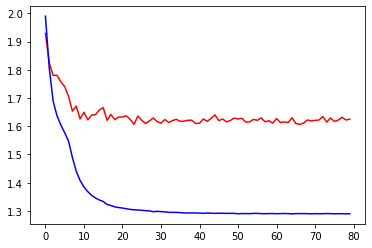

0.695
Normalized confusion matrix


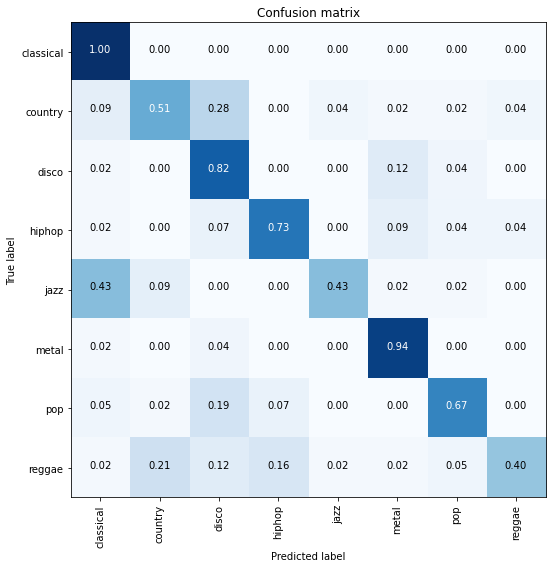

./model_0.0044_80_30
0.801762114537445


In [23]:
best=''
best_acc = 0

for lr in lrs :
    acc, path = run(lr,80,30)
    if acc > best_acc:
        best_acc = acc
        best =path
    gc.collect()
    torch.cuda.empty_cache() 
        
print(best)
print(best_acc)

### Best for Feature0

#### ./model_0.0044_80_30
#### 0.801762114537445

In [ ]:
del train_loader
del valid_loader
del test_loader

gc.collect()
torch.cuda.empty_cache() 

In [51]:
lrs = [2.0,2.4,2.8,3.0, 3.2, 3.4, 3.6, 3.8, 4.0,4.2,4.4 ]
lrs = [i*1e-2 for i in lrs]+[i*1e-4 for i in lrs] 

In [27]:
hparams.feature_path = 'feature6'
train_loader, valid_loader, test_loader = get_dataloader(hparams)

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3640] [Train Acc: 0.9102] [Valid Loss: 1.4812] [Valid Acc: 0.7937]
Epoch    12: reducing learning rate of group 0 to 1.4000e-02.
[Epoch 20/70] [Train Loss: 1.3141] [Train Acc: 0.9606] [Valid Loss: 1.4289] [Valid Acc: 0.8438]
Epoch    24: reducing learning rate of group 0 to 9.8000e-03.
Epoch    28: reducing learning rate of group 0 to 6.8600e-03.
[Epoch 30/70] [Train Loss: 1.2921] [Train Acc: 0.9822] [Valid Loss: 1.4627] [Valid Acc: 0.8063]
Epoch    32: reducing learning rate of group 0 to 4.8020e-03.
Epoch    36: reducing learning rate of group 0 to 3.3614e-03.
[Epoch 40/70] [Train Loss: 1.2868] [Train Acc: 0.9878] [Valid Loss: 1.4365] [Valid Acc: 0.8313]
Epoch    40: reducing learning rate of group 0 to 2.3530e-03.
Epoch    44: reducing learning rate of group 0 to 1.6471e-03.
Epoch    48: reducing learning rate of group 0 to 1.1530e-03.
[Epoch 50/70] [Train Loss: 1.2845] [Train Acc: 0.9898] [Valid Loss: 1.4338] [Valid Acc: 0.8438]
Epoch 

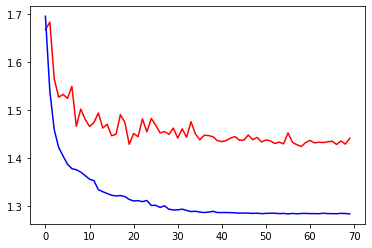

0.8281
Normalized confusion matrix


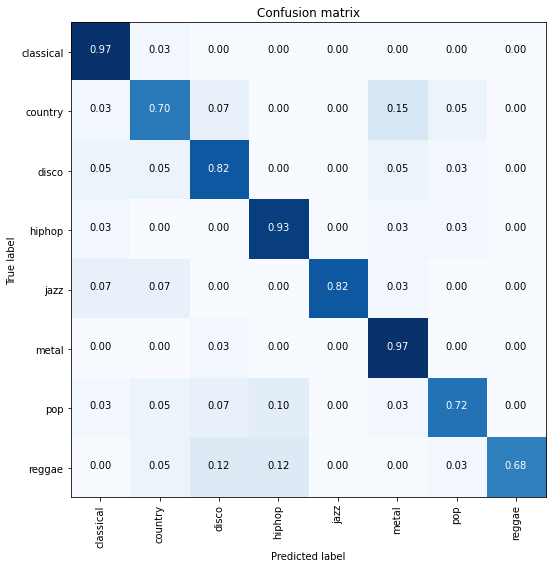

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3773] [Train Acc: 0.8963] [Valid Loss: 1.5032] [Valid Acc: 0.7688]
Epoch    13: reducing learning rate of group 0 to 1.6800e-02.
Epoch    18: reducing learning rate of group 0 to 1.1760e-02.
[Epoch 20/70] [Train Loss: 1.3150] [Train Acc: 0.9597] [Valid Loss: 1.4600] [Valid Acc: 0.8125]
Epoch    27: reducing learning rate of group 0 to 8.2320e-03.
[Epoch 30/70] [Train Loss: 1.3001] [Train Acc: 0.9743] [Valid Loss: 1.4540] [Valid Acc: 0.8250]
Epoch    38: reducing learning rate of group 0 to 5.7624e-03.
[Epoch 40/70] [Train Loss: 1.2908] [Train Acc: 0.9837] [Valid Loss: 1.4606] [Valid Acc: 0.8125]
Epoch    42: reducing learning rate of group 0 to 4.0337e-03.
Epoch    46: reducing learning rate of group 0 to 2.8236e-03.
[Epoch 50/70] [Train Loss: 1.2877] [Train Acc: 0.9867] [Valid Loss: 1.4353] [Valid Acc: 0.8375]
Epoch    50: reducing learning rate of group 0 to 1.9765e-03.
Epoch    54: reducing learning rate of group 0 to 1.3836e-03.
Epoch 

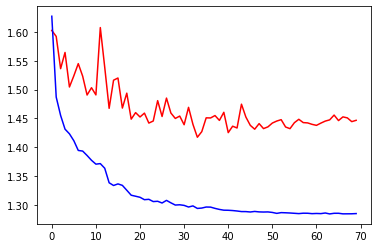

0.8406
Normalized confusion matrix


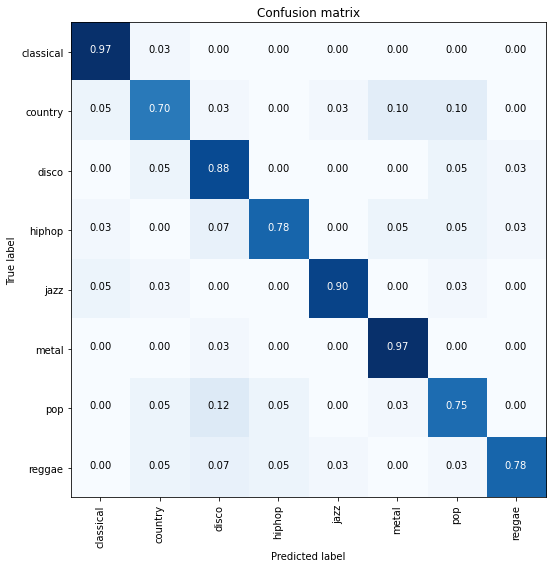

Training on GPU:0
Epoch     9: reducing learning rate of group 0 to 1.9600e-02.
[Epoch 10/70] [Train Loss: 1.3821] [Train Acc: 0.8918] [Valid Loss: 1.5612] [Valid Acc: 0.7188]
[Epoch 20/70] [Train Loss: 1.3351] [Train Acc: 0.9390] [Valid Loss: 1.4860] [Valid Acc: 0.7875]
Epoch    29: reducing learning rate of group 0 to 1.3720e-02.
[Epoch 30/70] [Train Loss: 1.3148] [Train Acc: 0.9594] [Valid Loss: 1.5097] [Valid Acc: 0.7750]
Epoch    33: reducing learning rate of group 0 to 9.6040e-03.
Epoch    37: reducing learning rate of group 0 to 6.7228e-03.
[Epoch 40/70] [Train Loss: 1.2951] [Train Acc: 0.9796] [Valid Loss: 1.4966] [Valid Acc: 0.7688]
Epoch    41: reducing learning rate of group 0 to 4.7060e-03.
Epoch    45: reducing learning rate of group 0 to 3.2942e-03.
[Epoch 50/70] [Train Loss: 1.2894] [Train Acc: 0.9844] [Valid Loss: 1.4851] [Valid Acc: 0.7812]
Epoch    50: reducing learning rate of group 0 to 2.3059e-03.
Epoch    54: reducing learning rate of group 0 to 1.6141e-03.
Epoch 

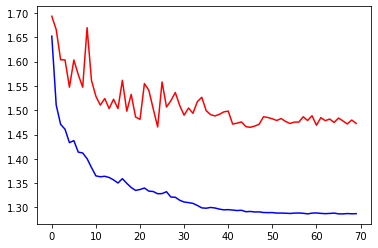

0.8063
Normalized confusion matrix


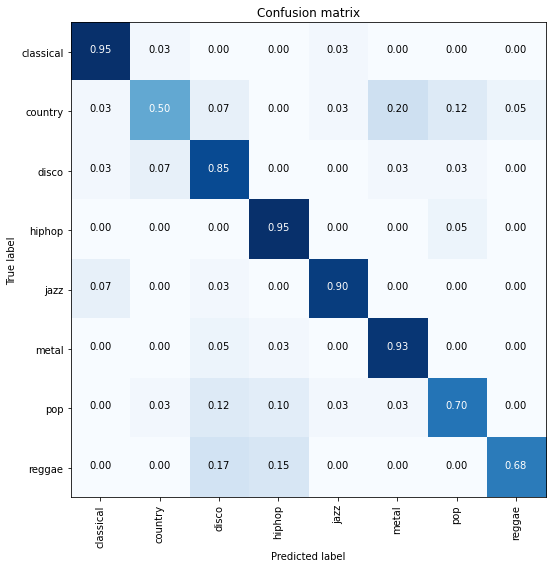

Training on GPU:0
Epoch     8: reducing learning rate of group 0 to 2.1000e-02.
[Epoch 10/70] [Train Loss: 1.3858] [Train Acc: 0.8877] [Valid Loss: 1.5761] [Valid Acc: 0.6937]
[Epoch 20/70] [Train Loss: 1.3521] [Train Acc: 0.9214] [Valid Loss: 1.5133] [Valid Acc: 0.7562]
Epoch    23: reducing learning rate of group 0 to 1.4700e-02.
Epoch    29: reducing learning rate of group 0 to 1.0290e-02.
[Epoch 30/70] [Train Loss: 1.3172] [Train Acc: 0.9563] [Valid Loss: 1.4675] [Valid Acc: 0.8063]
Epoch    35: reducing learning rate of group 0 to 7.2030e-03.
Epoch    39: reducing learning rate of group 0 to 5.0421e-03.
[Epoch 40/70] [Train Loss: 1.3006] [Train Acc: 0.9737] [Valid Loss: 1.4433] [Valid Acc: 0.8313]
Epoch    43: reducing learning rate of group 0 to 3.5295e-03.
Epoch    47: reducing learning rate of group 0 to 2.4706e-03.
[Epoch 50/70] [Train Loss: 1.2940] [Train Acc: 0.9807] [Valid Loss: 1.4346] [Valid Acc: 0.8375]
Epoch    51: reducing learning rate of group 0 to 1.7294e-03.
Epoch 

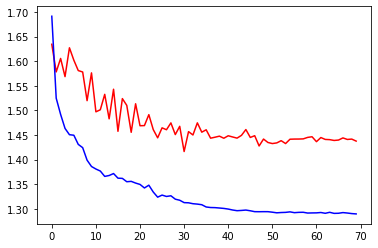

0.8281
Normalized confusion matrix


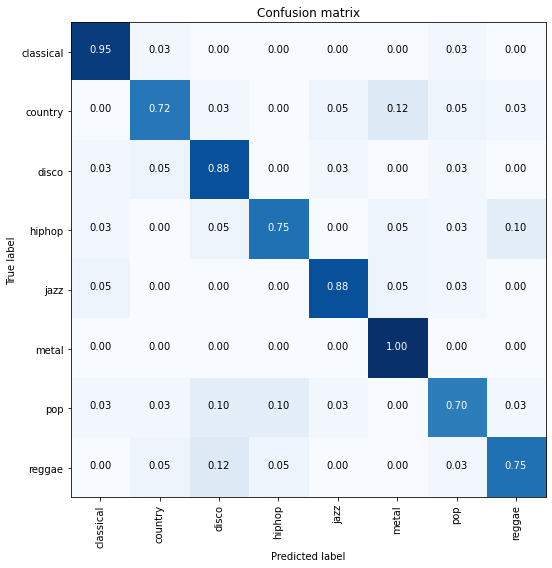

Training on GPU:0
Epoch     7: reducing learning rate of group 0 to 2.2400e-02.
[Epoch 10/70] [Train Loss: 1.3764] [Train Acc: 0.8970] [Valid Loss: 1.5120] [Valid Acc: 0.7562]
Epoch    16: reducing learning rate of group 0 to 1.5680e-02.
[Epoch 20/70] [Train Loss: 1.3286] [Train Acc: 0.9456] [Valid Loss: 1.4810] [Valid Acc: 0.7937]
Epoch    20: reducing learning rate of group 0 to 1.0976e-02.
Epoch    28: reducing learning rate of group 0 to 7.6832e-03.
[Epoch 30/70] [Train Loss: 1.3056] [Train Acc: 0.9682] [Valid Loss: 1.4524] [Valid Acc: 0.8187]
Epoch    33: reducing learning rate of group 0 to 5.3782e-03.
Epoch    37: reducing learning rate of group 0 to 3.7648e-03.
[Epoch 40/70] [Train Loss: 1.2943] [Train Acc: 0.9800] [Valid Loss: 1.4418] [Valid Acc: 0.8375]
Epoch    41: reducing learning rate of group 0 to 2.6353e-03.
Epoch    45: reducing learning rate of group 0 to 1.8447e-03.
Epoch    49: reducing learning rate of group 0 to 1.2913e-03.
[Epoch 50/70] [Train Loss: 1.2919] [Trai

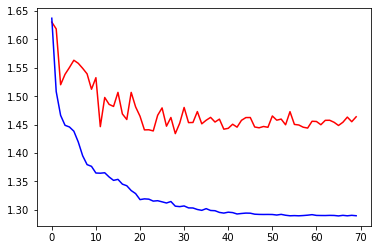

0.8187
Normalized confusion matrix


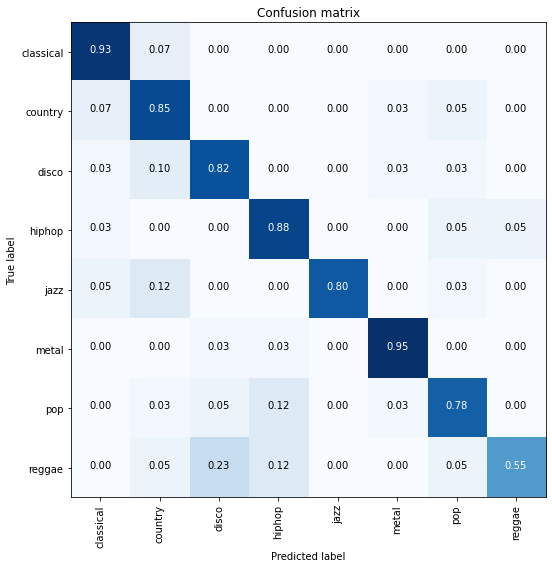

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.4994] [Train Acc: 0.7742] [Valid Loss: 1.6904] [Valid Acc: 0.5813]
Epoch    10: reducing learning rate of group 0 to 2.3800e-02.
Epoch    14: reducing learning rate of group 0 to 1.6660e-02.
[Epoch 20/70] [Train Loss: 1.4451] [Train Acc: 0.8274] [Valid Loss: 1.6047] [Valid Acc: 0.6750]
Epoch    23: reducing learning rate of group 0 to 1.1662e-02.
[Epoch 30/70] [Train Loss: 1.4260] [Train Acc: 0.8483] [Valid Loss: 1.6389] [Valid Acc: 0.6375]
Epoch    31: reducing learning rate of group 0 to 8.1634e-03.
[Epoch 40/70] [Train Loss: 1.4192] [Train Acc: 0.8545] [Valid Loss: 1.5675] [Valid Acc: 0.7063]
Epoch    40: reducing learning rate of group 0 to 5.7144e-03.
Epoch    46: reducing learning rate of group 0 to 4.0001e-03.
[Epoch 50/70] [Train Loss: 1.4146] [Train Acc: 0.8588] [Valid Loss: 1.5645] [Valid Acc: 0.7125]
Epoch    50: reducing learning rate of group 0 to 2.8000e-03.
Epoch    54: reducing learning rate of group 0 to 1.9600e-03.
Epoch 

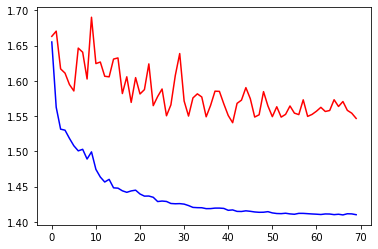

0.6969
Normalized confusion matrix


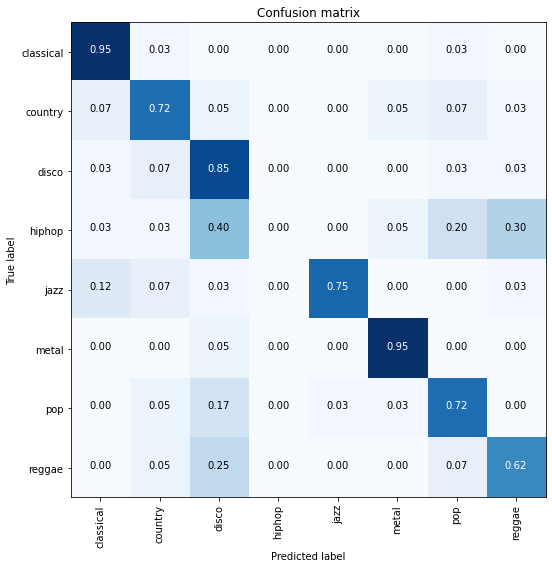

Training on GPU:0
Epoch     8: reducing learning rate of group 0 to 2.5200e-02.
[Epoch 10/70] [Train Loss: 1.3892] [Train Acc: 0.8841] [Valid Loss: 1.4999] [Valid Acc: 0.7688]
Epoch    19: reducing learning rate of group 0 to 1.7640e-02.
[Epoch 20/70] [Train Loss: 1.3483] [Train Acc: 0.9257] [Valid Loss: 1.5033] [Valid Acc: 0.7688]
[Epoch 30/70] [Train Loss: 1.3270] [Train Acc: 0.9465] [Valid Loss: 1.4676] [Valid Acc: 0.8000]
Epoch    30: reducing learning rate of group 0 to 1.2348e-02.
Epoch    34: reducing learning rate of group 0 to 8.6436e-03.
Epoch    38: reducing learning rate of group 0 to 6.0505e-03.
[Epoch 40/70] [Train Loss: 1.3027] [Train Acc: 0.9707] [Valid Loss: 1.4782] [Valid Acc: 0.7875]
Epoch    42: reducing learning rate of group 0 to 4.2354e-03.
Epoch    48: reducing learning rate of group 0 to 2.9648e-03.
[Epoch 50/70] [Train Loss: 1.2974] [Train Acc: 0.9767] [Valid Loss: 1.4713] [Valid Acc: 0.8000]
Epoch    52: reducing learning rate of group 0 to 2.0753e-03.
Epoch 

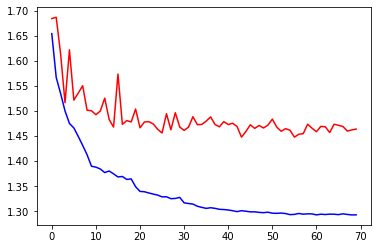

0.8125
Normalized confusion matrix


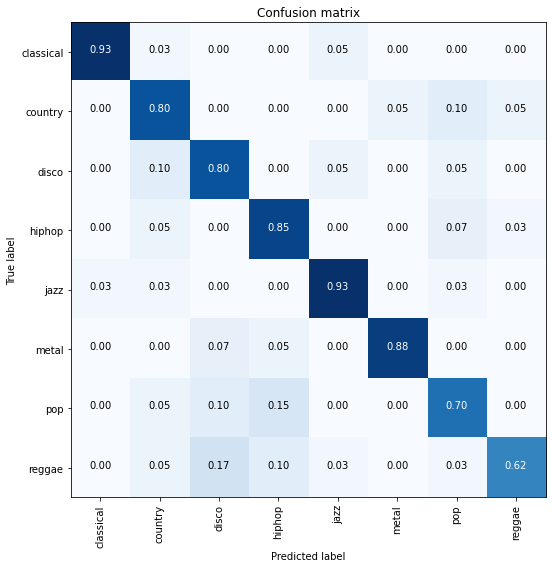

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.4494] [Train Acc: 0.8238] [Valid Loss: 1.5485] [Valid Acc: 0.7250]
Epoch    16: reducing learning rate of group 0 to 2.6600e-02.
[Epoch 20/70] [Train Loss: 1.3718] [Train Acc: 0.9013] [Valid Loss: 1.5383] [Valid Acc: 0.7250]
Epoch    20: reducing learning rate of group 0 to 1.8620e-02.
Epoch    24: reducing learning rate of group 0 to 1.3034e-02.
Epoch    28: reducing learning rate of group 0 to 9.1238e-03.
[Epoch 30/70] [Train Loss: 1.3288] [Train Acc: 0.9449] [Valid Loss: 1.4908] [Valid Acc: 0.7812]
Epoch    35: reducing learning rate of group 0 to 6.3867e-03.
Epoch    39: reducing learning rate of group 0 to 4.4707e-03.
[Epoch 40/70] [Train Loss: 1.3142] [Train Acc: 0.9596] [Valid Loss: 1.4757] [Valid Acc: 0.8000]
Epoch    43: reducing learning rate of group 0 to 3.1295e-03.
[Epoch 50/70] [Train Loss: 1.3082] [Train Acc: 0.9660] [Valid Loss: 1.4878] [Valid Acc: 0.7812]
Epoch    51: reducing learning rate of group 0 to 2.1906e-03.
Epoch 

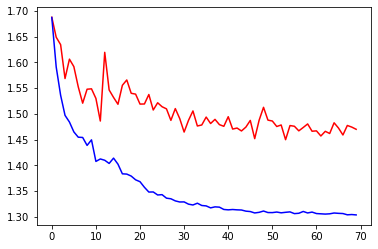

0.7875
Normalized confusion matrix


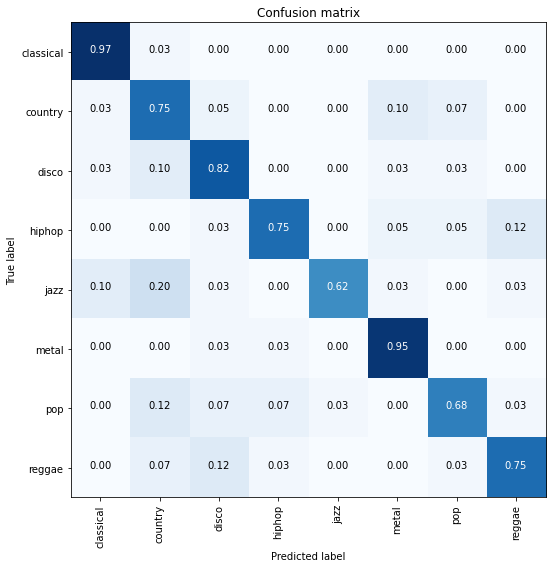

Training on GPU:0
Epoch     9: reducing learning rate of group 0 to 2.8000e-02.
[Epoch 10/70] [Train Loss: 1.4152] [Train Acc: 0.8576] [Valid Loss: 1.5828] [Valid Acc: 0.6813]
[Epoch 20/70] [Train Loss: 1.3764] [Train Acc: 0.8979] [Valid Loss: 1.5600] [Valid Acc: 0.7125]
Epoch    23: reducing learning rate of group 0 to 1.9600e-02.
[Epoch 30/70] [Train Loss: 1.3434] [Train Acc: 0.9307] [Valid Loss: 1.4860] [Valid Acc: 0.7875]
Epoch    31: reducing learning rate of group 0 to 1.3720e-02.
Epoch    37: reducing learning rate of group 0 to 9.6040e-03.
[Epoch 40/70] [Train Loss: 1.3196] [Train Acc: 0.9543] [Valid Loss: 1.4622] [Valid Acc: 0.8187]
Epoch    41: reducing learning rate of group 0 to 6.7228e-03.
Epoch    45: reducing learning rate of group 0 to 4.7060e-03.
Epoch    49: reducing learning rate of group 0 to 3.2942e-03.
[Epoch 50/70] [Train Loss: 1.3092] [Train Acc: 0.9649] [Valid Loss: 1.4791] [Valid Acc: 0.7937]
Epoch    53: reducing learning rate of group 0 to 2.3059e-03.
[Epoch

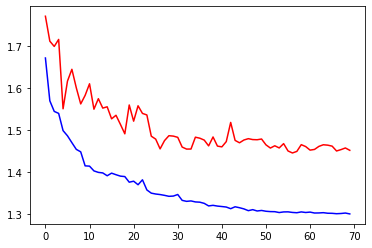

0.8156
Normalized confusion matrix


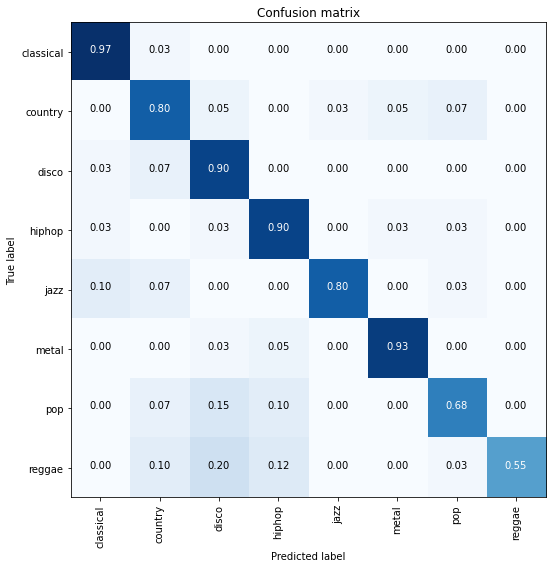

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.5165] [Train Acc: 0.7565] [Valid Loss: 1.6371] [Valid Acc: 0.6312]
Epoch    13: reducing learning rate of group 0 to 2.9400e-02.
[Epoch 20/70] [Train Loss: 1.4678] [Train Acc: 0.8058] [Valid Loss: 1.6531] [Valid Acc: 0.6188]
Epoch    20: reducing learning rate of group 0 to 2.0580e-02.
Epoch    26: reducing learning rate of group 0 to 1.4406e-02.
[Epoch 30/70] [Train Loss: 1.4424] [Train Acc: 0.8314] [Valid Loss: 1.5930] [Valid Acc: 0.6875]
Epoch    33: reducing learning rate of group 0 to 1.0084e-02.
[Epoch 40/70] [Train Loss: 1.4328] [Train Acc: 0.8407] [Valid Loss: 1.5697] [Valid Acc: 0.7063]
Epoch    41: reducing learning rate of group 0 to 7.0589e-03.
Epoch    45: reducing learning rate of group 0 to 4.9413e-03.
Epoch    49: reducing learning rate of group 0 to 3.4589e-03.
[Epoch 50/70] [Train Loss: 1.4261] [Train Acc: 0.8475] [Valid Loss: 1.5881] [Valid Acc: 0.6813]
Epoch    53: reducing learning rate of group 0 to 2.4212e-03.
Epoch 

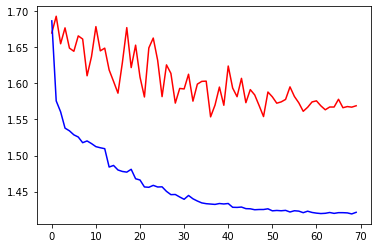

0.6937
Normalized confusion matrix


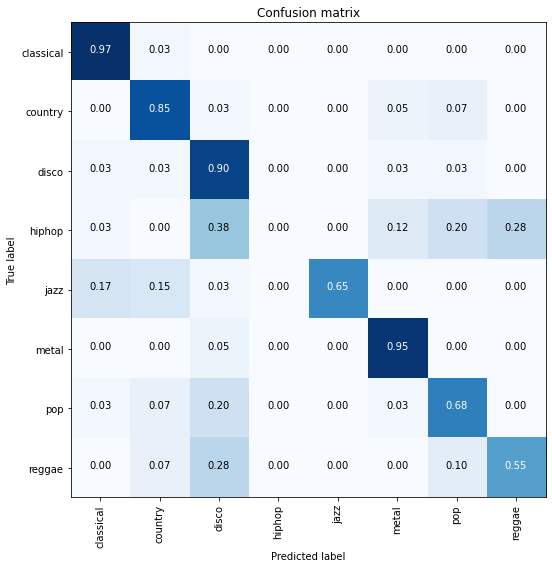

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.4459] [Train Acc: 0.8266] [Valid Loss: 1.6276] [Valid Acc: 0.6438]
Epoch    11: reducing learning rate of group 0 to 3.0800e-02.
[Epoch 20/70] [Train Loss: 1.3946] [Train Acc: 0.8784] [Valid Loss: 1.5819] [Valid Acc: 0.6937]
[Epoch 30/70] [Train Loss: 1.3890] [Train Acc: 0.8839] [Valid Loss: 1.5392] [Valid Acc: 0.7375]
Epoch    31: reducing learning rate of group 0 to 2.1560e-02.
[Epoch 40/70] [Train Loss: 1.3492] [Train Acc: 0.9243] [Valid Loss: 1.5096] [Valid Acc: 0.7625]
Epoch    40: reducing learning rate of group 0 to 1.5092e-02.
Epoch    44: reducing learning rate of group 0 to 1.0564e-02.
Epoch    48: reducing learning rate of group 0 to 7.3951e-03.
[Epoch 50/70] [Train Loss: 1.3251] [Train Acc: 0.9490] [Valid Loss: 1.5254] [Valid Acc: 0.7438]
Epoch    55: reducing learning rate of group 0 to 5.1766e-03.
Epoch    59: reducing learning rate of group 0 to 3.6236e-03.
[Epoch 60/70] [Train Loss: 1.3182] [Train Acc: 0.9557] [Valid Loss: 

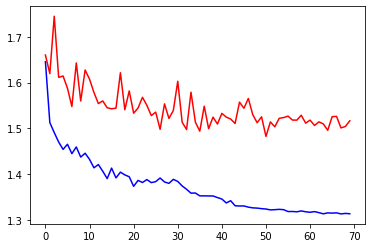

0.7594
Normalized confusion matrix


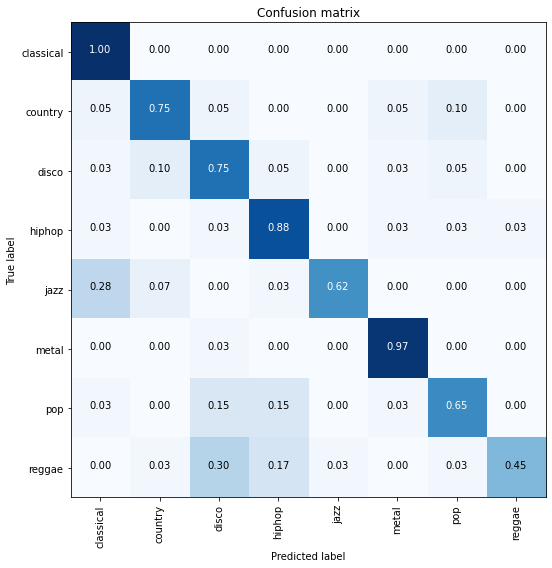

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.6560] [Train Acc: 0.7076] [Valid Loss: 1.7489] [Valid Acc: 0.5813]
[Epoch 20/70] [Train Loss: 1.4415] [Train Acc: 0.8740] [Valid Loss: 1.5902] [Valid Acc: 0.7250]
[Epoch 30/70] [Train Loss: 1.3708] [Train Acc: 0.9308] [Valid Loss: 1.5174] [Valid Acc: 0.7625]
[Epoch 40/70] [Train Loss: 1.3323] [Train Acc: 0.9601] [Valid Loss: 1.5127] [Valid Acc: 0.7812]
Epoch    41: reducing learning rate of group 0 to 1.4000e-04.
[Epoch 50/70] [Train Loss: 1.3201] [Train Acc: 0.9699] [Valid Loss: 1.4841] [Valid Acc: 0.8063]
Epoch    55: reducing learning rate of group 0 to 9.8000e-05.
[Epoch 60/70] [Train Loss: 1.3108] [Train Acc: 0.9742] [Valid Loss: 1.4938] [Valid Acc: 0.8000]
Epoch    61: reducing learning rate of group 0 to 6.8600e-05.
Epoch    65: reducing learning rate of group 0 to 4.8020e-05.
Epoch    69: reducing learning rate of group 0 to 3.3614e-05.
[Epoch 70/70] [Train Loss: 1.3060] [Train Acc: 0.9788] [Valid Loss: 1.4720] [Valid Acc: 0.8250]


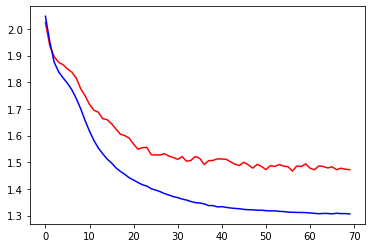

0.8219
Normalized confusion matrix


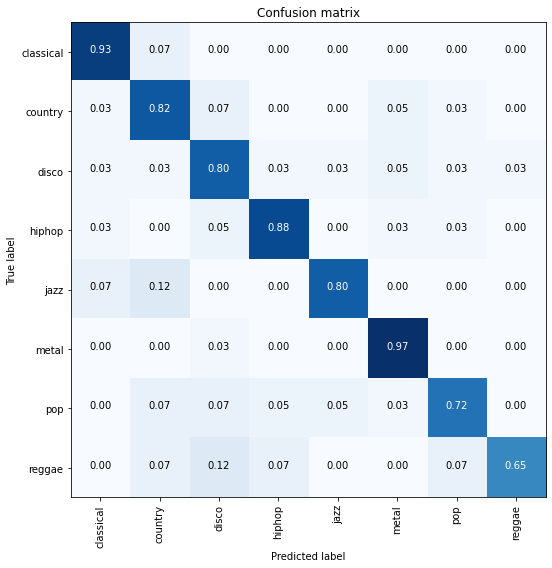

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.5933] [Train Acc: 0.7296] [Valid Loss: 1.6794] [Valid Acc: 0.6375]
[Epoch 20/70] [Train Loss: 1.4101] [Train Acc: 0.8940] [Valid Loss: 1.5185] [Valid Acc: 0.7875]
[Epoch 30/70] [Train Loss: 1.3544] [Train Acc: 0.9420] [Valid Loss: 1.4714] [Valid Acc: 0.8313]
Epoch    33: reducing learning rate of group 0 to 1.6800e-04.
[Epoch 40/70] [Train Loss: 1.3294] [Train Acc: 0.9615] [Valid Loss: 1.4564] [Valid Acc: 0.8250]
Epoch    41: reducing learning rate of group 0 to 1.1760e-04.
Epoch    45: reducing learning rate of group 0 to 8.2320e-05.
[Epoch 50/70] [Train Loss: 1.3182] [Train Acc: 0.9689] [Valid Loss: 1.4491] [Valid Acc: 0.8375]
Epoch    52: reducing learning rate of group 0 to 5.7624e-05.
Epoch    56: reducing learning rate of group 0 to 4.0337e-05.
[Epoch 60/70] [Train Loss: 1.3138] [Train Acc: 0.9718] [Valid Loss: 1.4477] [Valid Acc: 0.8375]
Epoch    60: reducing learning rate of group 0 to 2.8236e-05.
Epoch    64: reducing learning rat

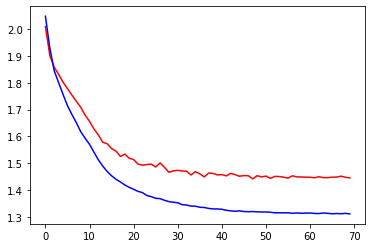

0.8281
Normalized confusion matrix


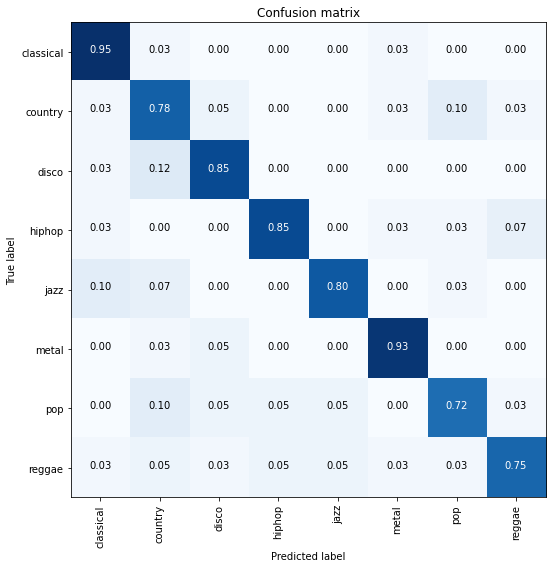

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.5560] [Train Acc: 0.7561] [Valid Loss: 1.6411] [Valid Acc: 0.6813]
[Epoch 20/70] [Train Loss: 1.3875] [Train Acc: 0.9176] [Valid Loss: 1.5012] [Valid Acc: 0.8187]
[Epoch 30/70] [Train Loss: 1.3409] [Train Acc: 0.9500] [Valid Loss: 1.4585] [Valid Acc: 0.8313]
Epoch    38: reducing learning rate of group 0 to 1.9600e-04.
[Epoch 40/70] [Train Loss: 1.3168] [Train Acc: 0.9690] [Valid Loss: 1.4447] [Valid Acc: 0.8375]
Epoch    44: reducing learning rate of group 0 to 1.3720e-04.
Epoch    48: reducing learning rate of group 0 to 9.6040e-05.
[Epoch 50/70] [Train Loss: 1.3067] [Train Acc: 0.9784] [Valid Loss: 1.4441] [Valid Acc: 0.8375]
Epoch    58: reducing learning rate of group 0 to 6.7228e-05.
[Epoch 60/70] [Train Loss: 1.3026] [Train Acc: 0.9802] [Valid Loss: 1.4494] [Valid Acc: 0.8375]
Epoch    68: reducing learning rate of group 0 to 4.7060e-05.
[Epoch 70/70] [Train Loss: 1.2992] [Train Acc: 0.9843] [Valid Loss: 1.4533] [Valid Acc: 0.8250]


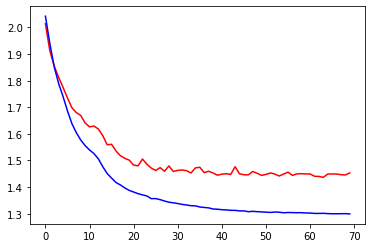

0.8125
Normalized confusion matrix


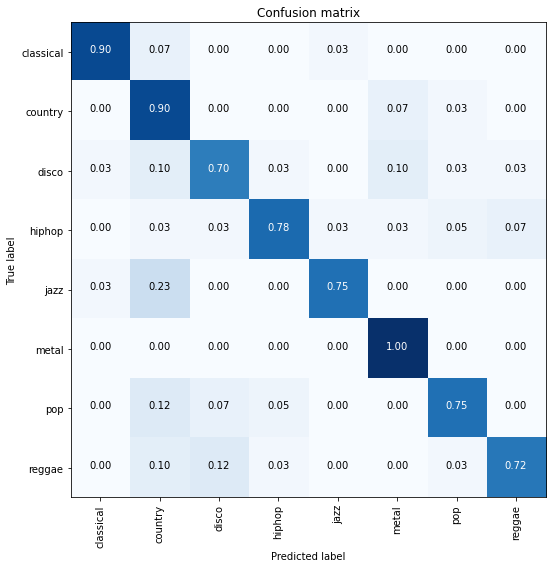

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.5405] [Train Acc: 0.7619] [Valid Loss: 1.6220] [Valid Acc: 0.6750]
[Epoch 20/70] [Train Loss: 1.3814] [Train Acc: 0.9189] [Valid Loss: 1.5275] [Valid Acc: 0.7812]
Epoch    25: reducing learning rate of group 0 to 2.1000e-04.
[Epoch 30/70] [Train Loss: 1.3303] [Train Acc: 0.9618] [Valid Loss: 1.5099] [Valid Acc: 0.7875]
Epoch    36: reducing learning rate of group 0 to 1.4700e-04.
[Epoch 40/70] [Train Loss: 1.3144] [Train Acc: 0.9731] [Valid Loss: 1.4848] [Valid Acc: 0.8000]
Epoch    43: reducing learning rate of group 0 to 1.0290e-04.
Epoch    49: reducing learning rate of group 0 to 7.2030e-05.
[Epoch 50/70] [Train Loss: 1.3057] [Train Acc: 0.9770] [Valid Loss: 1.4855] [Valid Acc: 0.7875]
[Epoch 60/70] [Train Loss: 1.3031] [Train Acc: 0.9802] [Valid Loss: 1.4807] [Valid Acc: 0.7937]
Epoch    60: reducing learning rate of group 0 to 5.0421e-05.
Epoch    64: reducing learning rate of group 0 to 3.5295e-05.
[Epoch 70/70] [Train Loss: 1.3009]

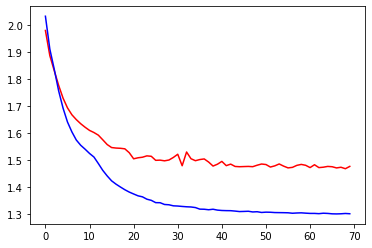

0.8094
Normalized confusion matrix


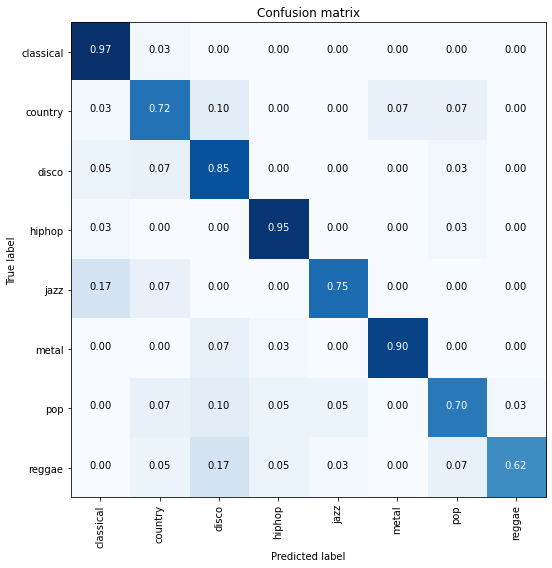

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.5480] [Train Acc: 0.7662] [Valid Loss: 1.6409] [Valid Acc: 0.6562]
[Epoch 20/70] [Train Loss: 1.3692] [Train Acc: 0.9317] [Valid Loss: 1.5029] [Valid Acc: 0.7812]
Epoch    26: reducing learning rate of group 0 to 2.2400e-04.
[Epoch 30/70] [Train Loss: 1.3284] [Train Acc: 0.9618] [Valid Loss: 1.4627] [Valid Acc: 0.8313]
Epoch    34: reducing learning rate of group 0 to 1.5680e-04.
Epoch    38: reducing learning rate of group 0 to 1.0976e-04.
[Epoch 40/70] [Train Loss: 1.3117] [Train Acc: 0.9749] [Valid Loss: 1.4626] [Valid Acc: 0.8063]
Epoch    45: reducing learning rate of group 0 to 7.6832e-05.
[Epoch 50/70] [Train Loss: 1.3032] [Train Acc: 0.9819] [Valid Loss: 1.4538] [Valid Acc: 0.8250]
Epoch    53: reducing learning rate of group 0 to 5.3782e-05.
[Epoch 60/70] [Train Loss: 1.3014] [Train Acc: 0.9818] [Valid Loss: 1.4505] [Valid Acc: 0.8313]
Epoch    65: reducing learning rate of group 0 to 3.7648e-05.
[Epoch 70/70] [Train Loss: 1.2995]

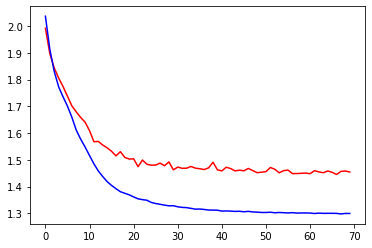

0.8375
Normalized confusion matrix


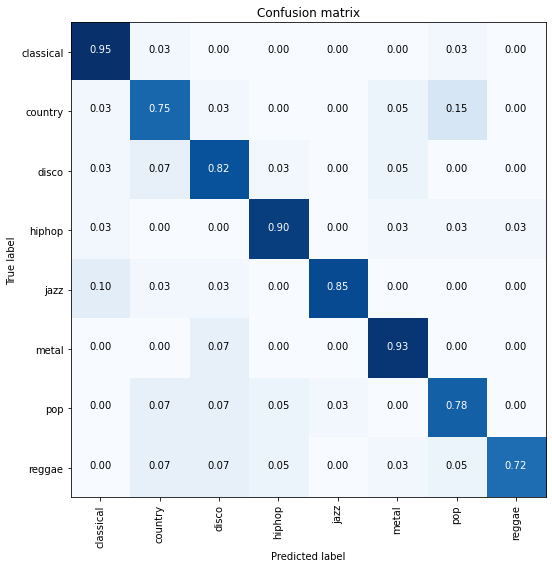

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.4639] [Train Acc: 0.8534] [Valid Loss: 1.5788] [Valid Acc: 0.7562]
[Epoch 20/70] [Train Loss: 1.3563] [Train Acc: 0.9409] [Valid Loss: 1.4815] [Valid Acc: 0.8187]
[Epoch 30/70] [Train Loss: 1.3243] [Train Acc: 0.9642] [Valid Loss: 1.4721] [Valid Acc: 0.8125]
Epoch    30: reducing learning rate of group 0 to 2.3800e-04.
[Epoch 40/70] [Train Loss: 1.3084] [Train Acc: 0.9755] [Valid Loss: 1.4563] [Valid Acc: 0.8250]
Epoch    46: reducing learning rate of group 0 to 1.6660e-04.
[Epoch 50/70] [Train Loss: 1.3007] [Train Acc: 0.9804] [Valid Loss: 1.4539] [Valid Acc: 0.8187]
Epoch    57: reducing learning rate of group 0 to 1.1662e-04.
[Epoch 60/70] [Train Loss: 1.2960] [Train Acc: 0.9843] [Valid Loss: 1.4392] [Valid Acc: 0.8313]
Epoch    61: reducing learning rate of group 0 to 8.1634e-05.
Epoch    65: reducing learning rate of group 0 to 5.7144e-05.
[Epoch 70/70] [Train Loss: 1.2930] [Train Acc: 0.9887] [Valid Loss: 1.4368] [Valid Acc: 0.8375]


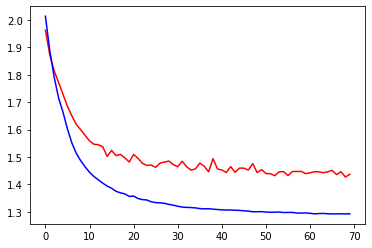

0.8438
Normalized confusion matrix


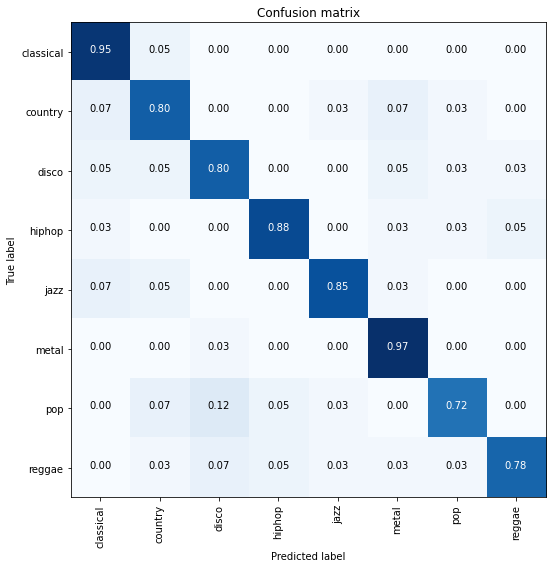

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.5285] [Train Acc: 0.7751] [Valid Loss: 1.6141] [Valid Acc: 0.7000]
[Epoch 20/70] [Train Loss: 1.3687] [Train Acc: 0.9319] [Valid Loss: 1.5034] [Valid Acc: 0.8000]
[Epoch 30/70] [Train Loss: 1.3213] [Train Acc: 0.9675] [Valid Loss: 1.4725] [Valid Acc: 0.8187]
[Epoch 40/70] [Train Loss: 1.3050] [Train Acc: 0.9792] [Valid Loss: 1.4483] [Valid Acc: 0.8375]
[Epoch 50/70] [Train Loss: 1.2949] [Train Acc: 0.9866] [Valid Loss: 1.4457] [Valid Acc: 0.8438]
Epoch    53: reducing learning rate of group 0 to 2.5200e-04.
Epoch    57: reducing learning rate of group 0 to 1.7640e-04.
[Epoch 60/70] [Train Loss: 1.2873] [Train Acc: 0.9911] [Valid Loss: 1.4342] [Valid Acc: 0.8438]
Epoch    62: reducing learning rate of group 0 to 1.2348e-04.
Epoch    66: reducing learning rate of group 0 to 8.6436e-05.
[Epoch 70/70] [Train Loss: 1.2852] [Train Acc: 0.9933] [Valid Loss: 1.4392] [Valid Acc: 0.8375]
Epoch    70: reducing learning rate of group 0 to 6.0505e-05.


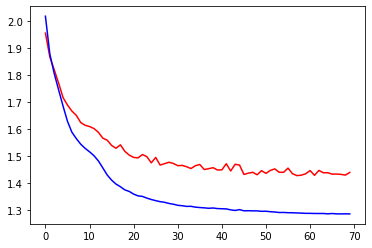

0.8344
Normalized confusion matrix


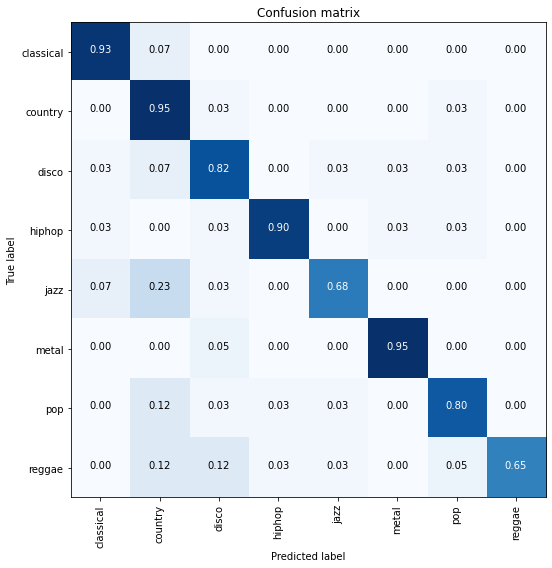

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.5308] [Train Acc: 0.7997] [Valid Loss: 1.6437] [Valid Acc: 0.6687]
[Epoch 20/70] [Train Loss: 1.3507] [Train Acc: 0.9447] [Valid Loss: 1.4837] [Valid Acc: 0.8125]
Epoch    26: reducing learning rate of group 0 to 2.6600e-04.
[Epoch 30/70] [Train Loss: 1.3180] [Train Acc: 0.9693] [Valid Loss: 1.4867] [Valid Acc: 0.8125]
Epoch    35: reducing learning rate of group 0 to 1.8620e-04.
Epoch    39: reducing learning rate of group 0 to 1.3034e-04.
[Epoch 40/70] [Train Loss: 1.3029] [Train Acc: 0.9816] [Valid Loss: 1.4572] [Valid Acc: 0.8438]
Epoch    43: reducing learning rate of group 0 to 9.1238e-05.
[Epoch 50/70] [Train Loss: 1.2998] [Train Acc: 0.9821] [Valid Loss: 1.4630] [Valid Acc: 0.8250]
Epoch    51: reducing learning rate of group 0 to 6.3867e-05.
Epoch    55: reducing learning rate of group 0 to 4.4707e-05.
Epoch    59: reducing learning rate of group 0 to 3.1295e-05.
[Epoch 60/70] [Train Loss: 1.2966] [Train Acc: 0.9841] [Valid Loss: 

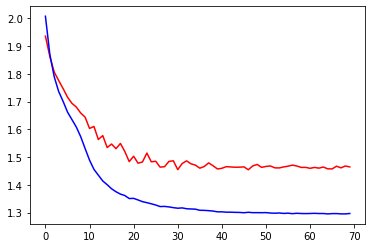

0.825
Normalized confusion matrix


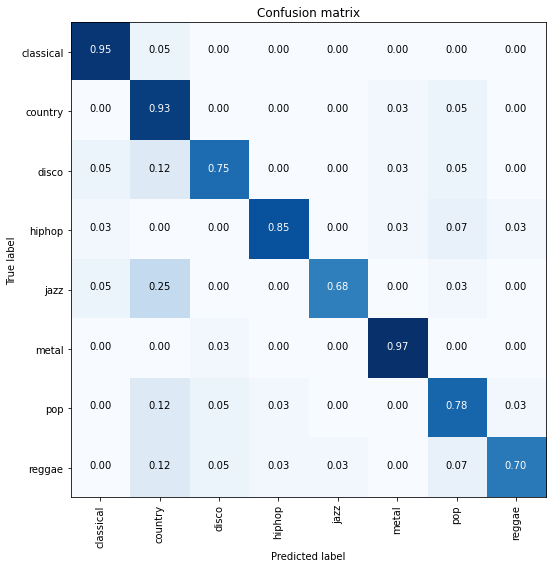

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.4445] [Train Acc: 0.8767] [Valid Loss: 1.5688] [Valid Acc: 0.7500]
[Epoch 20/70] [Train Loss: 1.3489] [Train Acc: 0.9451] [Valid Loss: 1.5304] [Valid Acc: 0.7562]
Epoch    20: reducing learning rate of group 0 to 2.8000e-04.
[Epoch 30/70] [Train Loss: 1.3194] [Train Acc: 0.9689] [Valid Loss: 1.4907] [Valid Acc: 0.7937]
[Epoch 40/70] [Train Loss: 1.3066] [Train Acc: 0.9762] [Valid Loss: 1.4955] [Valid Acc: 0.7812]
Epoch    43: reducing learning rate of group 0 to 1.9600e-04.
[Epoch 50/70] [Train Loss: 1.3000] [Train Acc: 0.9810] [Valid Loss: 1.4669] [Valid Acc: 0.8125]
Epoch    57: reducing learning rate of group 0 to 1.3720e-04.
[Epoch 60/70] [Train Loss: 1.2937] [Train Acc: 0.9862] [Valid Loss: 1.4521] [Valid Acc: 0.8187]
Epoch    66: reducing learning rate of group 0 to 9.6040e-05.
[Epoch 70/70] [Train Loss: 1.2917] [Train Acc: 0.9880] [Valid Loss: 1.4716] [Valid Acc: 0.8125]
Epoch    70: reducing learning rate of group 0 to 6.7228e-05.


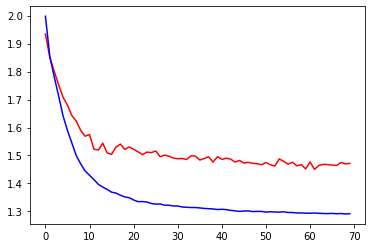

0.8094
Normalized confusion matrix


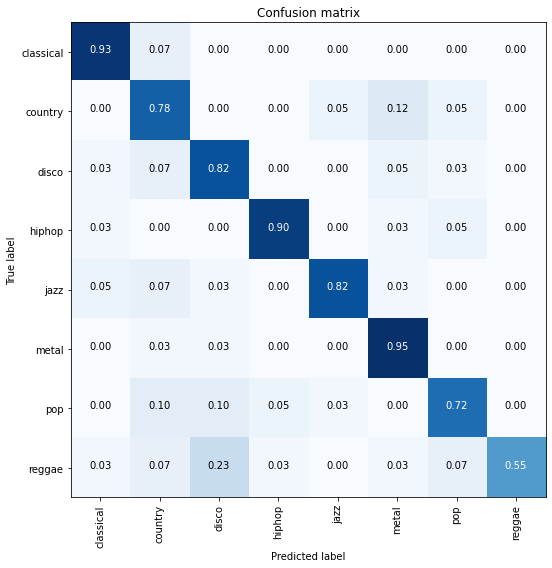

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.4338] [Train Acc: 0.8802] [Valid Loss: 1.5631] [Valid Acc: 0.7750]
[Epoch 20/70] [Train Loss: 1.3450] [Train Acc: 0.9483] [Valid Loss: 1.5056] [Valid Acc: 0.7937]
Epoch    25: reducing learning rate of group 0 to 2.9400e-04.
[Epoch 30/70] [Train Loss: 1.3142] [Train Acc: 0.9728] [Valid Loss: 1.4785] [Valid Acc: 0.8125]
Epoch    30: reducing learning rate of group 0 to 2.0580e-04.
Epoch    34: reducing learning rate of group 0 to 1.4406e-04.
[Epoch 40/70] [Train Loss: 1.3025] [Train Acc: 0.9806] [Valid Loss: 1.4497] [Valid Acc: 0.8375]
Epoch    44: reducing learning rate of group 0 to 1.0084e-04.
Epoch    49: reducing learning rate of group 0 to 7.0589e-05.
[Epoch 50/70] [Train Loss: 1.2968] [Train Acc: 0.9856] [Valid Loss: 1.4686] [Valid Acc: 0.8125]
Epoch    58: reducing learning rate of group 0 to 4.9413e-05.
[Epoch 60/70] [Train Loss: 1.2954] [Train Acc: 0.9865] [Valid Loss: 1.4522] [Valid Acc: 0.8375]
Epoch    62: reducing learning rat

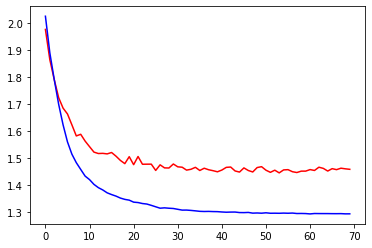

0.8344
Normalized confusion matrix


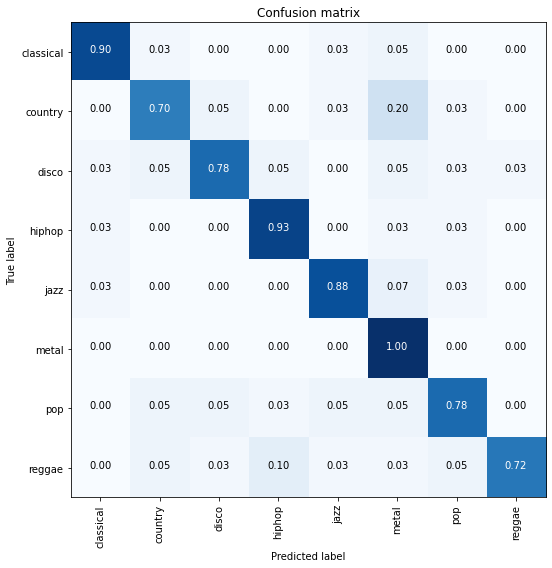

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.4967] [Train Acc: 0.8124] [Valid Loss: 1.6720] [Valid Acc: 0.6250]
[Epoch 20/70] [Train Loss: 1.3440] [Train Acc: 0.9488] [Valid Loss: 1.5383] [Valid Acc: 0.7750]
Epoch    29: reducing learning rate of group 0 to 3.0800e-04.
[Epoch 30/70] [Train Loss: 1.3088] [Train Acc: 0.9753] [Valid Loss: 1.4961] [Valid Acc: 0.7812]
[Epoch 40/70] [Train Loss: 1.2963] [Train Acc: 0.9852] [Valid Loss: 1.4858] [Valid Acc: 0.8000]
Epoch    43: reducing learning rate of group 0 to 2.1560e-04.
Epoch    48: reducing learning rate of group 0 to 1.5092e-04.
[Epoch 50/70] [Train Loss: 1.2901] [Train Acc: 0.9898] [Valid Loss: 1.4967] [Valid Acc: 0.7688]
Epoch    52: reducing learning rate of group 0 to 1.0564e-04.
Epoch    56: reducing learning rate of group 0 to 7.3951e-05.
[Epoch 60/70] [Train Loss: 1.2887] [Train Acc: 0.9905] [Valid Loss: 1.4994] [Valid Acc: 0.7688]
Epoch    60: reducing learning rate of group 0 to 5.1766e-05.
Epoch    64: reducing learning rat

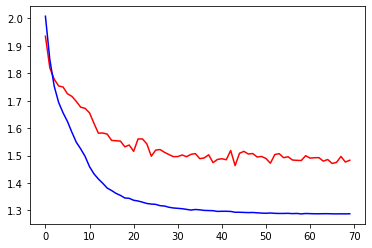

0.8125
Normalized confusion matrix


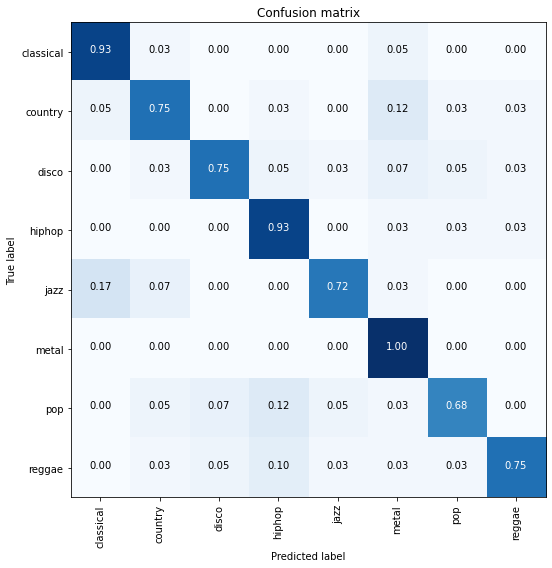

./model_0.024_70_30
0.85


In [28]:
best=''
best_acc = 0

for lr in lrs :
    acc, path = run(lr,70,30)
    if acc > best_acc:
        best_acc = acc
        best =path
    gc.collect()
    torch.cuda.empty_cache() 
        
print(best)
print(best_acc)

In [11]:
lrs = [2.6,2.8,3.0,3.1,3.2,3.4]
lrs = [i*1e-3 for i in lrs]

In [12]:
hparams.feature_path = 'feature6'
train_loader, valid_loader, test_loader = get_dataloader(hparams)

In [13]:
bts = [44,50]

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3388] [Train Acc: 0.9439] [Valid Loss: 1.4649] [Valid Acc: 0.8063]
Epoch    18: reducing learning rate of group 0 to 1.8200e-03.
[Epoch 20/70] [Train Loss: 1.2938] [Train Acc: 0.9831] [Valid Loss: 1.4362] [Valid Acc: 0.8375]
Epoch    22: reducing learning rate of group 0 to 1.2740e-03.
Epoch    27: reducing learning rate of group 0 to 8.9180e-04.
[Epoch 30/70] [Train Loss: 1.2821] [Train Acc: 0.9942] [Valid Loss: 1.4290] [Valid Acc: 0.8313]
Epoch    31: reducing learning rate of group 0 to 6.2426e-04.
Epoch    35: reducing learning rate of group 0 to 4.3698e-04.
Epoch    39: reducing learning rate of group 0 to 3.0589e-04.
[Epoch 40/70] [Train Loss: 1.2792] [Train Acc: 0.9965] [Valid Loss: 1.4284] [Valid Acc: 0.8438]
Epoch    46: reducing learning rate of group 0 to 2.1412e-04.
[Epoch 50/70] [Train Loss: 1.2787] [Train Acc: 0.9966] [Valid Loss: 1.4193] [Valid Acc: 0.8500]
Epoch    50: reducing learning rate of group 0 to 1.4988e-04.
Epoch 

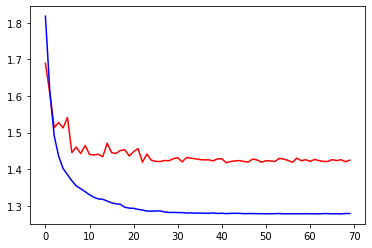

0.85938
Normalized confusion matrix


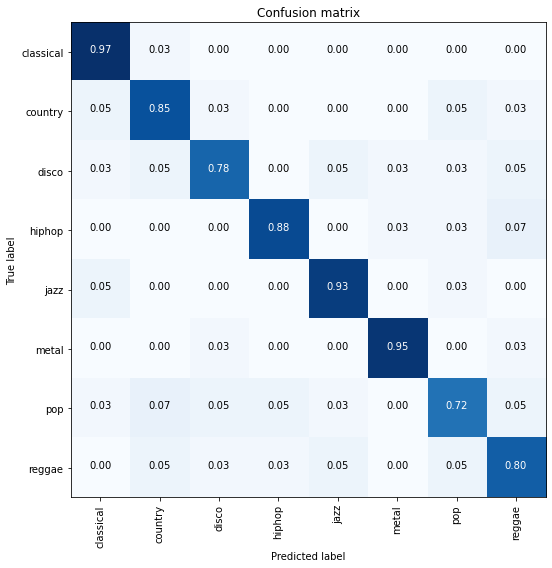

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3355] [Train Acc: 0.9475] [Valid Loss: 1.4282] [Valid Acc: 0.8625]
Epoch    14: reducing learning rate of group 0 to 1.8200e-03.
[Epoch 20/70] [Train Loss: 1.2985] [Train Acc: 0.9794] [Valid Loss: 1.4104] [Valid Acc: 0.8625]
Epoch    25: reducing learning rate of group 0 to 1.2740e-03.
Epoch    29: reducing learning rate of group 0 to 8.9180e-04.
[Epoch 30/70] [Train Loss: 1.2835] [Train Acc: 0.9923] [Valid Loss: 1.4115] [Valid Acc: 0.8625]
Epoch    33: reducing learning rate of group 0 to 6.2426e-04.
[Epoch 40/70] [Train Loss: 1.2805] [Train Acc: 0.9952] [Valid Loss: 1.4122] [Valid Acc: 0.8625]
Epoch    42: reducing learning rate of group 0 to 4.3698e-04.
Epoch    49: reducing learning rate of group 0 to 3.0589e-04.
[Epoch 50/70] [Train Loss: 1.2791] [Train Acc: 0.9960] [Valid Loss: 1.4041] [Valid Acc: 0.8750]
Epoch    53: reducing learning rate of group 0 to 2.1412e-04.
Epoch    57: reducing learning rate of group 0 to 1.4988e-04.
[Epoch

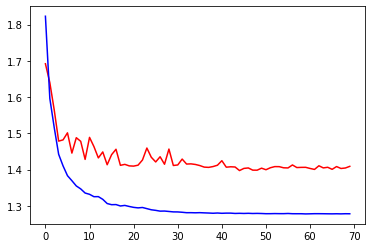

0.84688
Normalized confusion matrix


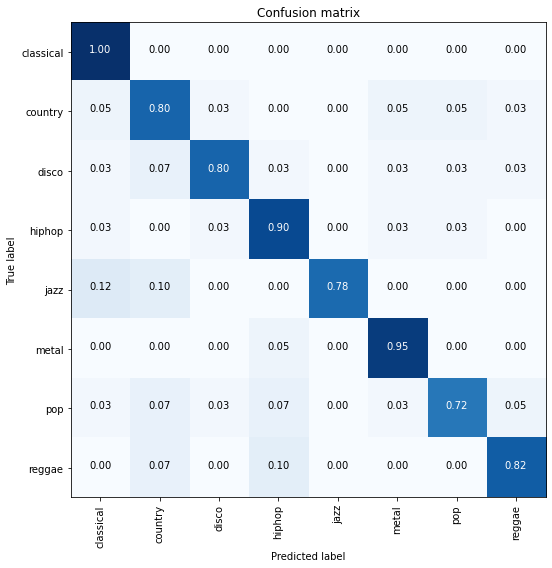

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3327] [Train Acc: 0.9494] [Valid Loss: 1.4914] [Valid Acc: 0.7875]
Epoch    16: reducing learning rate of group 0 to 1.8200e-03.
[Epoch 20/70] [Train Loss: 1.2937] [Train Acc: 0.9838] [Valid Loss: 1.4072] [Valid Acc: 0.8750]
Epoch    25: reducing learning rate of group 0 to 1.2740e-03.
Epoch    29: reducing learning rate of group 0 to 8.9180e-04.
[Epoch 30/70] [Train Loss: 1.2816] [Train Acc: 0.9939] [Valid Loss: 1.4124] [Valid Acc: 0.8688]
Epoch    33: reducing learning rate of group 0 to 6.2426e-04.
Epoch    37: reducing learning rate of group 0 to 4.3698e-04.
[Epoch 40/70] [Train Loss: 1.2789] [Train Acc: 0.9964] [Valid Loss: 1.4121] [Valid Acc: 0.8625]
Epoch    41: reducing learning rate of group 0 to 3.0589e-04.
Epoch    45: reducing learning rate of group 0 to 2.1412e-04.
[Epoch 50/70] [Train Loss: 1.2778] [Train Acc: 0.9975] [Valid Loss: 1.4237] [Valid Acc: 0.8562]
Epoch    52: reducing learning rate of group 0 to 1.4988e-04.
Epoch 

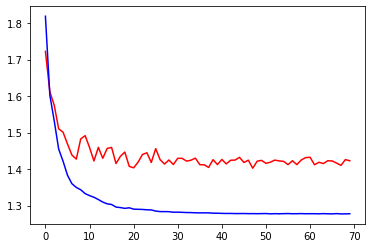

0.85
Normalized confusion matrix


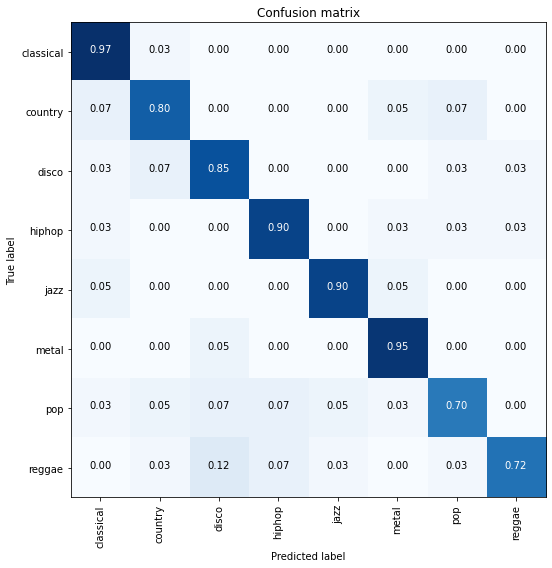

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3377] [Train Acc: 0.9423] [Valid Loss: 1.4810] [Valid Acc: 0.7875]
Epoch    18: reducing learning rate of group 0 to 1.9600e-03.
[Epoch 20/70] [Train Loss: 1.2943] [Train Acc: 0.9828] [Valid Loss: 1.3969] [Valid Acc: 0.8875]
Epoch    22: reducing learning rate of group 0 to 1.3720e-03.
Epoch    26: reducing learning rate of group 0 to 9.6040e-04.
[Epoch 30/70] [Train Loss: 1.2834] [Train Acc: 0.9918] [Valid Loss: 1.3995] [Valid Acc: 0.8750]
Epoch    30: reducing learning rate of group 0 to 6.7228e-04.
Epoch    34: reducing learning rate of group 0 to 4.7060e-04.
Epoch    38: reducing learning rate of group 0 to 3.2942e-04.
[Epoch 40/70] [Train Loss: 1.2819] [Train Acc: 0.9932] [Valid Loss: 1.3916] [Valid Acc: 0.8875]
Epoch    42: reducing learning rate of group 0 to 2.3059e-04.
Epoch    46: reducing learning rate of group 0 to 1.6141e-04.
[Epoch 50/70] [Train Loss: 1.2814] [Train Acc: 0.9936] [Valid Loss: 1.3960] [Valid Acc: 0.8812]
Epoch 

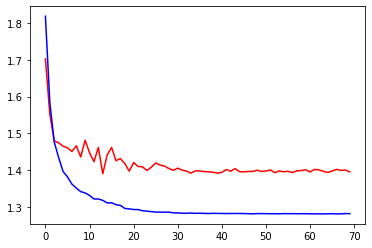

0.86562
Normalized confusion matrix


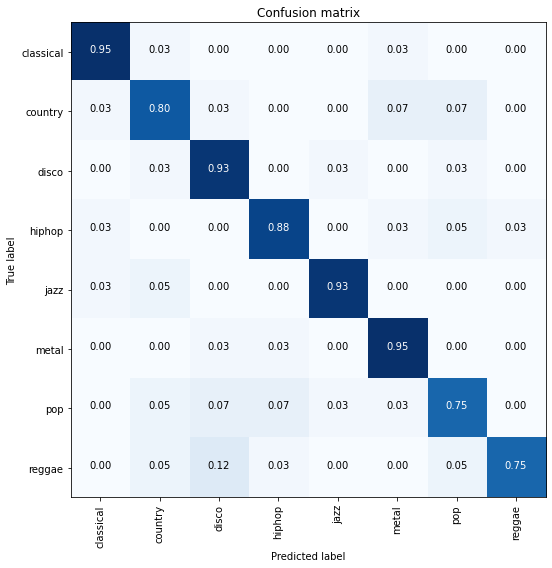

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3364] [Train Acc: 0.9438] [Valid Loss: 1.4957] [Valid Acc: 0.7875]
Epoch    17: reducing learning rate of group 0 to 1.9600e-03.
[Epoch 20/70] [Train Loss: 1.2935] [Train Acc: 0.9836] [Valid Loss: 1.4589] [Valid Acc: 0.8125]
Epoch    21: reducing learning rate of group 0 to 1.3720e-03.
Epoch    25: reducing learning rate of group 0 to 9.6040e-04.
Epoch    29: reducing learning rate of group 0 to 6.7228e-04.
[Epoch 30/70] [Train Loss: 1.2826] [Train Acc: 0.9930] [Valid Loss: 1.4426] [Valid Acc: 0.8438]
Epoch    33: reducing learning rate of group 0 to 4.7060e-04.
Epoch    37: reducing learning rate of group 0 to 3.2942e-04.
[Epoch 40/70] [Train Loss: 1.2807] [Train Acc: 0.9942] [Valid Loss: 1.4456] [Valid Acc: 0.8187]
Epoch    41: reducing learning rate of group 0 to 2.3059e-04.
Epoch    45: reducing learning rate of group 0 to 1.6141e-04.
Epoch    49: reducing learning rate of group 0 to 1.1299e-04.
[Epoch 50/70] [Train Loss: 1.2799] [Trai

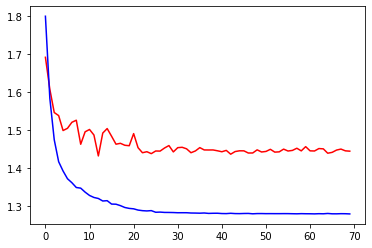

0.82188
Normalized confusion matrix


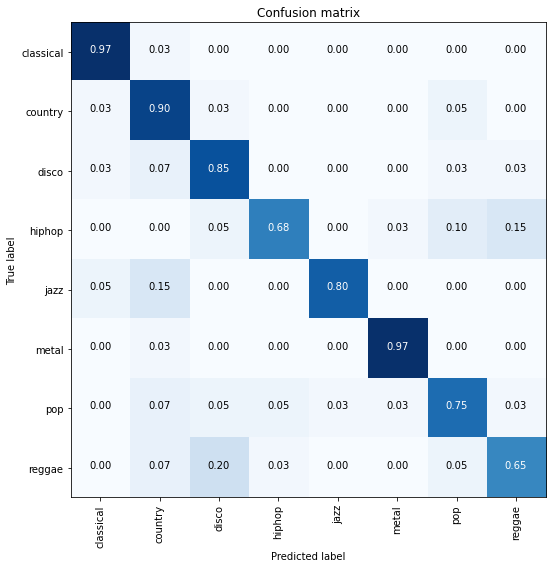

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3370] [Train Acc: 0.9452] [Valid Loss: 1.4581] [Valid Acc: 0.8250]
[Epoch 20/70] [Train Loss: 1.2986] [Train Acc: 0.9791] [Valid Loss: 1.4240] [Valid Acc: 0.8625]
Epoch    20: reducing learning rate of group 0 to 1.9600e-03.
Epoch    24: reducing learning rate of group 0 to 1.3720e-03.
Epoch    28: reducing learning rate of group 0 to 9.6040e-04.
[Epoch 30/70] [Train Loss: 1.2826] [Train Acc: 0.9925] [Valid Loss: 1.4060] [Valid Acc: 0.8750]
Epoch    32: reducing learning rate of group 0 to 6.7228e-04.
Epoch    36: reducing learning rate of group 0 to 4.7060e-04.
[Epoch 40/70] [Train Loss: 1.2794] [Train Acc: 0.9960] [Valid Loss: 1.4068] [Valid Acc: 0.8688]
Epoch    40: reducing learning rate of group 0 to 3.2942e-04.
Epoch    44: reducing learning rate of group 0 to 2.3059e-04.
Epoch    48: reducing learning rate of group 0 to 1.6141e-04.
[Epoch 50/70] [Train Loss: 1.2791] [Train Acc: 0.9957] [Valid Loss: 1.4053] [Valid Acc: 0.8750]
Epoch 

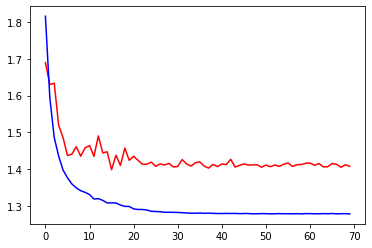

0.86875
Normalized confusion matrix


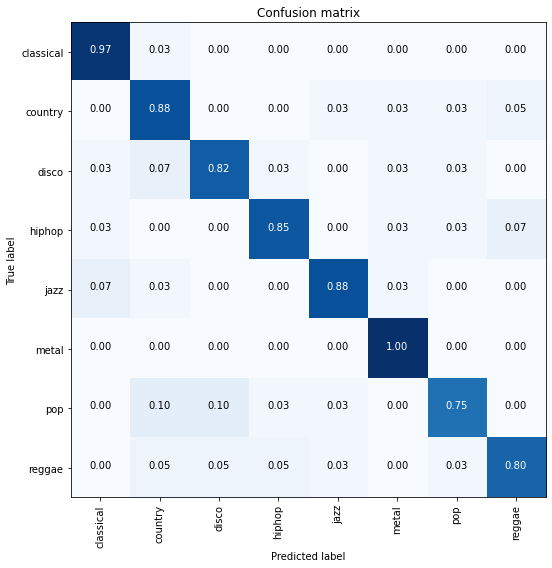

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3243] [Train Acc: 0.9560] [Valid Loss: 1.4502] [Valid Acc: 0.8187]
Epoch    13: reducing learning rate of group 0 to 2.1000e-03.
Epoch    17: reducing learning rate of group 0 to 1.4700e-03.
[Epoch 20/70] [Train Loss: 1.2875] [Train Acc: 0.9891] [Valid Loss: 1.4402] [Valid Acc: 0.8313]
Epoch    26: reducing learning rate of group 0 to 1.0290e-03.
[Epoch 30/70] [Train Loss: 1.2821] [Train Acc: 0.9931] [Valid Loss: 1.4380] [Valid Acc: 0.8438]
Epoch    30: reducing learning rate of group 0 to 7.2030e-04.
Epoch    34: reducing learning rate of group 0 to 5.0421e-04.
Epoch    38: reducing learning rate of group 0 to 3.5295e-04.
[Epoch 40/70] [Train Loss: 1.2810] [Train Acc: 0.9942] [Valid Loss: 1.4306] [Valid Acc: 0.8500]
Epoch    42: reducing learning rate of group 0 to 2.4706e-04.
Epoch    46: reducing learning rate of group 0 to 1.7294e-04.
[Epoch 50/70] [Train Loss: 1.2792] [Train Acc: 0.9957] [Valid Loss: 1.4355] [Valid Acc: 0.8500]
Epoch 

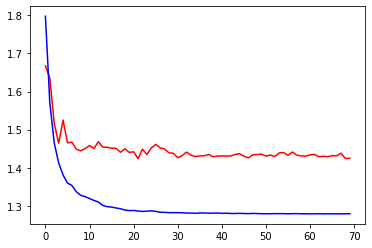

0.84375
Normalized confusion matrix


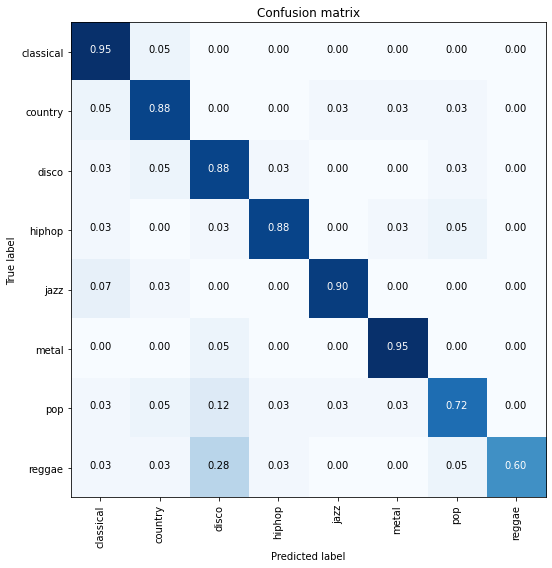

Training on GPU:0
Epoch     8: reducing learning rate of group 0 to 2.1000e-03.
[Epoch 10/70] [Train Loss: 1.3232] [Train Acc: 0.9567] [Valid Loss: 1.4593] [Valid Acc: 0.8125]
Epoch    15: reducing learning rate of group 0 to 1.4700e-03.
Epoch    19: reducing learning rate of group 0 to 1.0290e-03.
[Epoch 20/70] [Train Loss: 1.2928] [Train Acc: 0.9841] [Valid Loss: 1.4676] [Valid Acc: 0.8125]
Epoch    28: reducing learning rate of group 0 to 7.2030e-04.
[Epoch 30/70] [Train Loss: 1.2842] [Train Acc: 0.9917] [Valid Loss: 1.4539] [Valid Acc: 0.8187]
Epoch    32: reducing learning rate of group 0 to 5.0421e-04.
Epoch    36: reducing learning rate of group 0 to 3.5295e-04.
[Epoch 40/70] [Train Loss: 1.2817] [Train Acc: 0.9937] [Valid Loss: 1.4499] [Valid Acc: 0.8187]
Epoch    40: reducing learning rate of group 0 to 2.4706e-04.
Epoch    44: reducing learning rate of group 0 to 1.7294e-04.
Epoch    48: reducing learning rate of group 0 to 1.2106e-04.
[Epoch 50/70] [Train Loss: 1.2816] [Trai

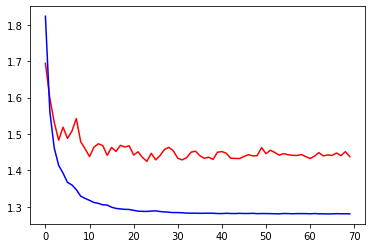

0.84062
Normalized confusion matrix


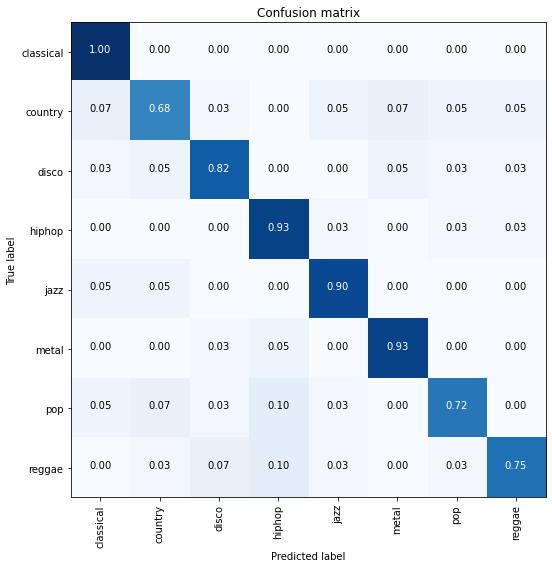

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3304] [Train Acc: 0.9501] [Valid Loss: 1.4642] [Valid Acc: 0.8125]
Epoch    12: reducing learning rate of group 0 to 2.1000e-03.
Epoch    16: reducing learning rate of group 0 to 1.4700e-03.
[Epoch 20/70] [Train Loss: 1.2902] [Train Acc: 0.9867] [Valid Loss: 1.4478] [Valid Acc: 0.8375]
Epoch    20: reducing learning rate of group 0 to 1.0290e-03.
Epoch    24: reducing learning rate of group 0 to 7.2030e-04.
Epoch    28: reducing learning rate of group 0 to 5.0421e-04.
[Epoch 30/70] [Train Loss: 1.2833] [Train Acc: 0.9928] [Valid Loss: 1.4529] [Valid Acc: 0.8250]
Epoch    32: reducing learning rate of group 0 to 3.5295e-04.
Epoch    36: reducing learning rate of group 0 to 2.4706e-04.
[Epoch 40/70] [Train Loss: 1.2807] [Train Acc: 0.9950] [Valid Loss: 1.4425] [Valid Acc: 0.8250]
Epoch    40: reducing learning rate of group 0 to 1.7294e-04.
Epoch    44: reducing learning rate of group 0 to 1.2106e-04.
Epoch    48: reducing learning rate of g

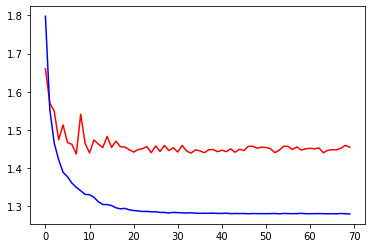

0.82812
Normalized confusion matrix


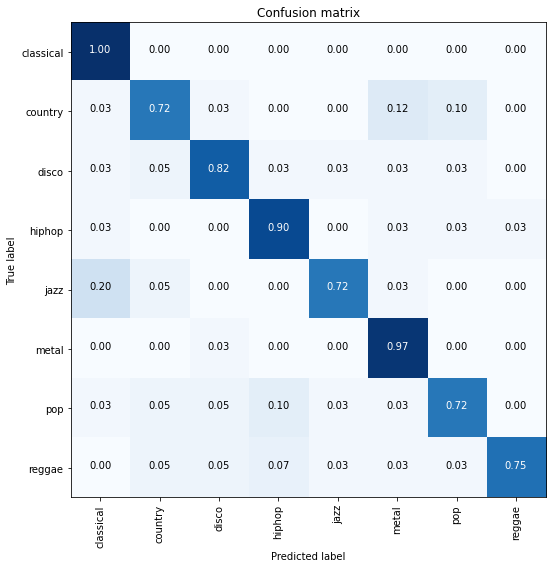

Training on GPU:0
Epoch     9: reducing learning rate of group 0 to 2.1700e-03.
[Epoch 10/70] [Train Loss: 1.3203] [Train Acc: 0.9595] [Valid Loss: 1.4459] [Valid Acc: 0.8313]
Epoch    17: reducing learning rate of group 0 to 1.5190e-03.
[Epoch 20/70] [Train Loss: 1.2923] [Train Acc: 0.9850] [Valid Loss: 1.4485] [Valid Acc: 0.8250]
Epoch    21: reducing learning rate of group 0 to 1.0633e-03.
[Epoch 30/70] [Train Loss: 1.2843] [Train Acc: 0.9919] [Valid Loss: 1.4447] [Valid Acc: 0.8375]
Epoch    30: reducing learning rate of group 0 to 7.4431e-04.
Epoch    34: reducing learning rate of group 0 to 5.2102e-04.
Epoch    38: reducing learning rate of group 0 to 3.6471e-04.
[Epoch 40/70] [Train Loss: 1.2810] [Train Acc: 0.9940] [Valid Loss: 1.4299] [Valid Acc: 0.8500]
Epoch    42: reducing learning rate of group 0 to 2.5530e-04.
Epoch    46: reducing learning rate of group 0 to 1.7871e-04.
[Epoch 50/70] [Train Loss: 1.2797] [Train Acc: 0.9955] [Valid Loss: 1.4266] [Valid Acc: 0.8438]
Epoch 

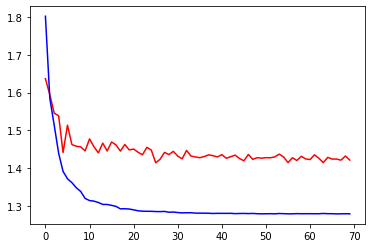

0.84062
Normalized confusion matrix


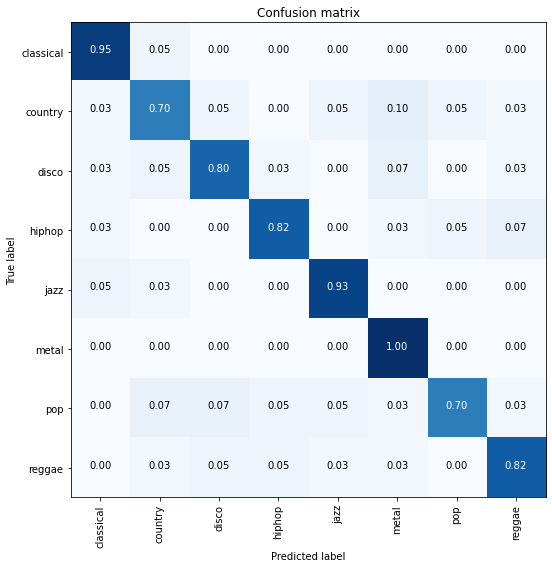

Training on GPU:0
Epoch     8: reducing learning rate of group 0 to 2.1700e-03.
[Epoch 10/70] [Train Loss: 1.3219] [Train Acc: 0.9593] [Valid Loss: 1.4572] [Valid Acc: 0.8313]
Epoch    17: reducing learning rate of group 0 to 1.5190e-03.
[Epoch 20/70] [Train Loss: 1.2947] [Train Acc: 0.9830] [Valid Loss: 1.4380] [Valid Acc: 0.8313]
Epoch    21: reducing learning rate of group 0 to 1.0633e-03.
[Epoch 30/70] [Train Loss: 1.2867] [Train Acc: 0.9894] [Valid Loss: 1.4032] [Valid Acc: 0.8750]
Epoch    34: reducing learning rate of group 0 to 7.4431e-04.
Epoch    38: reducing learning rate of group 0 to 5.2102e-04.
[Epoch 40/70] [Train Loss: 1.2813] [Train Acc: 0.9944] [Valid Loss: 1.4156] [Valid Acc: 0.8625]
Epoch    42: reducing learning rate of group 0 to 3.6471e-04.
Epoch    46: reducing learning rate of group 0 to 2.5530e-04.
[Epoch 50/70] [Train Loss: 1.2796] [Train Acc: 0.9959] [Valid Loss: 1.4179] [Valid Acc: 0.8562]
Epoch    50: reducing learning rate of group 0 to 1.7871e-04.
Epoch 

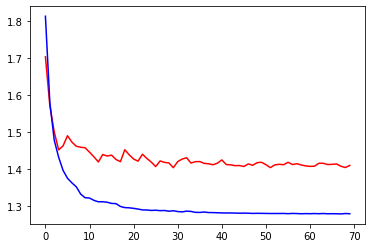

0.86875
Normalized confusion matrix


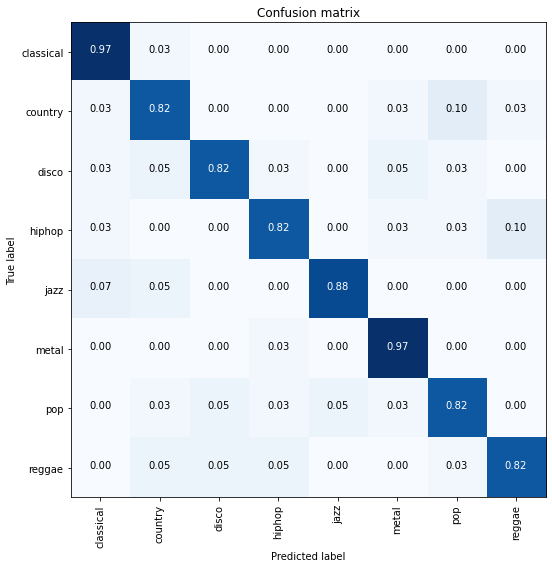

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3377] [Train Acc: 0.9422] [Valid Loss: 1.4951] [Valid Acc: 0.7812]
Epoch    18: reducing learning rate of group 0 to 2.1700e-03.
[Epoch 20/70] [Train Loss: 1.2941] [Train Acc: 0.9825] [Valid Loss: 1.4532] [Valid Acc: 0.8187]
Epoch    23: reducing learning rate of group 0 to 1.5190e-03.
Epoch    27: reducing learning rate of group 0 to 1.0633e-03.
[Epoch 30/70] [Train Loss: 1.2842] [Train Acc: 0.9910] [Valid Loss: 1.4299] [Valid Acc: 0.8438]


In [ ]:
best=''
best_acc = 0

for lr in lrs :
    for bt in bts:
        acc, path = run(lr,70,bt)
        if acc > best_acc:
            best_acc = acc
            best =path
        gc.collect()
        torch.cuda.empty_cache() 
        
print(best)
print(best_acc)

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3397] [Train Acc: 0.9416] [Valid Loss: 1.4506] [Valid Acc: 0.8438]
Epoch    15: reducing learning rate of group 0 to 1.8200e-03.
[Epoch 20/70] [Train Loss: 1.2943] [Train Acc: 0.9830] [Valid Loss: 1.4225] [Valid Acc: 0.8562]
Epoch    24: reducing learning rate of group 0 to 1.2740e-03.
Epoch    28: reducing learning rate of group 0 to 8.9180e-04.
[Epoch 30/70] [Train Loss: 1.2821] [Train Acc: 0.9941] [Valid Loss: 1.4291] [Valid Acc: 0.8438]
Epoch    33: reducing learning rate of group 0 to 6.2426e-04.
Epoch    37: reducing learning rate of group 0 to 4.3698e-04.
[Epoch 40/70] [Train Loss: 1.2789] [Train Acc: 0.9965] [Valid Loss: 1.4238] [Valid Acc: 0.8500]
Epoch    47: reducing learning rate of group 0 to 3.0589e-04.
[Epoch 50/70] [Train Loss: 1.2785] [Train Acc: 0.9964] [Valid Loss: 1.4260] [Valid Acc: 0.8500]
Epoch    51: reducing learning rate of group 0 to 2.1412e-04.
Epoch    55: reducing learning rate of group 0 to 1.4988e-04.
[Epoch

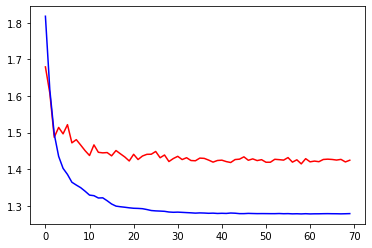

0.85313
Normalized confusion matrix


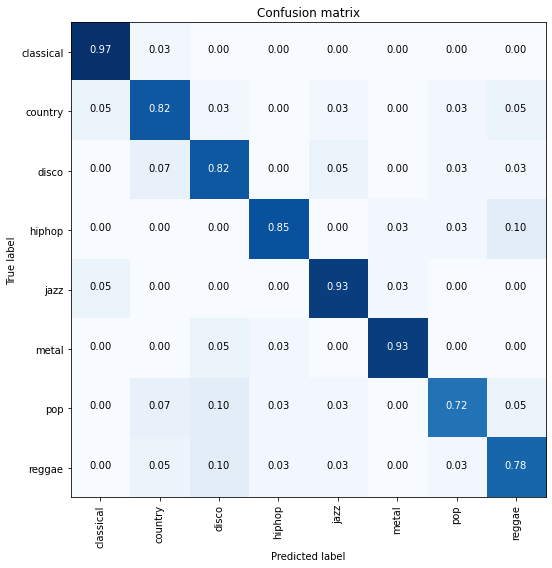

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3372] [Train Acc: 0.9462] [Valid Loss: 1.4583] [Valid Acc: 0.8313]
Epoch    11: reducing learning rate of group 0 to 1.8200e-03.
Epoch    19: reducing learning rate of group 0 to 1.2740e-03.
[Epoch 20/70] [Train Loss: 1.2926] [Train Acc: 0.9845] [Valid Loss: 1.4402] [Valid Acc: 0.8250]
Epoch    23: reducing learning rate of group 0 to 8.9180e-04.
Epoch    27: reducing learning rate of group 0 to 6.2426e-04.
[Epoch 30/70] [Train Loss: 1.2823] [Train Acc: 0.9943] [Valid Loss: 1.4217] [Valid Acc: 0.8562]
Epoch    31: reducing learning rate of group 0 to 4.3698e-04.
Epoch    35: reducing learning rate of group 0 to 3.0589e-04.
Epoch    39: reducing learning rate of group 0 to 2.1412e-04.
[Epoch 40/70] [Train Loss: 1.2806] [Train Acc: 0.9952] [Valid Loss: 1.4261] [Valid Acc: 0.8500]
Epoch    43: reducing learning rate of group 0 to 1.4988e-04.
Epoch    47: reducing learning rate of group 0 to 1.0492e-04.
[Epoch 50/70] [Train Loss: 1.2800] [Trai

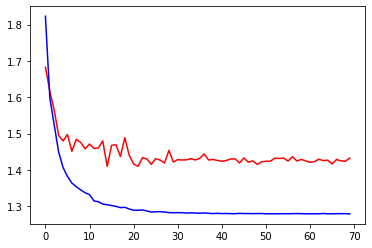

0.83125
Normalized confusion matrix


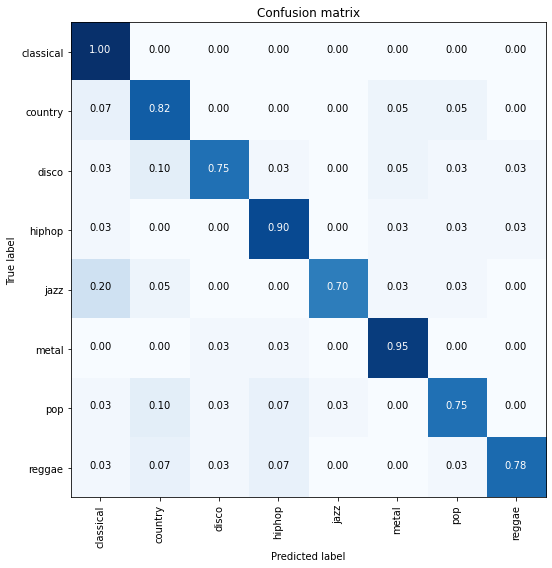

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3322] [Train Acc: 0.9493] [Valid Loss: 1.4825] [Valid Acc: 0.7812]
Epoch    11: reducing learning rate of group 0 to 1.9600e-03.
Epoch    16: reducing learning rate of group 0 to 1.3720e-03.
[Epoch 20/70] [Train Loss: 1.2911] [Train Acc: 0.9856] [Valid Loss: 1.4318] [Valid Acc: 0.8438]
Epoch    21: reducing learning rate of group 0 to 9.6040e-04.
Epoch    25: reducing learning rate of group 0 to 6.7228e-04.
Epoch    29: reducing learning rate of group 0 to 4.7060e-04.
[Epoch 30/70] [Train Loss: 1.2828] [Train Acc: 0.9935] [Valid Loss: 1.4285] [Valid Acc: 0.8438]
Epoch    33: reducing learning rate of group 0 to 3.2942e-04.
Epoch    37: reducing learning rate of group 0 to 2.3059e-04.
[Epoch 40/70] [Train Loss: 1.2808] [Train Acc: 0.9949] [Valid Loss: 1.4232] [Valid Acc: 0.8562]
Epoch    41: reducing learning rate of group 0 to 1.6141e-04.
Epoch    45: reducing learning rate of group 0 to 1.1299e-04.
Epoch    49: reducing learning rate of g

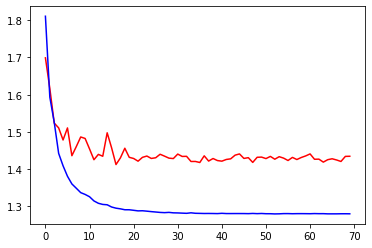

0.84062
Normalized confusion matrix


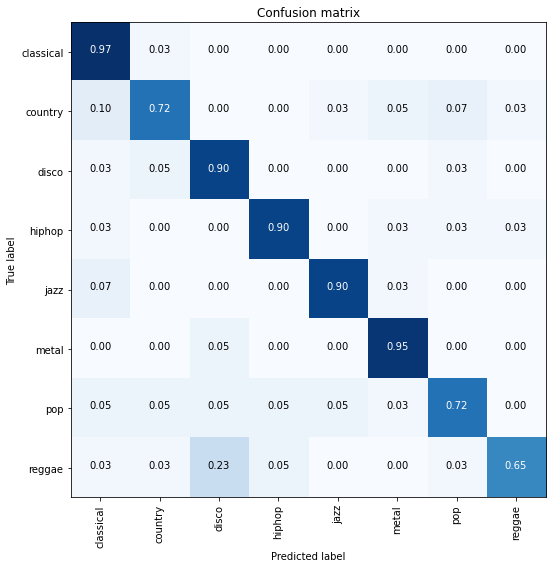

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3397] [Train Acc: 0.9421] [Valid Loss: 1.4389] [Valid Acc: 0.8438]
Epoch    11: reducing learning rate of group 0 to 1.9600e-03.
Epoch    16: reducing learning rate of group 0 to 1.3720e-03.
[Epoch 20/70] [Train Loss: 1.2926] [Train Acc: 0.9855] [Valid Loss: 1.4017] [Valid Acc: 0.8688]
Epoch    20: reducing learning rate of group 0 to 9.6040e-04.
Epoch    24: reducing learning rate of group 0 to 6.7228e-04.
Epoch    28: reducing learning rate of group 0 to 4.7060e-04.
[Epoch 30/70] [Train Loss: 1.2848] [Train Acc: 0.9912] [Valid Loss: 1.4141] [Valid Acc: 0.8625]
Epoch    32: reducing learning rate of group 0 to 3.2942e-04.
Epoch    36: reducing learning rate of group 0 to 2.3059e-04.
[Epoch 40/70] [Train Loss: 1.2827] [Train Acc: 0.9931] [Valid Loss: 1.4057] [Valid Acc: 0.8688]
Epoch    40: reducing learning rate of group 0 to 1.6141e-04.
Epoch    44: reducing learning rate of group 0 to 1.1299e-04.
Epoch    48: reducing learning rate of g

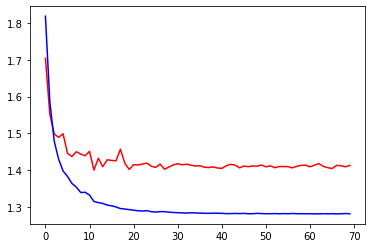

0.8625
Normalized confusion matrix


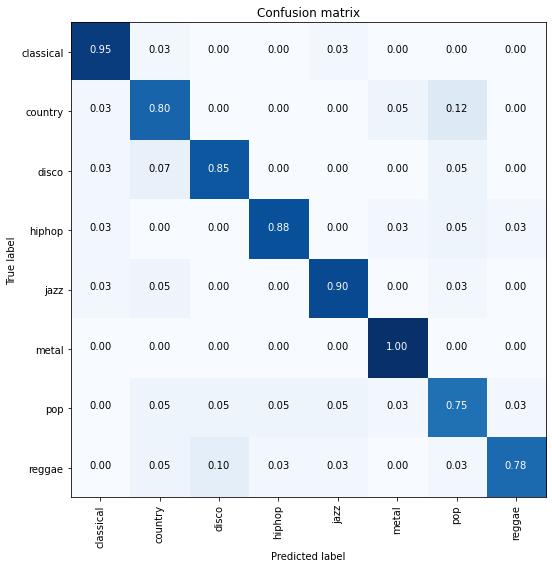

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3338] [Train Acc: 0.9480] [Valid Loss: 1.5012] [Valid Acc: 0.7688]
Epoch    16: reducing learning rate of group 0 to 2.1000e-03.
[Epoch 20/70] [Train Loss: 1.2929] [Train Acc: 0.9845] [Valid Loss: 1.4422] [Valid Acc: 0.8375]
Epoch    21: reducing learning rate of group 0 to 1.4700e-03.
Epoch    25: reducing learning rate of group 0 to 1.0290e-03.
Epoch    29: reducing learning rate of group 0 to 7.2030e-04.
[Epoch 30/70] [Train Loss: 1.2824] [Train Acc: 0.9929] [Valid Loss: 1.4276] [Valid Acc: 0.8500]
Epoch    33: reducing learning rate of group 0 to 5.0421e-04.
Epoch    37: reducing learning rate of group 0 to 3.5295e-04.
[Epoch 40/70] [Train Loss: 1.2807] [Train Acc: 0.9944] [Valid Loss: 1.4338] [Valid Acc: 0.8313]
Epoch    41: reducing learning rate of group 0 to 2.4706e-04.
Epoch    45: reducing learning rate of group 0 to 1.7294e-04.
Epoch    49: reducing learning rate of group 0 to 1.2106e-04.
[Epoch 50/70] [Train Loss: 1.2803] [Trai

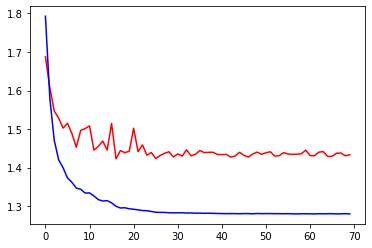

0.84062
Normalized confusion matrix


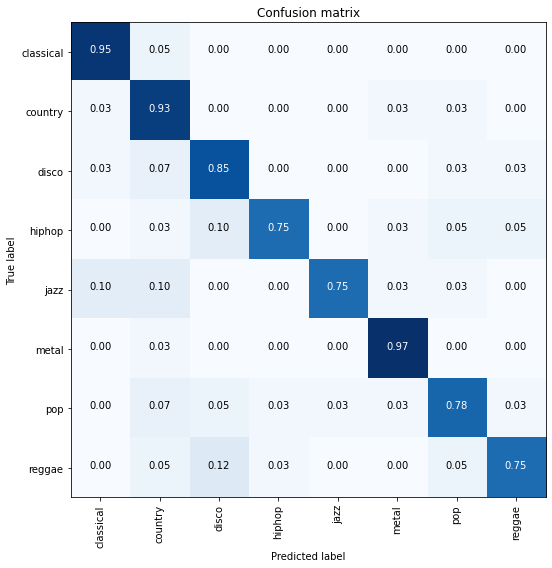

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3363] [Train Acc: 0.9462] [Valid Loss: 1.4584] [Valid Acc: 0.8313]
[Epoch 20/70] [Train Loss: 1.3014] [Train Acc: 0.9763] [Valid Loss: 1.4261] [Valid Acc: 0.8562]
Epoch    20: reducing learning rate of group 0 to 2.1000e-03.
Epoch    28: reducing learning rate of group 0 to 1.4700e-03.
[Epoch 30/70] [Train Loss: 1.2833] [Train Acc: 0.9921] [Valid Loss: 1.4199] [Valid Acc: 0.8500]
Epoch    32: reducing learning rate of group 0 to 1.0290e-03.
Epoch    36: reducing learning rate of group 0 to 7.2030e-04.
[Epoch 40/70] [Train Loss: 1.2806] [Train Acc: 0.9944] [Valid Loss: 1.4202] [Valid Acc: 0.8500]
Epoch    40: reducing learning rate of group 0 to 5.0421e-04.
Epoch    44: reducing learning rate of group 0 to 3.5295e-04.
Epoch    48: reducing learning rate of group 0 to 2.4706e-04.
[Epoch 50/70] [Train Loss: 1.2792] [Train Acc: 0.9956] [Valid Loss: 1.4178] [Valid Acc: 0.8500]
Epoch    52: reducing learning rate of group 0 to 1.7294e-04.
Epoch 

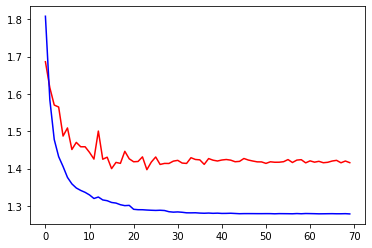

0.85938
Normalized confusion matrix


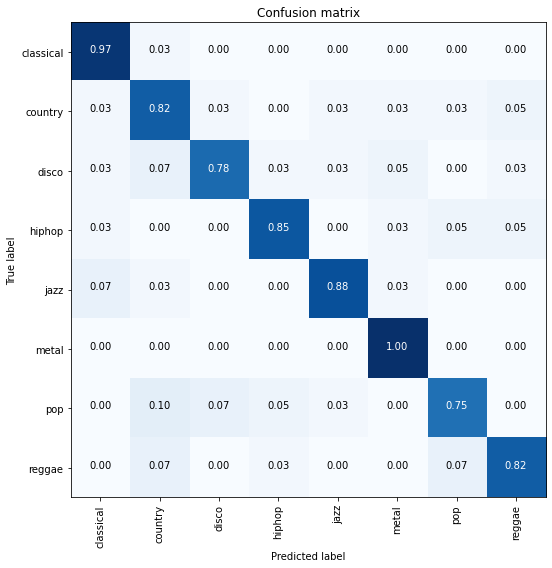

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3241] [Train Acc: 0.9553] [Valid Loss: 1.4465] [Valid Acc: 0.8313]
Epoch    18: reducing learning rate of group 0 to 2.1700e-03.
[Epoch 20/70] [Train Loss: 1.2910] [Train Acc: 0.9862] [Valid Loss: 1.4590] [Valid Acc: 0.8187]
Epoch    25: reducing learning rate of group 0 to 1.5190e-03.
Epoch    29: reducing learning rate of group 0 to 1.0633e-03.
[Epoch 30/70] [Train Loss: 1.2814] [Train Acc: 0.9938] [Valid Loss: 1.4479] [Valid Acc: 0.8250]
Epoch    35: reducing learning rate of group 0 to 7.4431e-04.
Epoch    39: reducing learning rate of group 0 to 5.2102e-04.
[Epoch 40/70] [Train Loss: 1.2795] [Train Acc: 0.9953] [Valid Loss: 1.4498] [Valid Acc: 0.8250]
Epoch    43: reducing learning rate of group 0 to 3.6471e-04.
Epoch    47: reducing learning rate of group 0 to 2.5530e-04.
[Epoch 50/70] [Train Loss: 1.2787] [Train Acc: 0.9961] [Valid Loss: 1.4417] [Valid Acc: 0.8375]
Epoch    55: reducing learning rate of group 0 to 1.7871e-04.
Epoch 

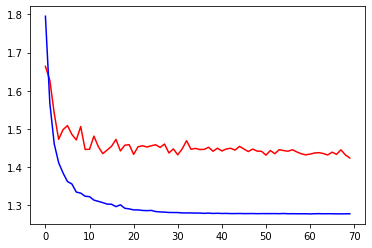

0.85
Normalized confusion matrix


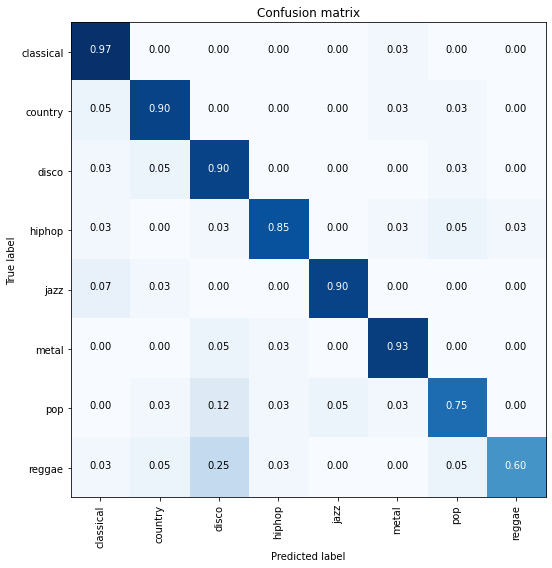

Training on GPU:0
Epoch     8: reducing learning rate of group 0 to 2.1700e-03.
[Epoch 10/70] [Train Loss: 1.3219] [Train Acc: 0.9572] [Valid Loss: 1.4422] [Valid Acc: 0.8562]
Epoch    18: reducing learning rate of group 0 to 1.5190e-03.
[Epoch 20/70] [Train Loss: 1.2937] [Train Acc: 0.9835] [Valid Loss: 1.4552] [Valid Acc: 0.8125]
Epoch    22: reducing learning rate of group 0 to 1.0633e-03.
Epoch    26: reducing learning rate of group 0 to 7.4431e-04.
[Epoch 30/70] [Train Loss: 1.2824] [Train Acc: 0.9935] [Valid Loss: 1.4528] [Valid Acc: 0.8063]
Epoch    31: reducing learning rate of group 0 to 5.2102e-04.
Epoch    37: reducing learning rate of group 0 to 3.6471e-04.
[Epoch 40/70] [Train Loss: 1.2806] [Train Acc: 0.9952] [Valid Loss: 1.4330] [Valid Acc: 0.8500]
Epoch    41: reducing learning rate of group 0 to 2.5530e-04.
Epoch    45: reducing learning rate of group 0 to 1.7871e-04.
Epoch    49: reducing learning rate of group 0 to 1.2510e-04.
[Epoch 50/70] [Train Loss: 1.2803] [Trai

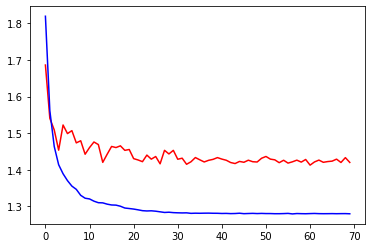

0.86875
Normalized confusion matrix


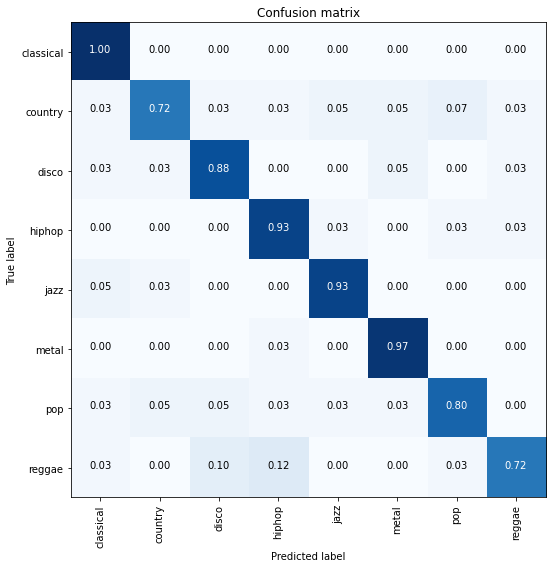

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3319] [Train Acc: 0.9476] [Valid Loss: 1.4841] [Valid Acc: 0.7937]
Epoch    10: reducing learning rate of group 0 to 2.2400e-03.
Epoch    15: reducing learning rate of group 0 to 1.5680e-03.
[Epoch 20/70] [Train Loss: 1.2921] [Train Acc: 0.9847] [Valid Loss: 1.4730] [Valid Acc: 0.8000]
Epoch    20: reducing learning rate of group 0 to 1.0976e-03.
Epoch    24: reducing learning rate of group 0 to 7.6832e-04.
Epoch    28: reducing learning rate of group 0 to 5.3782e-04.
[Epoch 30/70] [Train Loss: 1.2824] [Train Acc: 0.9938] [Valid Loss: 1.4448] [Valid Acc: 0.8375]
Epoch    32: reducing learning rate of group 0 to 3.7648e-04.
Epoch    36: reducing learning rate of group 0 to 2.6353e-04.
[Epoch 40/70] [Train Loss: 1.2808] [Train Acc: 0.9944] [Valid Loss: 1.4387] [Valid Acc: 0.8438]
Epoch    40: reducing learning rate of group 0 to 1.8447e-04.
Epoch    44: reducing learning rate of group 0 to 1.2913e-04.
Epoch    48: reducing learning rate of g

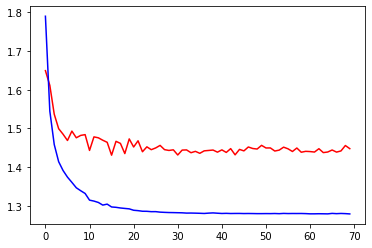

0.83437
Normalized confusion matrix


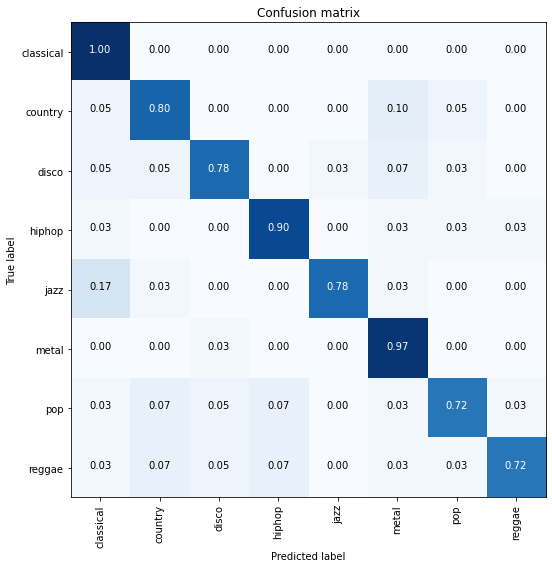

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3295] [Train Acc: 0.9502] [Valid Loss: 1.4893] [Valid Acc: 0.7937]
Epoch    13: reducing learning rate of group 0 to 2.2400e-03.
[Epoch 20/70] [Train Loss: 1.2932] [Train Acc: 0.9837] [Valid Loss: 1.4361] [Valid Acc: 0.8375]
Epoch    27: reducing learning rate of group 0 to 1.5680e-03.
[Epoch 30/70] [Train Loss: 1.2830] [Train Acc: 0.9929] [Valid Loss: 1.4406] [Valid Acc: 0.8375]
Epoch    31: reducing learning rate of group 0 to 1.0976e-03.
Epoch    35: reducing learning rate of group 0 to 7.6832e-04.
Epoch    39: reducing learning rate of group 0 to 5.3782e-04.
[Epoch 40/70] [Train Loss: 1.2794] [Train Acc: 0.9957] [Valid Loss: 1.4465] [Valid Acc: 0.8313]
Epoch    43: reducing learning rate of group 0 to 3.7648e-04.
Epoch    47: reducing learning rate of group 0 to 2.6353e-04.
[Epoch 50/70] [Train Loss: 1.2787] [Train Acc: 0.9959] [Valid Loss: 1.4414] [Valid Acc: 0.8313]
Epoch    51: reducing learning rate of group 0 to 1.8447e-04.
Epoch 

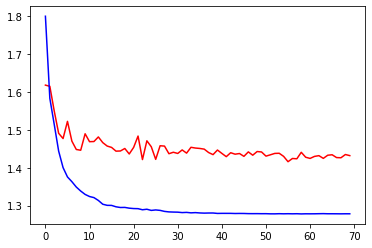

0.83125
Normalized confusion matrix


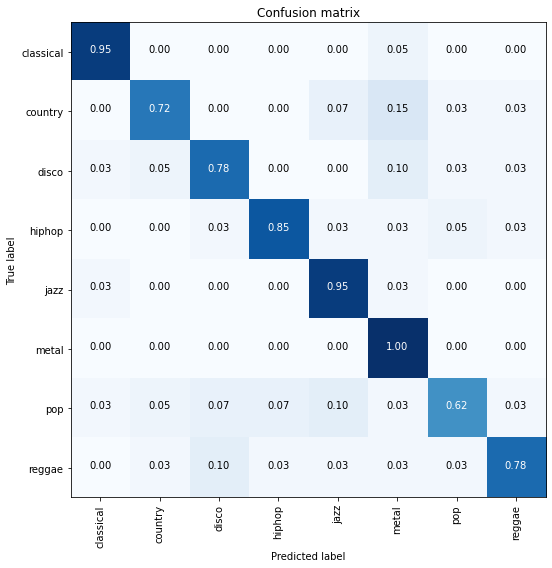

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3321] [Train Acc: 0.9493] [Valid Loss: 1.4372] [Valid Acc: 0.8375]
Epoch    12: reducing learning rate of group 0 to 2.3800e-03.
Epoch    17: reducing learning rate of group 0 to 1.6660e-03.
[Epoch 20/70] [Train Loss: 1.2926] [Train Acc: 0.9839] [Valid Loss: 1.4027] [Valid Acc: 0.8688]
Epoch    21: reducing learning rate of group 0 to 1.1662e-03.
Epoch    25: reducing learning rate of group 0 to 8.1634e-04.
Epoch    29: reducing learning rate of group 0 to 5.7144e-04.
[Epoch 30/70] [Train Loss: 1.2844] [Train Acc: 0.9917] [Valid Loss: 1.3993] [Valid Acc: 0.8750]
Epoch    33: reducing learning rate of group 0 to 4.0001e-04.
Epoch    37: reducing learning rate of group 0 to 2.8000e-04.
[Epoch 40/70] [Train Loss: 1.2817] [Train Acc: 0.9936] [Valid Loss: 1.3935] [Valid Acc: 0.8875]
Epoch    41: reducing learning rate of group 0 to 1.9600e-04.
Epoch    48: reducing learning rate of group 0 to 1.3720e-04.
[Epoch 50/70] [Train Loss: 1.2818] [Trai

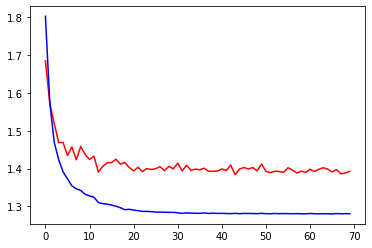

0.86562
Normalized confusion matrix


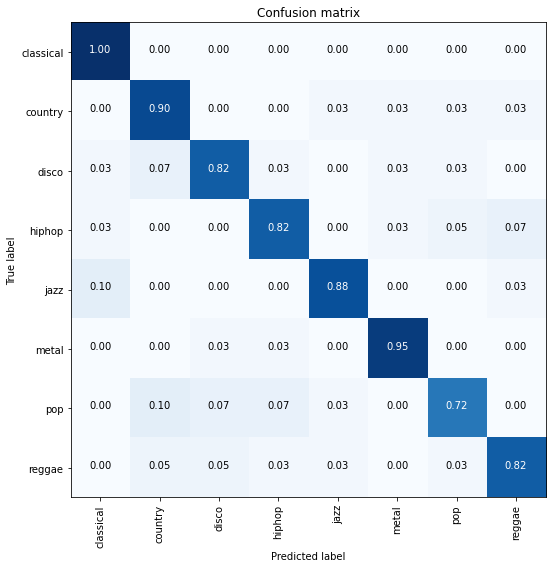

Training on GPU:0
[Epoch 10/70] [Train Loss: 1.3367] [Train Acc: 0.9437] [Valid Loss: 1.4985] [Valid Acc: 0.7875]
Epoch    16: reducing learning rate of group 0 to 2.3800e-03.
[Epoch 20/70] [Train Loss: 1.2958] [Train Acc: 0.9812] [Valid Loss: 1.4527] [Valid Acc: 0.8250]
Epoch    20: reducing learning rate of group 0 to 1.6660e-03.
Epoch    28: reducing learning rate of group 0 to 1.1662e-03.
[Epoch 30/70] [Train Loss: 1.2828] [Train Acc: 0.9929] [Valid Loss: 1.4446] [Valid Acc: 0.8250]
Epoch    36: reducing learning rate of group 0 to 8.1634e-04.
[Epoch 40/70] [Train Loss: 1.2791] [Train Acc: 0.9960] [Valid Loss: 1.4378] [Valid Acc: 0.8313]
Epoch    46: reducing learning rate of group 0 to 5.7144e-04.
[Epoch 50/70] [Train Loss: 1.2786] [Train Acc: 0.9962] [Valid Loss: 1.4445] [Valid Acc: 0.8375]
Epoch    50: reducing learning rate of group 0 to 4.0001e-04.
Epoch    54: reducing learning rate of group 0 to 2.8000e-04.
Epoch    58: reducing learning rate of group 0 to 1.9600e-04.
[Epoch

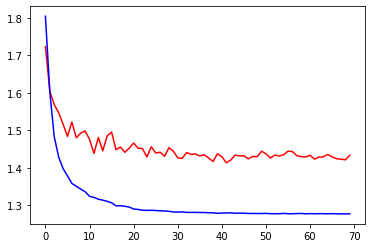

0.85625
Normalized confusion matrix


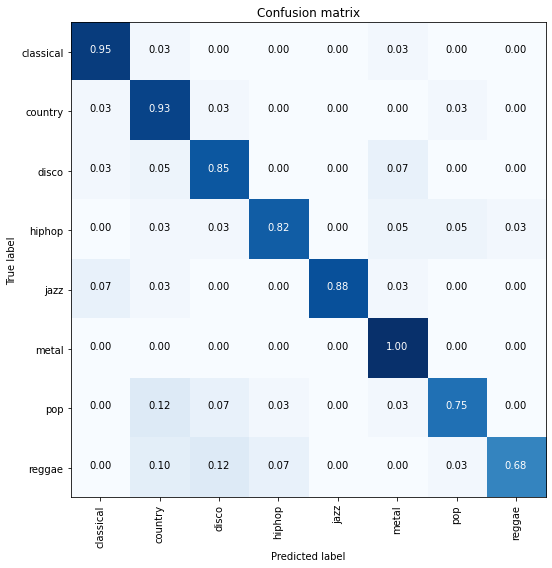

./model_0.0028_70_50
0.86875


In [14]:
best=''
best_acc = 0

for lr in lrs :
    for bt in bts:
        acc, path = run(lr,70,bt)
        if acc > best_acc:
            best_acc = acc
            best =path
        gc.collect()
        torch.cuda.empty_cache() 
        
print(best)
print(best_acc)

In [ ]:
def draw_cm_model(norm = False):
    modelA = runner.model()
    device = torch.device("cuda:" + str(hparams.device - 1))
    all_preds = torch.tensor([])
    Y = torch.tensor([])

    for batch, (x, y) in enumerate(test_loader):
        y = y.type(torch.float)
        Y = torch.cat((Y, y), dim= 0)
        pred= modelA(x)
        all_preds = torch.cat((all_preds, pred), dim= 0)

    for batch, (x, y) in enumerate(valid_loader):
        y = y.type(torch.float)
        Y = torch.cat((Y, y), dim= 0)
        pred= modelA(x)
        all_preds = torch.cat((all_preds, pred), dim= 0)
        
    preds = all_preds.argmax(dim=1)
    preds = preds.type(torch.float)
    stacked = torch.stack((preds,Y), dim = 1)
    cmt = torch.zeros(8,8, dtype=torch.int64)
    for p in stacked:
        j,k = p.tolist()
        j= int(j)
        k= int(k)
        cmt[j,k] = cmt[j,k]+1
        
    Y= Y.numpy()
    preds=preds.numpy()
    
    gs = ('classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae')
    cm = confusion_matrix(Y,preds)
    plt.figure(figsize=(8,8))
    plot_confusion_matrix(cm, gs,normalize=norm )

In [56]:
torch.cuda.empty_cache() 